<center>Национальный исследовательский университет ИТМО<br/>Факультет информационных технологий и программирования<br/>Прикладная математика и информатика</center>

## <center>Методы оптимизации</center>
### <center>Отчёт по лабораторной работе №4</center>

<div style="text-align: right"><b>Работу выполнили:</b><br/>Салахов Камиль M33381<br/>Мухтаров Айнур M33371<br/>

<center>Санкт-Петербург<br/>2023</center>

# Постановка задачи:
1. Изучить использование вариантов SGD (torch.optim) из PyTorch. Исследовать эффективность и сравнить с
собственными реализациями из 2 работы.
2. Изучить использование готовых методов оптимизации из SciPy (scipy.optimize.minimize, scipy.optimize.least_squares)
  1. Исследовать эффективность и сравнить с собственными реализациями из 3 работы.
  2. Реализовать использование PyTorch для вычисления градиента и сравнить с другими подходами.
  3. Исследовать как задание границ изменения параметров влияет на работу методов из SciPy.

## Бонус
Исследовать использование линейных и нелинейных ограничений scipy.optimize.minimize из SciPy

(scipy.optimize.LinearConstraint и scipy.optimize.NonlinearConstraint). Рассмотреть случаи когда минимум находится на границе заданной области и когда он расположен внутри.

# 1. Изучить использование вариантов SGD (torch.optim) из PyTorch. Исследовать эффективность и сравнить с собственными реализациями из 2 работы.

Проимпортируем библиотеки и сразу зафиксируем сид для рандома:

In [ ]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import time

np.random.seed(+7_952_812)
# Да здравствует Санкт-Петербург

Скопируем код из второй лабораторной работы, который нам нужно сравнить с библиотечными функциями:

In [ ]:
class Coefficient:
    def __init__(self, dim):
        self.dim = dim
        self.w = np.zeros(dim)
        self.b = np.zeros(1)
        self.operations = 0
        self.memory = 0

    def calculate_grad(self, X, y, b, w):
        n = X.shape[0]
        m = X.shape[1]

        prev_value = b + X @ w
        y_diff = prev_value - y  # 1
        grad_b = 2.0 * np.mean(y_diff, axis=-1)  # 2
        grad_w = 2.0 * np.mean(np.transpose(X) * y_diff, axis=-1)  # 3

        self.operations += n  # 1
        self.operations += 1 + n  # 2
        self.operations += n + 3 * n * m  # 3

        self.memory += n  # 1
        self.memory += 2  # 2
        self.memory += 2 * n * m  # 3
        return grad_b, grad_w

    def get_grads(self, X, y):
        return self.calculate_grad(X, y, self.b, self.w)

    def update_stats(self, operations_multiplier, memory_multiplier):
        self.operations += operations_multiplier * self.dim
        self.memory += memory_multiplier * self.dim

    def __call__(self, b, w):
        c = Coefficient(w.shape[0])
        c.b = b
        c.w = w
        return c

    def get_normalized(self, mean, std):
        return (self.b - mean) / std, self.w / std


class ExtendedCoefficient(Coefficient):
    def __init__(self, dim):
        super().__init__(dim)
        self.bv = np.zeros(1)
        self.wv = np.zeros(dim)
        self.bs = np.zeros(1)
        self.ws = np.zeros(dim)

    def get_grads(self, X, y, nesterov_factor=None):
        if nesterov_factor is None:
            return super().get_grads(X, y)
        new_b = self.b - nesterov_factor * self.bv
        new_w = self.w - nesterov_factor * self.wv
        self.operations += 4 * self.dim
        self.memory += 2 * self.dim
        return super().calculate_grad(X, y, new_b, new_w)


class AdamCoefficient(ExtendedCoefficient):
    def __init__(self, dim):
        super().__init__(dim)
        self.b1p = 1
        self.b2p = 1

In [ ]:
EPS = 1e-6
class LinearRegression:
    def __init__(self, X, y, method, coef_type="extended"):
        self.mean = 0
        self.std = 1
        self.X_was = X
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.dim = X.shape[1]
        self.method = method
        if coef_type == 'usual':
            self.coefficient = Coefficient(self.dim)
        elif coef_type == 'adam':
            self.coefficient = AdamCoefficient(self.dim)
        else:
            self.coefficient = ExtendedCoefficient(self.dim)
        self.way = [self.inverted_point()]

    def get_batches(self, indexes, batch_size):
        batches = (self.n + batch_size - 1) // batch_size
        for i in range(batches):
            yield self.X[indexes[batch_size * i: batch_size * (i + 1)], :], \
                self.y[indexes[batch_size * i: batch_size * (i + 1)]]

    def get_loss(self):
        return np.mean((self.coefficient.b + self.X @ self.coefficient.w - self.y) ** 2)

    def inverted_point(self):
        b = self.coefficient.b.copy()
        w = self.coefficient.w.copy()
        b = (b + self.mean) * self.std
        w = w * self.std
        return np.append(w, b)

    def start_gradient_descent(self, batch_size=5, lr=0.1, epochs=10000, learning_rate_scheduler=None):
        shuffled_indexes = np.arange(self.n)
        losses = []
        for epoch in range(epochs):
            np.random.shuffle(shuffled_indexes)
            max_norm = 0
            for batch_X, batch_y in self.get_batches(shuffled_indexes, batch_size):
                grad = self.method(self.coefficient, batch_X, batch_y, lr)
                max_norm = max(max_norm, np.linalg.norm(grad))
            losses.append(self.get_loss())
            self.way.append(self.inverted_point())
            if max_norm < EPS:
                return epoch
            if learning_rate_scheduler is not None:
                lr = learning_rate_scheduler(lr, epoch)
        return epochs

    def get_normalized_coefficient(self):
        return self.coefficient.get_normalized(self.mean, self.std)

class NormalizedLinearRegression:
    def __init__(self, X, y, method, coef_type="extended"):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        self.X_was = X
        self.X = (X - self.mean) / self.std
        self.y = y
        self.n = X.shape[0]
        self.dim = X.shape[1]
        self.method = method
        if coef_type == 'usual':
            self.coefficient = Coefficient(self.dim)
        elif coef_type == 'adam':
            self.coefficient = AdamCoefficient(self.dim)
        else:
            self.coefficient = ExtendedCoefficient(self.dim)
        self.way = [self.inverted_point()]

    def get_batches(self, indexes, batch_size):
        batches = (self.n + batch_size - 1) // batch_size
        for i in range(batches):
            yield self.X[indexes[batch_size * i: batch_size * (i + 1)], :], \
                self.y[indexes[batch_size * i: batch_size * (i + 1)]]

    def get_loss(self):
        return np.mean((self.coefficient.b + self.X @ self.coefficient.w - self.y) ** 2)

    def inverted_point(self):
        b = self.coefficient.b.copy()
        w = self.coefficient.w.copy()
        b = (b + self.mean) * self.std
        w = w * self.std
        return np.append(w, b)

    def start_gradient_descent(self, batch_size=5, lr=0.1, epochs=10000, learning_rate_scheduler=None):
        shuffled_indexes = np.arange(self.n)
        losses = []
        for epoch in range(epochs):
            np.random.shuffle(shuffled_indexes)
            max_norm = 0
            for batch_X, batch_y in self.get_batches(shuffled_indexes, batch_size):
                grad = self.method(self.coefficient, batch_X, batch_y, lr)
                max_norm = max(max_norm, np.linalg.norm(grad))
            losses.append(self.get_loss())
            self.way.append(self.inverted_point())
            if max_norm < EPS:
                return epoch
            if learning_rate_scheduler is not None:
                lr = learning_rate_scheduler(lr, epoch)
        return epochs

    def get_normalized_coefficient(self):
        return self.coefficient.get_normalized(self.mean, self.std)

In [ ]:
def stochastic(coefficient: Coefficient, X, y, lr):
    n = X.shape[0]
    grad_b, grad_w = coefficient.get_grads(X, y)
    coefficient.b -= lr * grad_b  # 1
    coefficient.w -= lr * grad_w  # 2
    coefficient.operations += 1  # 1
    coefficient.operations += n  # 2
    return np.append(grad_w, grad_b)

In [ ]:
def Momentum(coefficient: ExtendedCoefficient, X, y, lr=0.1, gamma=0.8):
    grad_b, grad_w = coefficient.get_grads(X, y)

    coefficient.bv = gamma * coefficient.bv + (1 - gamma) * grad_b  # 1
    coefficient.wv = gamma * coefficient.wv + (1 - gamma) * grad_w  # 2

    coefficient.b -= lr * coefficient.bv
    coefficient.w -= lr * coefficient.wv
    coefficient.update_stats(6, 4)
    return np.append(grad_w, grad_b)

In [ ]:
def Nesterov(coefficient: ExtendedCoefficient, X, y, lr=0.13, gamma=0.8):
    grad_new_b, grad_new_w = coefficient.get_grads(X, y, nesterov_factor=lr * gamma)

    coefficient.bv = gamma * coefficient.bv + (1 - gamma) * grad_new_b  # 1
    coefficient.wv = gamma * coefficient.wv + (1 - gamma) * grad_new_w  # 2

    coefficient.b -= lr * coefficient.bv
    coefficient.w -= lr * coefficient.wv
    coefficient.update_stats(6, 4)
    return np.append(grad_new_w, grad_new_b)

In [ ]:
def AdaGrad(coefficient: ExtendedCoefficient, X, y, lr=100, ADA_GRAD_EPS=1e-7):
    grad_b, grad_w = coefficient.get_grads(X, y)

    coefficient.bs += grad_b ** 2
    coefficient.ws += grad_w ** 2
    coefficient.update_stats(2, 2)

    coefficient.b -= lr * grad_b / np.sqrt(coefficient.bs + ADA_GRAD_EPS)
    coefficient.w -= lr * grad_w / np.sqrt(coefficient.ws + ADA_GRAD_EPS)
    coefficient.update_stats(6, 2)

    return np.append(grad_w, grad_b)

In [ ]:
def RMSProp(coefficient: ExtendedCoefficient, X, y, lr=3, beta=0.99, RMS_PROP_EPS=1e-7):
    grad_b, grad_w = coefficient.get_grads(X, y)

    coefficient.bs = beta * coefficient.bs + (1 - beta) * grad_b * grad_b
    coefficient.ws = beta * coefficient.ws + (1 - beta) * grad_w * grad_w
    coefficient.update_stats(8, 2)

    coefficient.b -= lr * grad_b / np.sqrt(coefficient.bs + RMS_PROP_EPS)
    coefficient.w -= lr * grad_w / np.sqrt(coefficient.ws + RMS_PROP_EPS)
    coefficient.update_stats(6, 2)

    return np.append(grad_w, grad_b)

In [ ]:
def Adam(coefficient: AdamCoefficient, X, y, lr=3.5, beta1=0.9, beta2=0.99, ADAM_EPS=1e-7):
    grad_b, grad_w = coefficient.get_grads(X, y)

    coefficient.bv = beta1 * coefficient.bv + (1 - beta1) * grad_b
    coefficient.wv = beta1 * coefficient.wv + (1 - beta1) * grad_w
    coefficient.update_stats(6, 2)

    coefficient.bs = beta2 * coefficient.bs + (1 - beta2) * grad_b * grad_b
    coefficient.ws = beta2 * coefficient.ws + (1 - beta2) * grad_w * grad_w
    coefficient.update_stats(8, 2)

    coefficient.b1p *= beta1
    coefficient.b2p *= beta2
    coefficient.operations += 2

    new_bv = coefficient.bv / (1 - coefficient.b1p)
    new_wv = coefficient.wv / (1 - coefficient.b1p)
    coefficient.update_stats(1, 1)

    new_bs = coefficient.bs / (1 - coefficient.b2p)
    new_ws = coefficient.ws / (1 - coefficient.b2p)
    coefficient.update_stats(1, 1)

    coefficient.b -= lr * new_bv / np.sqrt(new_bs + ADAM_EPS)
    coefficient.w -= lr * new_wv / np.sqrt(new_ws + ADAM_EPS)
    coefficient.update_stats(6, 2)
    return np.append(grad_w, grad_b)

Теперь реализуем то же самое с помощью torch:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# Задаем модель, которую хотим оптимизировать
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        return self.fc(x)

# Генерируем фиктивные данные для обучения
def start_lib_lin_reg(data, target, optim_ctor, lr = 0.1, batch_size = 2,epochs = 10000):
  # Инициализируем модель
  model = SimpleModel()

  # Инициализируем оптимизатор (AdaGrad)
  optimizer = optim_ctor(model, lr)

  # Функция потерь (Mean Squared Error)
  criterion = nn.MSELoss()


  for epoch in range(epochs):
      for i in range(0, len(data), batch_size):
          # Получаем мини-батч данных
          inputs = Variable(torch.from_numpy( data[i:i+batch_size]))
          labels = Variable(torch.from_numpy(target[i:i+batch_size]))

          # Обнуляем градиенты
          optimizer.zero_grad()

          # Подсчет предсказаний
          outputs = model(inputs)

          # Подсчет функции потерь
          loss = criterion(outputs, labels)

          # Обратное распространение ошибки и обновление весов
          loss.backward()
          optimizer.step()

  trained_params = model.state_dict()
  weights = trained_params['fc.weight']
  biases = trained_params['fc.bias']
  return biases[0], weights[0][0]


# Сравним наши алгоритмы с библиотечными реализациями

Создадим функцию, которая генерирует рандомные точки на прямой с шумом:


In [ ]:
def generate_X_y(dim=1, num_points=10, lower_bound=-100, upper_bound=100, noise=5):
    X = np.random.uniform(lower_bound, upper_bound, (num_points, dim))
    w = np.random.uniform(-5, 5, dim)
    b = np.random.uniform(-5, 5, 1)
    y = X @ w + b
    y += np.random.uniform(-noise, noise, num_points)
    return X, y

def transform_to_torch(X, y):
    y = y.reshape(-1, 1)
    return X.astype(np.float32), y.astype(np.float32)

Проимпортируем библиотеки, необходимые для сравнения эффективности (контроль памяти и времени):

In [ ]:
import tracemalloc
from time import time

Теперь создадим главную функцию для тестов, которая принимает наш метод и библиотечный метод, а после сравнивает их:

In [ ]:
def test_SGD(my_ctor,  oprimizer_ctor, name, points=100, batch_size = 16, lr = 0.0001, epochs = 1000):
    x, y = generate_X_y(num_points=points)


    t1 = time()
    tracemalloc.start()
    myReg = my_ctor(x, y)
    myReg.start_gradient_descent(batch_size=batch_size, lr=lr, epochs=epochs)
    my_reg_time = time() - t1
    _, my_peek_mem = tracemalloc.get_traced_memory()

    x_train, y_train = transform_to_torch(x, y)
    t2 = time()
    tracemalloc.reset_peak()
    lib_b, lib_a = start_lib_lin_reg(x_train, y_train, oprimizer_ctor, lr=lr, batch_size=batch_size, epochs=epochs)
    lib_reg_time = time() - t2
    _, lib_peek_mem = tracemalloc.get_traced_memory()

    reg_b, reg_a = myReg.get_normalized_coefficient()
    reg_b = torch.from_numpy(reg_b)
    reg_a = torch.from_numpy(reg_a)

    fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    my_reg_time=round(my_reg_time, 4)
    lib_reg_time=round(lib_reg_time, 4)
    my_peek_mem = my_peek_mem/1024/1024
    lib_peek_mem = lib_peek_mem/1024/1024
    my_peek_mem=round(my_peek_mem, 5)
    lib_peek_mem=round(lib_peek_mem, 5)
    diff_a = round((reg_a - lib_a).item(), 5)
    diff_b = round((reg_b - lib_b).item(), 5)
    fig.suptitle(f'Learning rate = {lr}.\n\
     my_time={my_reg_time}, my_memory={my_peek_mem}\
     lib_time={lib_reg_time}, lib_memory={lib_peek_mem}\n\
     diff_a={diff_a}, diff_b={diff_b}',
                 fontsize=20)
    axs[0].scatter(x, y)
    axs[1].scatter(x, y)

    axs[0].plot(x, reg_a * x + reg_b, 'r')
    axs[1].plot(x, lib_a * x + lib_b, 'g')

    axs[2].plot(x, reg_a * x + reg_b - (lib_a * x + lib_b), 'gray')

Инициализируем константы (конструкторы наших методов и конструкторы библиотечных методов):

In [ ]:
MY_CTORS=[
    lambda x, y: LinearRegression(x, y, stochastic, 'usual'),
    lambda x, y: LinearRegression(x, y, Momentum, 'extended'),
    lambda x, y: LinearRegression(x, y, Nesterov, 'extended'),
    lambda x, y: LinearRegression(x, y, AdaGrad, 'extended'),
    lambda x, y: LinearRegression(x, y, RMSProp, 'extended'),
    lambda x, y: LinearRegression(x, y, Adam, 'adam')]
LIB_CTORS=[
    lambda model, lr : torch.optim.SGD(model.parameters(), lr=lr),
    lambda model, lr : torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8),
    lambda model, lr : torch.optim.SGD(model.parameters(), lr=lr, nesterov=True, momentum=0.8),
    lambda model, lr : torch.optim.Adagrad(model.parameters(), lr=lr),
    lambda model, lr : torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-7),
    lambda model, lr : torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-7)]
LRS = [
    0.0001,
    0.0001,
    0.0001,
    80,
    0.1,
    0.1
]
NAMES=[
    'Stochastic',
    'Momentum',
    'Nesterov',
    'AdaGrad',
    'RMSProp',
    'Adam'
]

Нарисуем прямые $y=ax + b$ для каждого метода и сравним графики:

# Stochastic

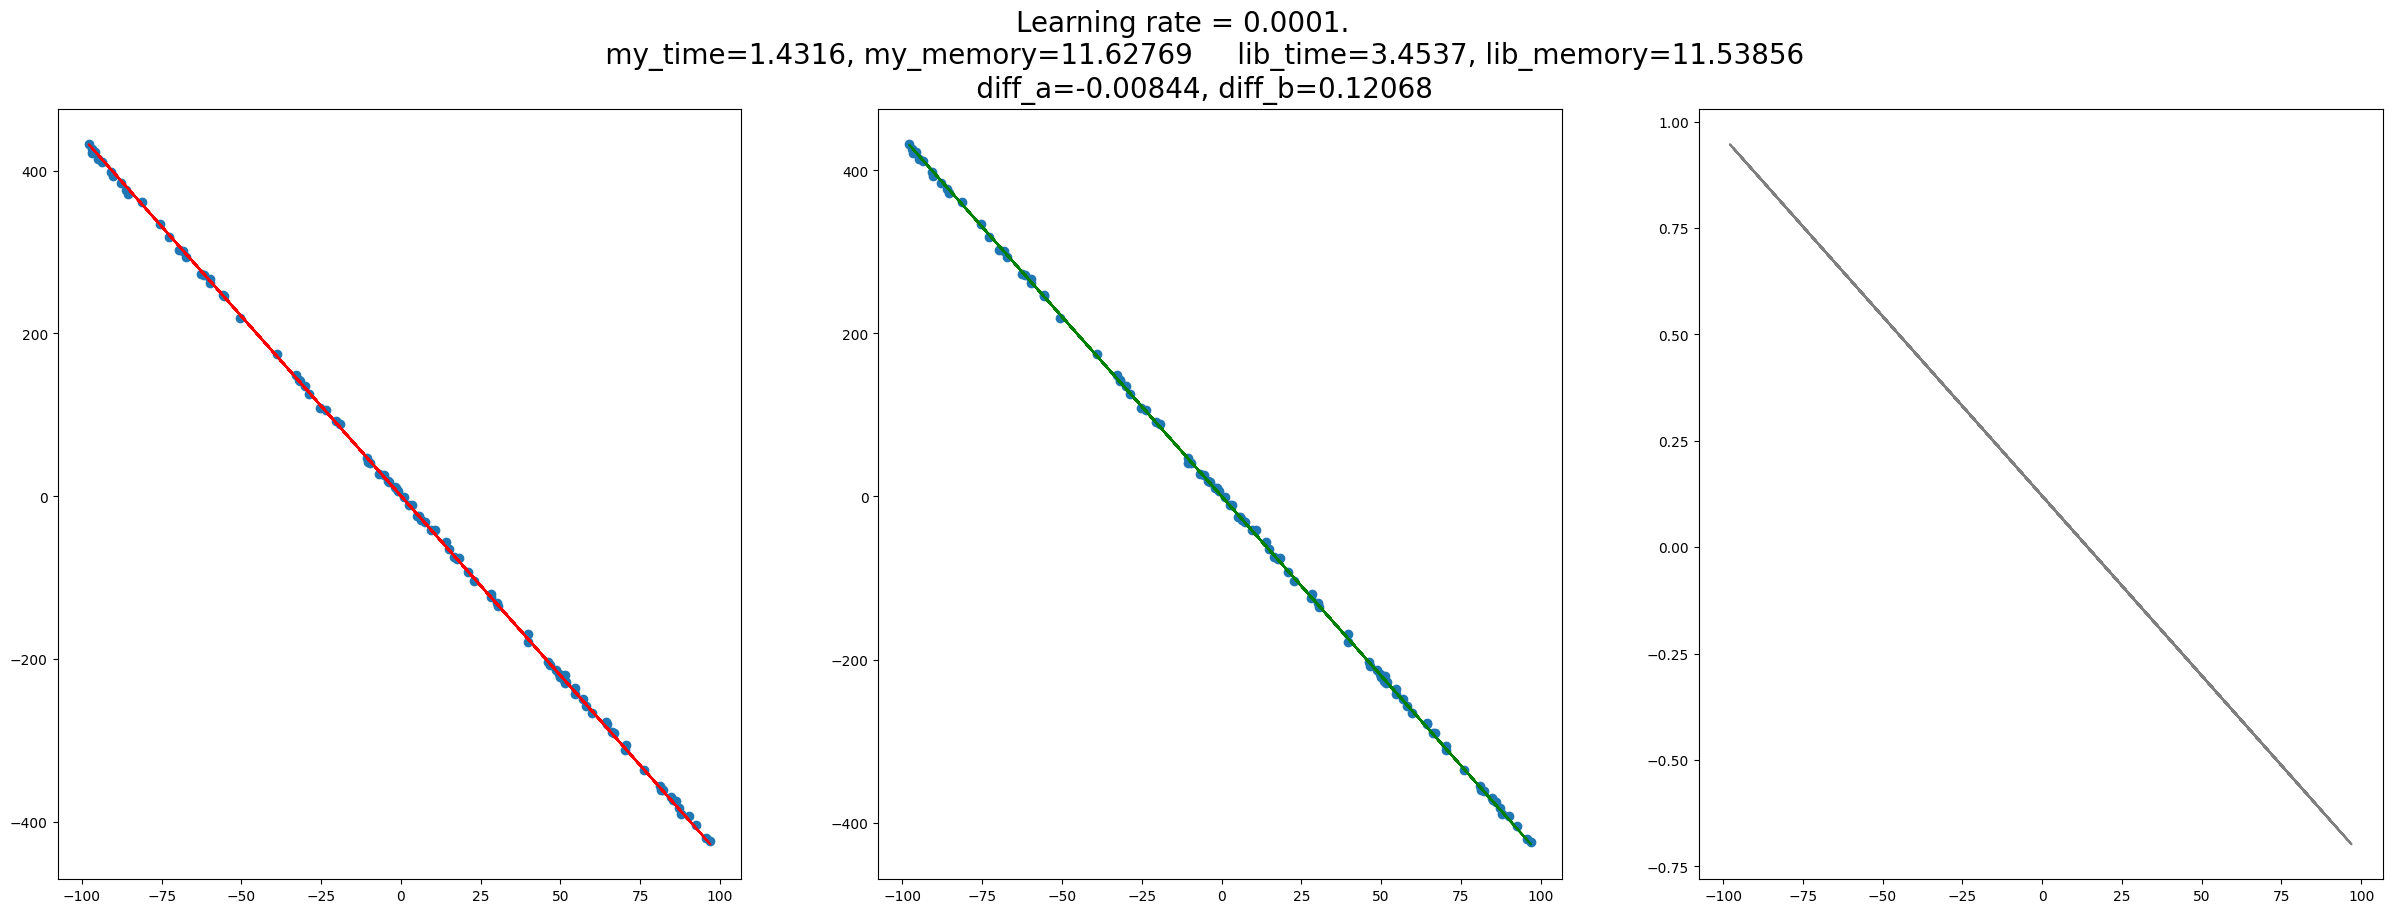

In [ ]:
test_SGD(MY_CTORS[0], LIB_CTORS[0], NAMES[0], lr=LRS[0])

## Выводы

Оба метода довольно хорошо сошлись, разница в подобранных коэффициента мала ($|diff_a| < 0.01$, $|diff_b| < 0.15$)

Наш метод отработал по времени быстрее в 2.5 раза

По памяти оба метода показали себя примерно одинаково


# Momentum

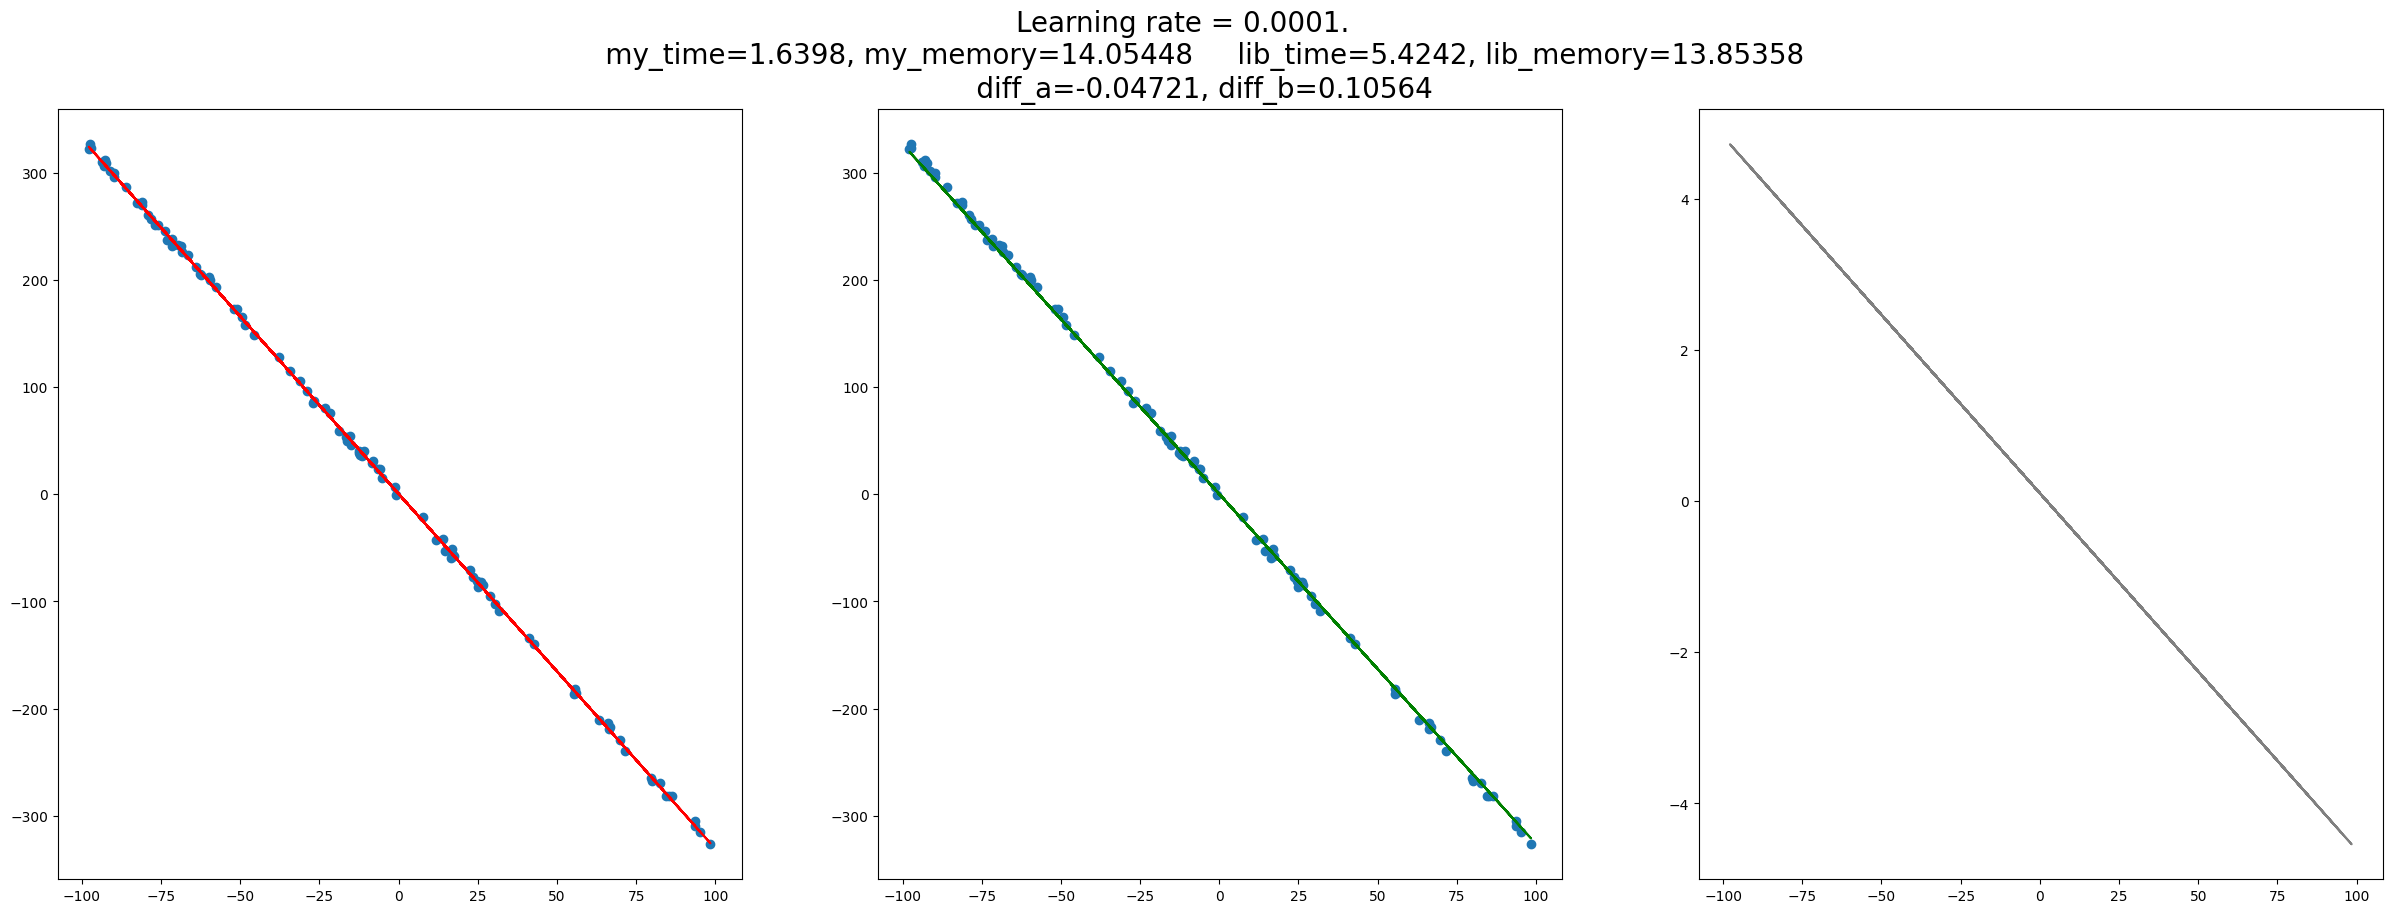

In [ ]:
test_SGD(MY_CTORS[1], LIB_CTORS[1], NAMES[1], lr=LRS[1])

## Выводы

Примерно так же, как и в предыдущем случае.

Оба метода довольно хорошо сошлись, разница в подобранных коэффициента мала ($|diff_a| < 0.05$, $|diff_b| < 0.11$)

Наш метод отработал по времени быстрее в 3 раза

По памяти оба метода показали себя примерно одинаково

# Nesterov

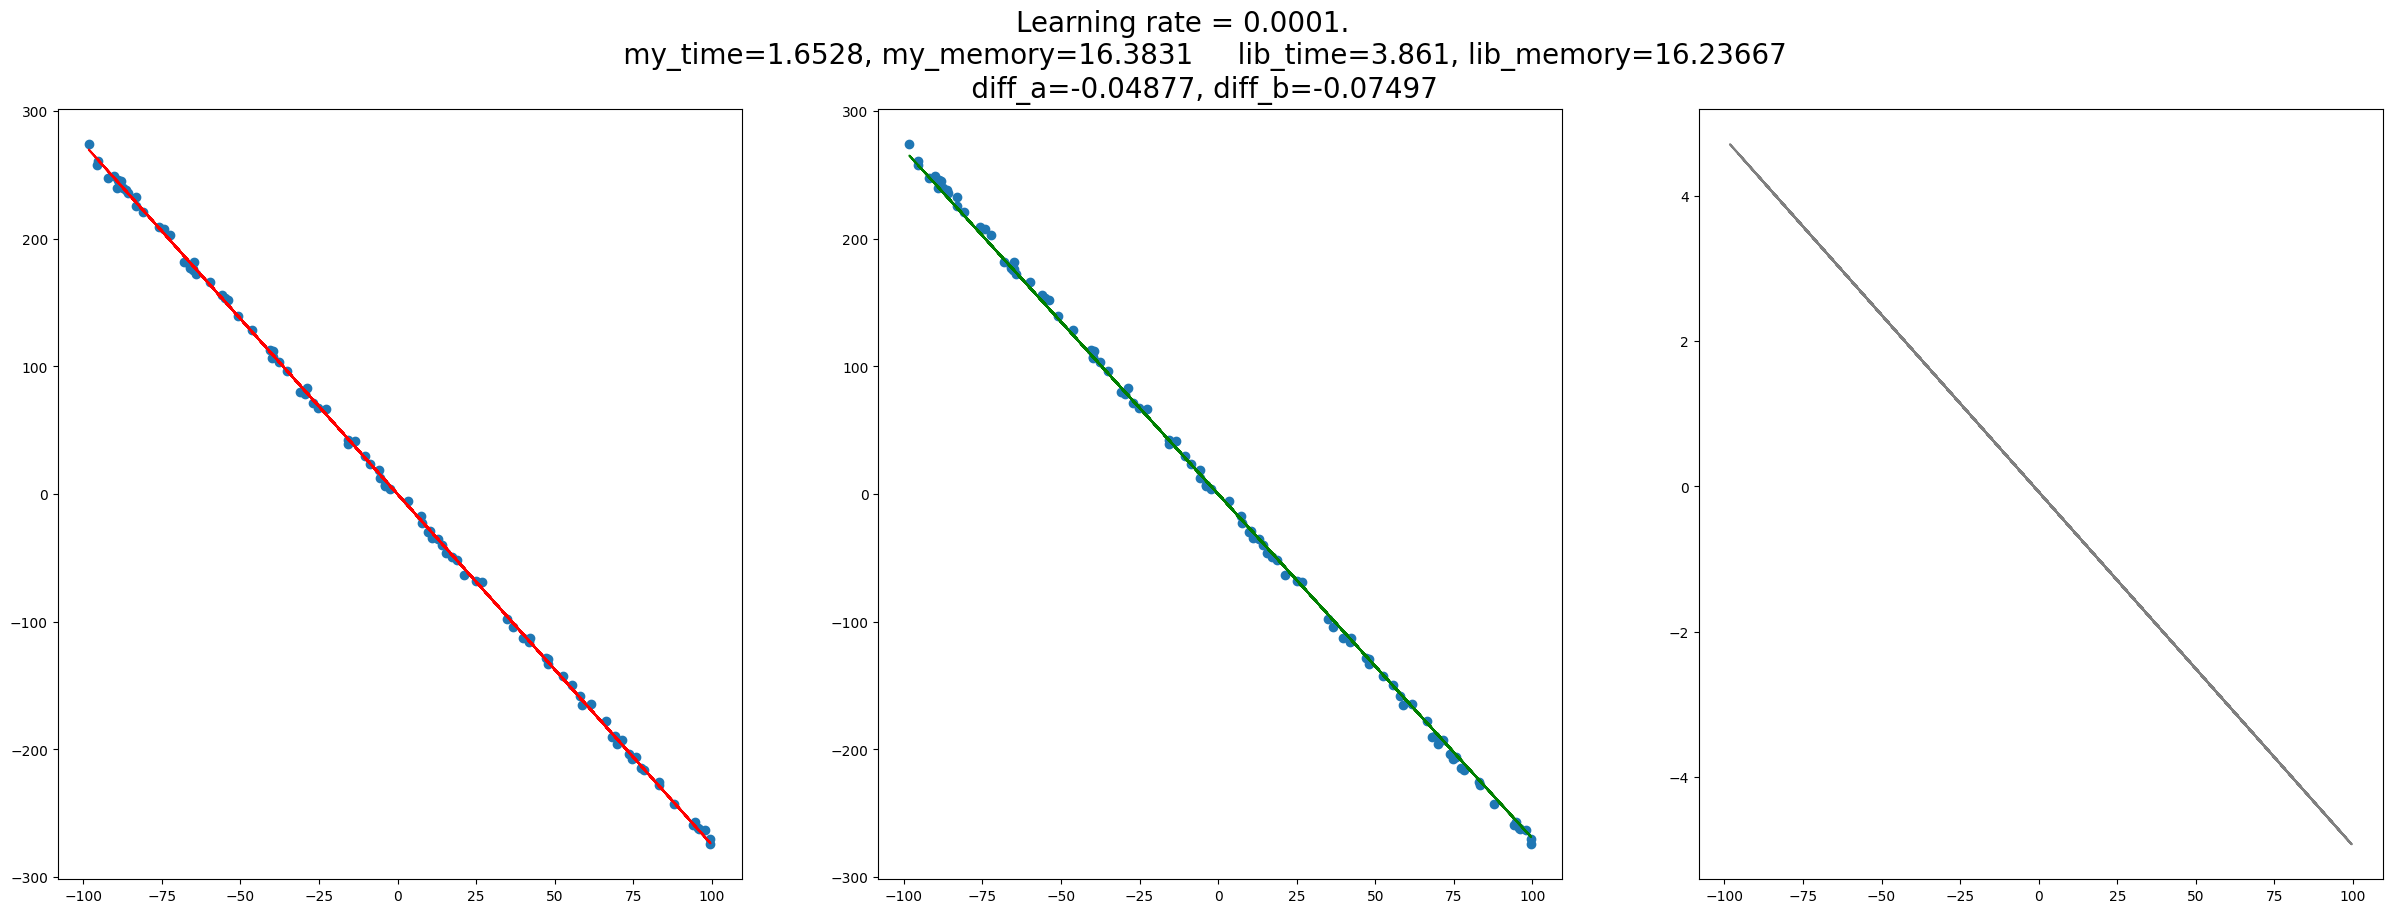

In [ ]:
test_SGD(MY_CTORS[2], LIB_CTORS[2], NAMES[2], lr=LRS[2])

## Выводы

$|diff_a| < 0.05$, $|diff_b| < 0.08$

Наш метод отработал по времени быстрее в 2.3 раза

По памяти оба метода показали себя примерно одинаково


# AdaGrad

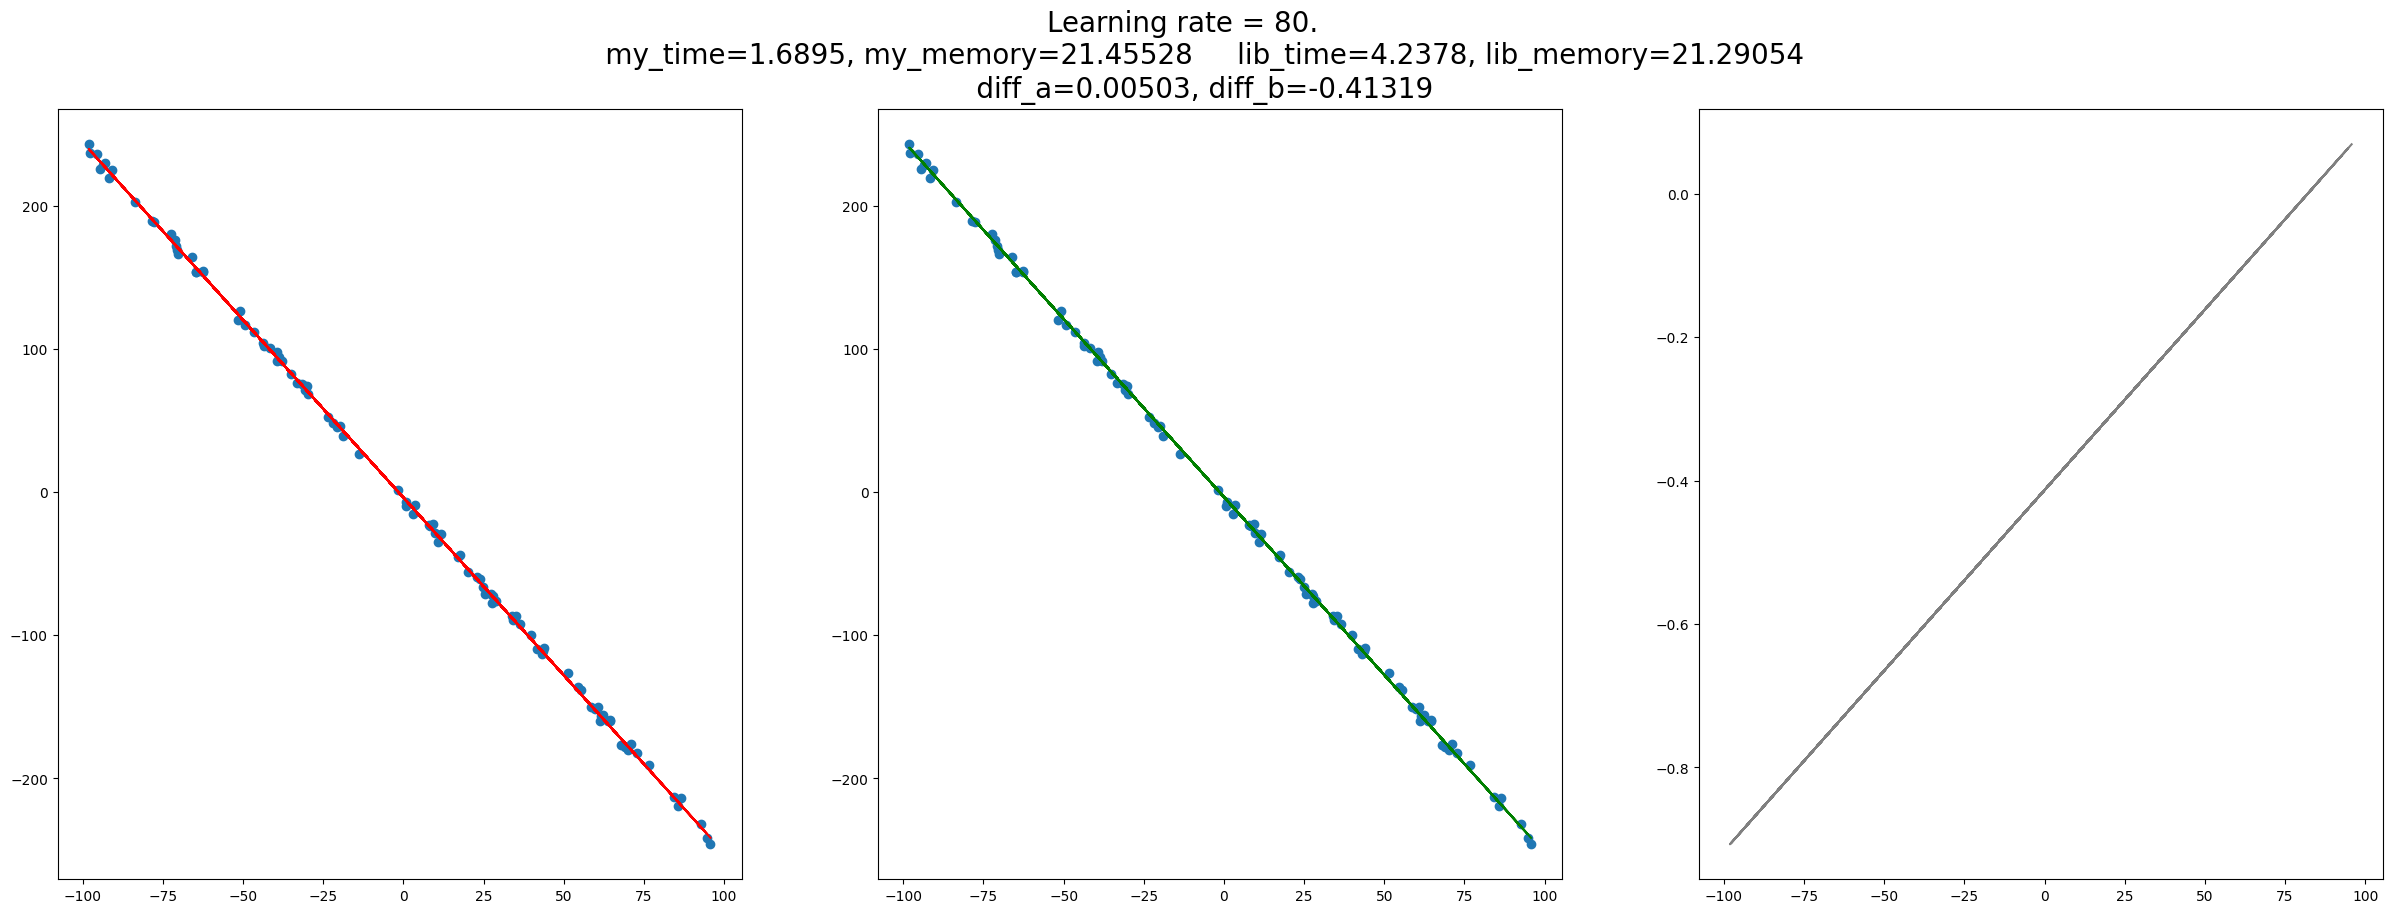

In [ ]:
test_SGD(MY_CTORS[3], LIB_CTORS[3], NAMES[3], lr=LRS[3])

## Выводы

$|diff_a| < 0.006$, $|diff_b| < 0.42$

Наш метод отработал по времени быстрее в 2.5 раза

По памяти оба метода показали себя примерно одинаково


# RMSProp

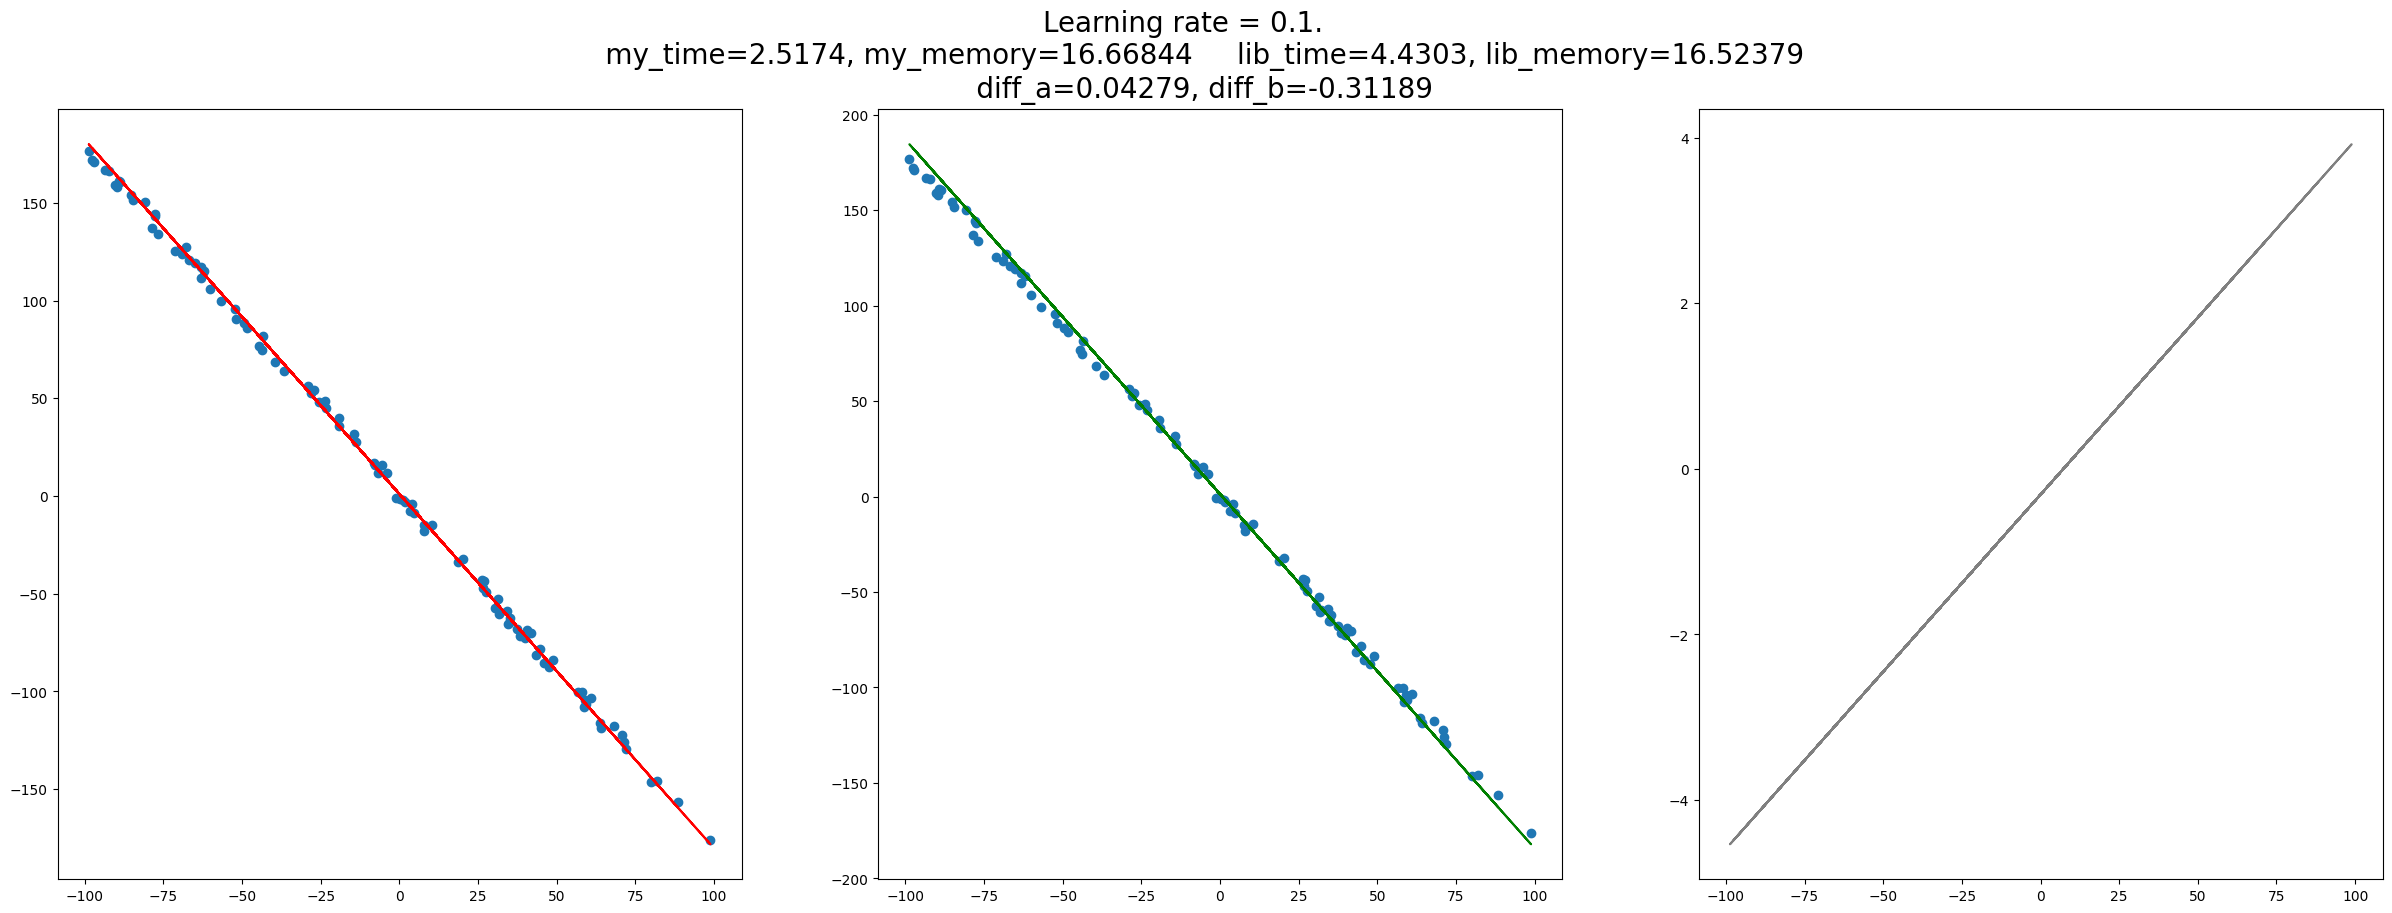

In [ ]:
test_SGD(MY_CTORS[4], LIB_CTORS[4], NAMES[4], lr=LRS[4])

## Выводы

$|diff_a| < 0.05$, $|diff_b| < 0.4$

Наш метод отработал по времени быстрее в 1.8 раза

По памяти оба метода показали себя примерно одинаково


# Adam

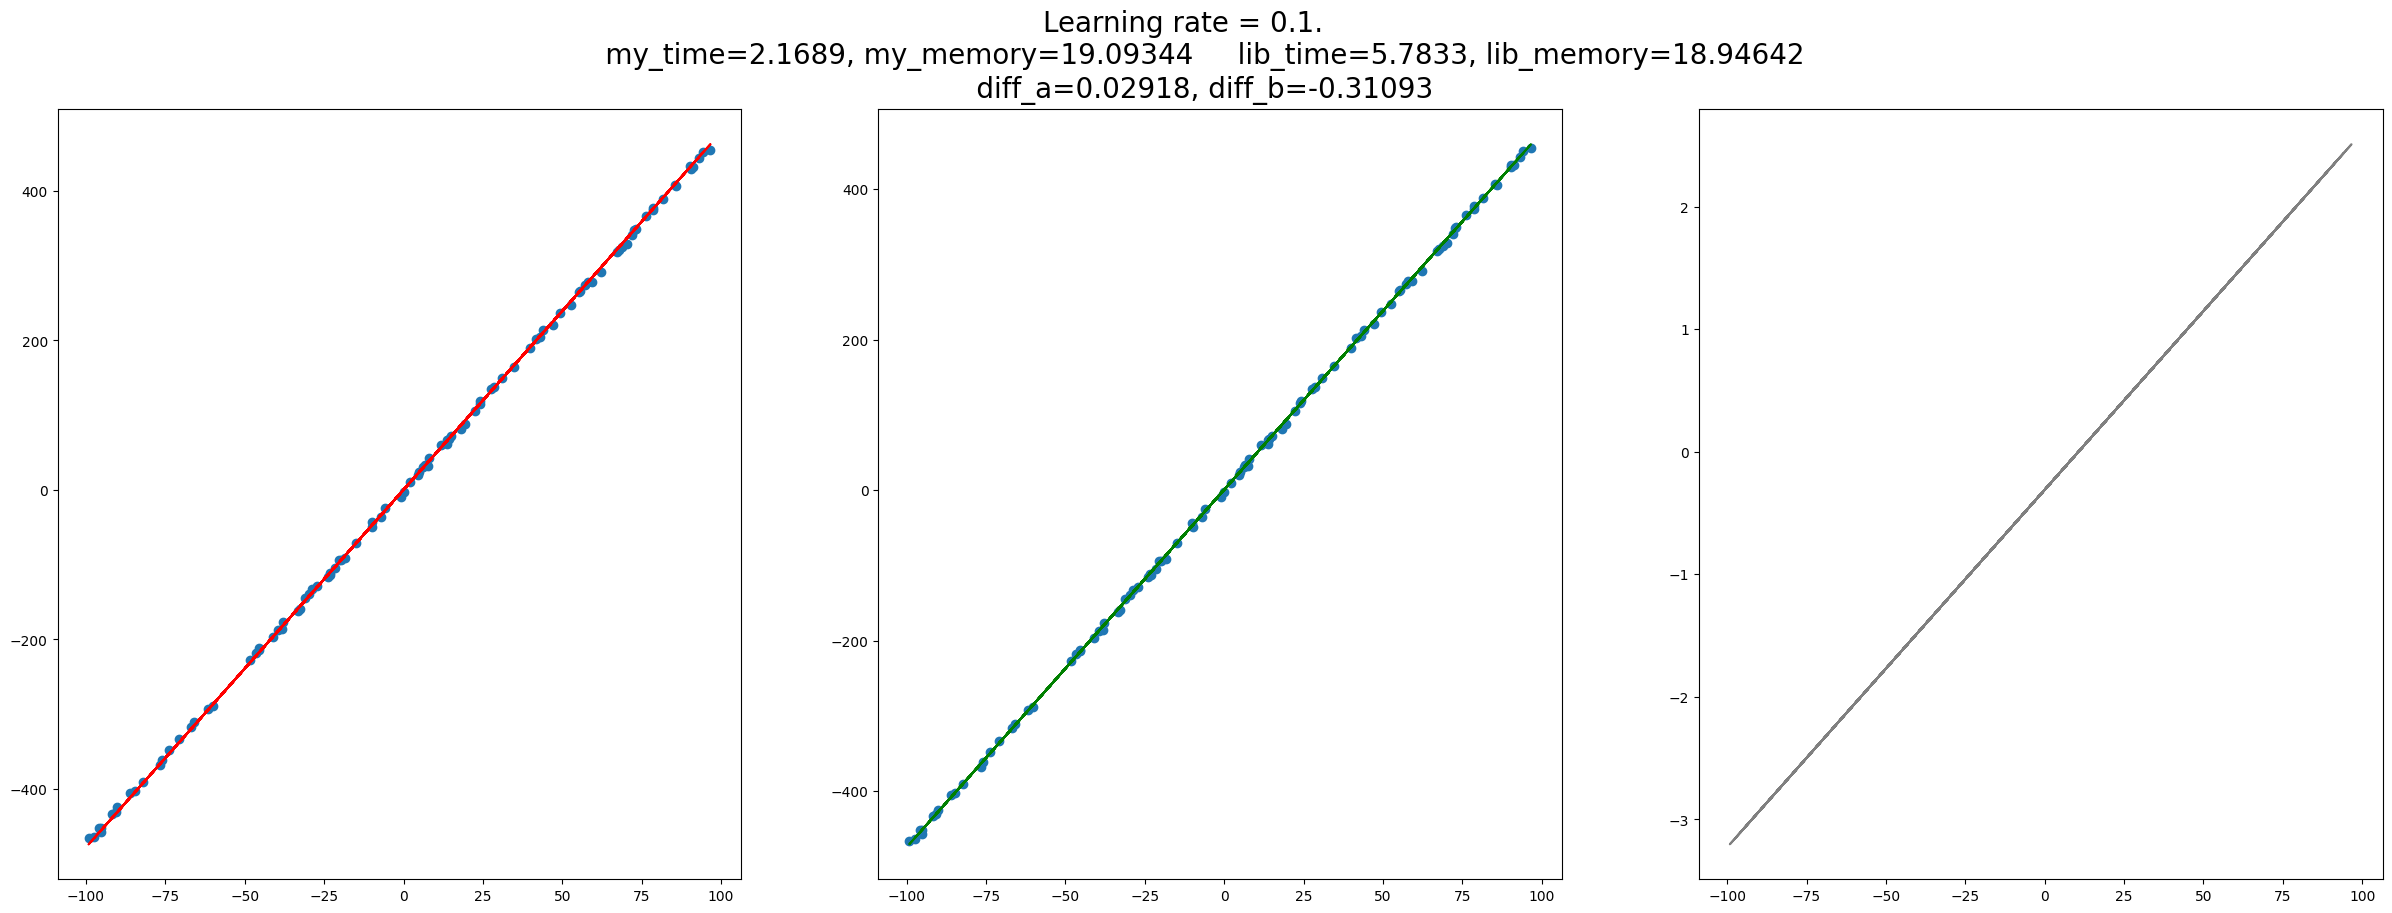

In [ ]:
test_SGD(MY_CTORS[5], LIB_CTORS[5], NAMES[5], lr=LRS[5])

## Выводы

$|diff_a| < 0.03$, $|diff_b| < 0.32$

Наш метод отработал по времени быстрее в 2.4 раза

По памяти оба метода показали себя примерно одинаково


# Общие выводы по первой части

Во всех случаях и наш, и библиотечный алгоритм сходятся довольно хорошо и почти одинаково (разница в коэффициентах везде мала)

Во всех случаях наша реализация работает быстрее по времени

По памяти ресурсозатратность обоих алгоритмов примерно одинакова (с небольшим преимуществом за библиотечными алгоритмами)

# 2. Изучить использование готовых методов оптимизации из SciPy (scipy.optimize.minimize, scipy.optimize.least_squares)
  

## 2.1. Исследовать эффективность и сравнить с собственными реализациями из 3 работы.

In [ ]:
import math
from matplotlib import projections
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

Gauss-Newton

In [ ]:
def poly_reg(dim):
    return lambda w, x: sum([w[i] * x**i for i in range(dim)])


def rloss(f, x, y):
    return lambda w: np.array([(f(w, x[i]) - y[i]) for i in range(x.size)])


def diff(f, w, i, x, dx=1e-4):
    dw = np.zeros(w.size)
    dw[i] = dx
    return (f(w + dw, x) - f(w - dw, x)) / (2 * dx)


def J(f, x):
    return lambda w: np.array(
        [np.array([diff(f, w, j, x[i]) for j in range(w.size)]) for i in range(x.size)]
    )


def GN(w, x, y, reg, epoch=100, min_step=1e-5):
    r = rloss(reg, x, y)
    jac = J(reg, x)
    for i in range(epoch):
        p = -np.linalg.pinv(jac(w).T @ jac(w)) @ jac(w).T @ r(w)
        if np.linalg.norm(p) < min_step:
            return w, i
        w = w + p
    return w, epoch

Powell Dog Leg

In [ ]:
def rloss_sq(f, x: np.array, y: np.array):
    return lambda w: 1 / 2 * sum([(f(w, x[i]) - y[i]) ** 2 for i in range(x.size)])


def deriv(f, w, i, h=1e-4):
    dw = np.zeros(w.size)
    dw[i] = h
    return (f(w + dw) - f(w - dw)) / (2 * h)


def J_2(f, dim: int):
    return lambda w: np.array([deriv(f, w, i) for i in range(dim)])


def sec_deriv(f, w, i, j, h=1e-4):
    dw1 = np.zeros(w.size)
    dw1[i] = h
    dw2 = np.zeros(w.size)
    dw2[j] = h
    return (
        f(w + dw1 + dw2) - f(w - dw1 + dw2) - f(w + dw1 - dw2) + f(w - dw1 - dw2)
    ) / (4 * h * h)


def H(f, dim):
    def hessian(w):
        h = np.zeros((dim, dim))
        for i in range(dim):
            for j in range(i + 1, dim):
                h[i][j] = sec_deriv(f, w, i, j)
        h = h + h.T
        for i in range(dim):
            h[i][i] = sec_deriv(f, w, i, i)
        return h

    return hessian


def PDL(
    w, x, y, reg, trust_region=1.0, max_trust_region=100.0, min_step=1e-4, epoch=300
):
    rlss = rloss_sq(reg, x, y)
    jac = J_2(rlss, w.size)
    hes = H(rlss, w.size)
    for i in range(epoch):
        g = jac(w)
        B = hes(w)
        pN = -np.linalg.pinv(B) @ g
        if np.linalg.norm(pN) <= trust_region:
            p = pN
        else:
            pGD = -((g @ g) / (g @ (B @ g))) * g
            norm_pGD = np.linalg.norm(pGD)
            if norm_pGD >= trust_region:
                p = trust_region * pGD / norm_pGD
            else:
                dp = pN - pGD
                tau = -((pGD - trust_region) @ dp) / (dp @ dp)
                p = pGD + tau * dp
            cooef = (rlss(w) - rlss(w + p)) / (-(g @ p + 0.5 * p @ (B @ p)) + (1e-8))
            norm_p = np.linalg.norm(p)
            if cooef < 0.25:
                trust_region = 0.25 * norm_p
            elif cooef > 0.75 and norm_p == trust_region:
                trust_region = min(2.0 * trust_region, max_trust_region)
            if cooef > 0.20:
                w = w + p
                if np.linalg.norm(g) < min_step:
                    return w, i
    return w, epoch


Test 1

[ 0.4999042   3.03034585 -1.00660914] 5
regGN time: 0.1070702075958252
regGN memory: 26119787
[0.2585188  4.19630151 1.26945813] 300
regPDL time: 7.677145481109619
regPDL memory: 26202502
[-0.42340918  0.7         0.7       ]
least_squares time: 0.0696711540222168
least_squares memory: 26158801


<function matplotlib.pyplot.show(close=None, block=None)>

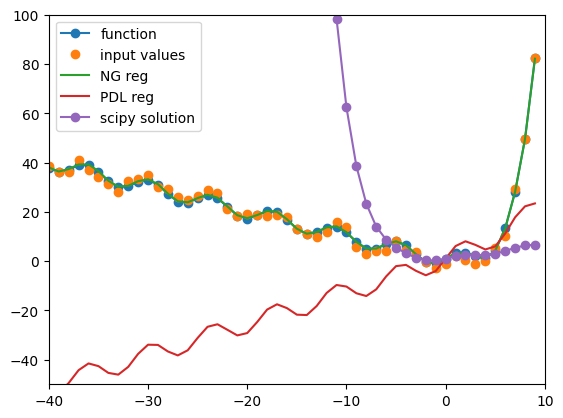

In [ ]:

f1 = lambda x: np.exp(x / 2) + 3 * np.sin(x) - x
regf1 = lambda w, x: np.exp(w[0] * x) + w[1] * np.sin(x) + w[2] * x
f2 = lambda x: x**2 - 3 * x + 4


def get_funct_val(f, lbound, rbound, d):
    x = np.arange(lbound, rbound)
    x = x
    y = f(x)
    y_with_noise = y + (np.random.randint(2 * d, size=rbound - lbound) - d)
    return x, y, y_with_noise


x, y, val = get_funct_val(f1, -40, 10, 3)

plt.axis((-40, 10, -50, 100))
plt.plot(x, y, "o-", label="function")
plt.plot(x, val, "o", label="input values")

t = time()
tracemalloc.reset_peak()
regGN = regf1
ans, ep = GN(np.array([0.7, 0.7, 0.7]), x, val, regGN)
regGN_time = time() - t
_, regGN_memory = tracemalloc.get_traced_memory()
print(ans, ep)
print("regGN time:", regGN_time)
print("regGN memory:", regGN_memory)
yval = regGN(ans, x)
plt.plot(x, yval, "-", label="NG reg")

tracemalloc.reset_peak()
t = time()
regPDL = regf1
ans, ep = PDL(np.array([0.7, 0.7, 0.7]), x, val, regPDL)
regPDL_time = time() - t
_, regPDL_memory = tracemalloc.get_traced_memory()
print(ans, ep)
print("regPDL time:", regPDL_time)
print("regPDL memory:", regPDL_memory)
yval = regPDL(ans, x)
plt.plot(x, yval, "-", label="PDL reg")

from scipy.optimize import least_squares
t = time()
tracemalloc.reset_peak()
fun = lambda x: np.exp(x[0] / 2) + 3 * np.sin(x[0]) - x[0]
result = least_squares(fun, np.array([0.7, 0.7, 0.7]), bounds=(-40, 10))
solution = result.x
yVal= regf1(solution, x)
regLS_time = time() - t
_, regLS_memory = tracemalloc.get_traced_memory()
print(solution)
print("least_squares time:", regLS_time)
print("least_squares memory:", regLS_memory)
plt.plot(x, yVal, '-o', label='scipy solution')

plt.legend()
plt.show

Test 2

[ 7.72017698 -2.74303038  0.99202588] 1
regGN time: 0.056574344635009766
regGN memory: 27100318
[ 6.88273328 -2.29333338  0.99397216] 300
regPDL time: 12.403290510177612
regPDL memory: 27179583
[1.50000614 1.         1.        ]
least_squares time: 0.027390003204345703
least_squares memory: 27123985


<function matplotlib.pyplot.show(close=None, block=None)>

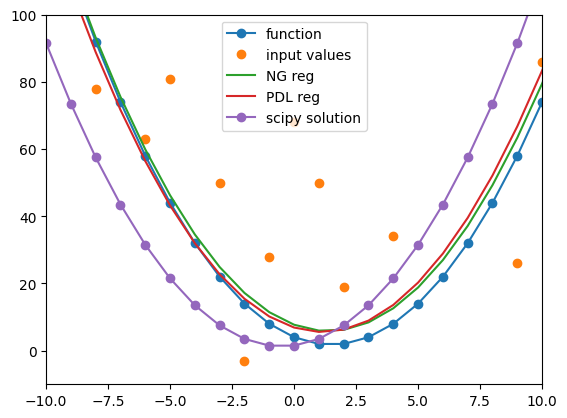

In [ ]:
x, y, val = get_funct_val(f2, -40, 40, 100)

plt.axis((-10, 10, -10, 100))
plt.plot(x, y, "o-", label="function")
plt.plot(x, val, "o", label="input values")


t = time()
tracemalloc.reset_peak()
regGN = poly_reg(3)
ans, ep = GN(np.array([1, 1, 1]), x, val, regGN)


regGN_time = time() - t
_, regGN_memory = tracemalloc.get_traced_memory()
print(ans, ep)
print("regGN time:", regGN_time)
print("regGN memory:", regGN_memory)
yval = regGN(ans, x)
plt.plot(x, yval, "-", label="NG reg")


t = time()
tracemalloc.reset_peak()
regPDL = poly_reg(3)
ans, ep = PDL(np.array([1, 1, 1]), x, val, regPDL)
regPDL_time = time() - t
_, regPDL_memory = tracemalloc.get_traced_memory()
print(ans, ep)
print("regPDL time:", regPDL_time)
print("regPDL memory:", regPDL_memory)
yval = regPDL(ans, x)
plt.plot(x, yval, "-", label="PDL reg")


t = time()
tracemalloc.reset_peak()
fun = lambda x: x[0]**2 - 3 * x[0] + 4
result = least_squares(fun, np.array([1, 1, 1]), bounds=(-40, 40))
solution = result.x
yVal= poly_reg(3)(solution, x)
regLS_time = time() - t
_, regLS_memory = tracemalloc.get_traced_memory()
print(solution)
print("least_squares time:", regLS_time)
print("least_squares memory:", regLS_memory)
plt.plot(x, yVal, '-o', label='scipy solution')

plt.legend()
plt.show

Boundry change


[ 8.49960151 -4.16865035  0.94548467] 1
regGN time: 0.06689143180847168
regGN memory: 31074496
[ 7.72833559 -3.86069572  0.94906891] 300
regPDL time: 12.66383981704712
regPDL memory: 31156474
[1.50000614 1.         1.        ]
least_squares time: 0.01798868179321289
least_squares memory: 31098060


<function matplotlib.pyplot.show(close=None, block=None)>

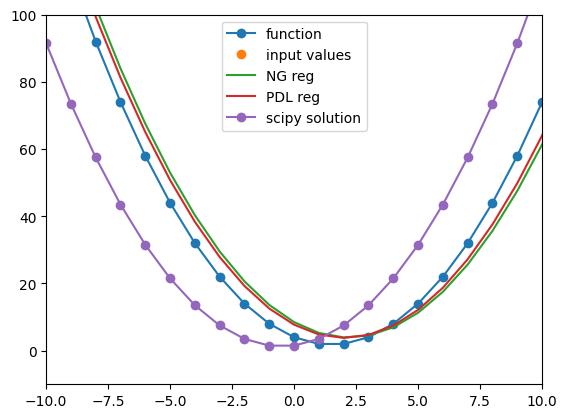

In [ ]:
x, y, val = get_funct_val(f2, -40, 40, 1000)

plt.axis((-10, 10, -10, 100))
plt.plot(x, y, "o-", label="function")
plt.plot(x, val, "o", label="input values")


t = time()
tracemalloc.reset_peak()
regGN = poly_reg(3)
ans, ep = GN(np.array([1, 1, 1]), x, val, regGN)
regGN_time = time() - t
_, regGN_memory = tracemalloc.get_traced_memory()
print(ans, ep)
print("regGN time:", regGN_time)
print("regGN memory:", regGN_memory)
yval = regGN(ans, x)
plt.plot(x, yval, "-", label="NG reg")

t = time()
tracemalloc.reset_peak()
regPDL = poly_reg(3)
ans, ep = PDL(np.array([1, 1, 1]), x, val, regPDL)
regPDL_time = time() - t
_, regPDL_memory = tracemalloc.get_traced_memory()
print(ans, ep)
print("regPDL time:", regPDL_time)
print("regPDL memory:", regPDL_memory)
yval = regPDL(ans, x)
plt.plot(x, yval, "-", label="PDL reg")

t = time()
tracemalloc.reset_peak()
fun = lambda x: x[0]**2 - 3 * x[0] + 4
result = least_squares(fun, np.array([1, 1, 1]), bounds=(-40, 40))
solution = result.x
yVal= poly_reg(3)(solution, x)
regLS_time = time() - t
_, regLS_memory = tracemalloc.get_traced_memory()
print(solution)
print("least_squares time:", regLS_time)
print("least_squares memory:", regLS_memory)
plt.plot(x, yVal, '-o', label='scipy solution')

plt.legend()
plt.show



# Выводы по сравнению

По сравнению с методами из второй лабораторной работе, тут всё наоборот: наши методы работают сильно дольше (особенно PDL, который, почему-то, работает очень-очень долго), по памяти же все методы примерно одинаковы (наши даже немного выигрывают)

## 2.2 Реализовать использование PyTorch для вычисления градиента и сравнить с другими подходами.


Рассмотрим 4 метода вычисления градиента:
1. $∇f(x)=\frac{f(x+ϵ) - f(x)}{ϵ}$
2. $∇f(x)=\frac{f(x+ϵ) - f(x-ϵ)}{2ϵ}$
3. Аналитическое вычисление производной и подстановка точки
4. С помощью PyTorch


Напишем 3 из 4 функции вычисления градиента, а третью посчитаем вручную для каждой тестовой функции:

In [ ]:
def gradient_one_side(f, x, eps=1e-7):
  res = np.zeros_like(x)
  for i in range(x.shape[0]):
    point = x
    point[i]+=eps
    res[i] = (f(point) - f(x)) / eps
  return res

def gradient_both_sides(f, x, eps=1e-7):
  res = np.zeros_like(x)
  for i in range(x.shape[0]):
    point1 = x
    point2 = x
    point1[i]+=eps
    point2[i]-=eps
    res[i] = (f(point1) - f(point2)) / eps
  return res

def gradient_pytorch(f, x, eps=1e-7):
  x = torch.tensor(x.tolist(), requires_grad=True)
  y = f(x)
  y.backward()
  return x.grad

# Тестовые функции
1. $f(x, y) = x^2 + 2xy + y^2$
2. $f(x, y, z) = 4x^2 + xy + 2yz + 5z^2$
3. $f(x, y) = 3\sin{x} + \cos{2xy}$

In [ ]:
def f_1(x):
  return x[0]**2 + 2*x[0]*x[1] + x[1]**2

def f_2(x):
  return 4*x[0]**2 + x[0]*x[1] + 2*x[1]*x[2] + 5*x[2]**2

def f_3(x):
  return (x[0] - 2*x[1]) ** 2 + 2*x[0]*x[1]

Посчитаем аналитически все производные:

In [ ]:
def g_1(x):
  return np.array([2 * x[0] + 2 * x[1], \
                   2 * x[0] + 2 * x[1]])

def g_2(x):
  return np.array([8 * x[0] + x[1],
                   x[0] + 2 * x[2],
                   2 * x[1] + 10 * x[2]])

def g_3(x):
  return np.array([2 * (x[0] - 2 * x[1]) + 2 * x[1],
                  -4 * (x[0] - 2* x[1])  + 2 * x[0]])

In [ ]:
from time import time
import pandas as pd

Добавим код для сравнения:

In [ ]:
METHODS_GRADIENT = [gradient_one_side, gradient_both_sides, gradient_pytorch]
METHODS_GRADIENT_NAMES = ['gradient_one_side', 'gradient_both_sides', 'gradient_pytorch']

def test_gradient_point(function, gradient, points):
  df = pd.DataFrame(columns=["time", "max diff", "average diff", "sum diff"])
  t = time()
  real_grads = np.array(list(map(lambda point: gradient(point), points)))
  # print(real_grads.shape)
  real_grads_time = time() - t
  df.loc['real_gradient'] = {'time': real_grads_time, 'max diff': 0.0, 'average diff': 0.0, 'sum diff': 0.0}

  for method, name in zip(METHODS_GRADIENT, METHODS_GRADIENT_NAMES):
    t = time()
    grads = np.array(list(map(lambda point: method(function, point), points)))
    method_time = time() - t

    if(name == 'gradient_pytorch'):
      grads =  np.array(list(map(lambda x : x.numpy(), grads)))

    df.loc[name] = {'time': method_time, 'max diff': np.max(np.abs(grads - real_grads)), 'average diff': np.mean(np.abs(grads - real_grads)), 'sum diff': np.sum(np.abs(grads - real_grads))}

  return df

In [ ]:
POINTS_COUNT = 10_000

In [ ]:
test_gradient_point(f_1, g_1, np.random.rand(POINTS_COUNT, 2))

<ipython-input-613-bf0380950c6a>:14: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  grads = np.array(list(map(lambda point: method(function, point), points)))
<ipython-input-613-bf0380950c6a>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grads = np.array(list(map(lambda point: method(function, point), points)))


,time,max diff,average diff,sum diff
real_gradient,0.155097,0.000000e+00,0.000000e+00,0.000000
gradient_one_side,0.765661,3.972677e+00,2.004023e+00,40080.464072
gradient_both_sides,0.751771,3.972677e+00,2.004023e+00,40080.464072
gradient_pytorch,3.223926,6.384552e-07,4.003091e-07,0.008006


In [ ]:
test_gradient_point(f_2, g_2, np.random.rand(POINTS_COUNT, 3))

<ipython-input-613-bf0380950c6a>:14: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  grads = np.array(list(map(lambda point: method(function, point), points)))
<ipython-input-613-bf0380950c6a>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grads = np.array(list(map(lambda point: method(function, point), points)))


,time,max diff,average diff,sum diff
real_gradient,0.177734,0.000000,0.000000e+00,0.000000
gradient_one_side,1.261505,11.900201,3.958007e+00,118740.210766
gradient_both_sides,1.363959,11.900201,3.958007e+00,118740.210766
gradient_pytorch,5.051946,0.000002,8.003500e-07,0.024010


In [ ]:
test_gradient_point(f_3, g_3, np.random.rand(POINTS_COUNT, 2))

<ipython-input-613-bf0380950c6a>:14: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  grads = np.array(list(map(lambda point: method(function, point), points)))
<ipython-input-613-bf0380950c6a>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grads = np.array(list(map(lambda point: method(function, point), points)))


,time,max diff,average diff,sum diff
real_gradient,0.192883,0.000000,0.000000e+00,0.000000
gradient_one_side,0.605711,7.987110,1.930358e+00,38607.158055
gradient_both_sides,0.865764,7.987110,1.930358e+00,38607.158055
gradient_pytorch,3.092289,0.000001,3.205322e-07,0.006411


# Вывод

По точности оба метода (с одной стороны и с двух сторон) в среднем одинаковые.

По скорости, вполне логично, метод подсчёта градиента с одной стороны лидирует.

По точности же лучше всего оказался pyTorch, хотя по скорости он сильно (в 3-5 раз) отстаёт от наших методов.

# 3. Исследовать как задание границ изменения параметров влияет на работу методов из SciPy.

In [ ]:
def function_minimum_inside(x):
  return (x[0] - 7)**2 + (x[1] - 7)**2

In [ ]:
from matplotlib.patches import Rectangle, Circle
import numpy as np
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import minimize

In [ ]:
def plot_graphic(axs, func, points, x_bound, y_bound, title):
  xs = np.linspace(-5, 15, 100)
  ys = np.linspace(-5, 15, 100)
  X, Y = np.meshgrid(xs, ys)
  points = np.array(points)
  axs.contourf(X, Y, func([X, Y]))

  axs.plot(points[:, 0], points[:, 1], 'o-', color='yellow')
  axs.add_patch(Rectangle((x_bound[0], y_bound[0]), x_bound[1]-x_bound[0], y_bound[1]-y_bound[0],
                            facecolor='red',
                            fill=True,
                            alpha=0.2,
                            lw=5))
  axs.set_title(title)


In [ ]:
def test(func, method, x_bound, y_bound, x0 = np.array([8, 6])):
    points = [x0]
    def callback(xk, state=None):
        points.append(xk)
        return False

    res_with_bound = minimize(func, x0, method=method, callback=callback, bounds=(x_bound, y_bound))
    with_bound_points = points.copy()

    points = [x0]
    res = minimize(func, x0, method=method, callback=callback)

    fig, axs = plt.subplots(1, 2, figsize=(18, 10))
    plot_graphic(axs[0], func, with_bound_points, x_bound, y_bound, 'with bounds')
    plot_graphic(axs[1], func, points, x_bound, y_bound, 'without bounds')
    print(res)

In [ ]:
def cv_func(x):
  return x[0]**2 + x[1]**2

# Минимум внутри границы

          message: `gtol` termination condition is satisfied.
          success: True
           status: 1
              fun: 5.441459082312369e-15
                x: [ 7.000e+00  7.000e+00]
              nit: 3
             nfev: 9
             njev: 3
             nhev: 0
         cg_niter: 2
     cg_stop_cond: 4
             grad: [-5.920e-11  3.303e-11]
  lagrangian_grad: [-5.920e-11  3.303e-11]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 5.920330892195125e-11
 constr_violation: 0
   execution_time: 0.05446767807006836
        tr_radius: 2.899494936839935
   constr_penalty: 1.0
            niter: 3


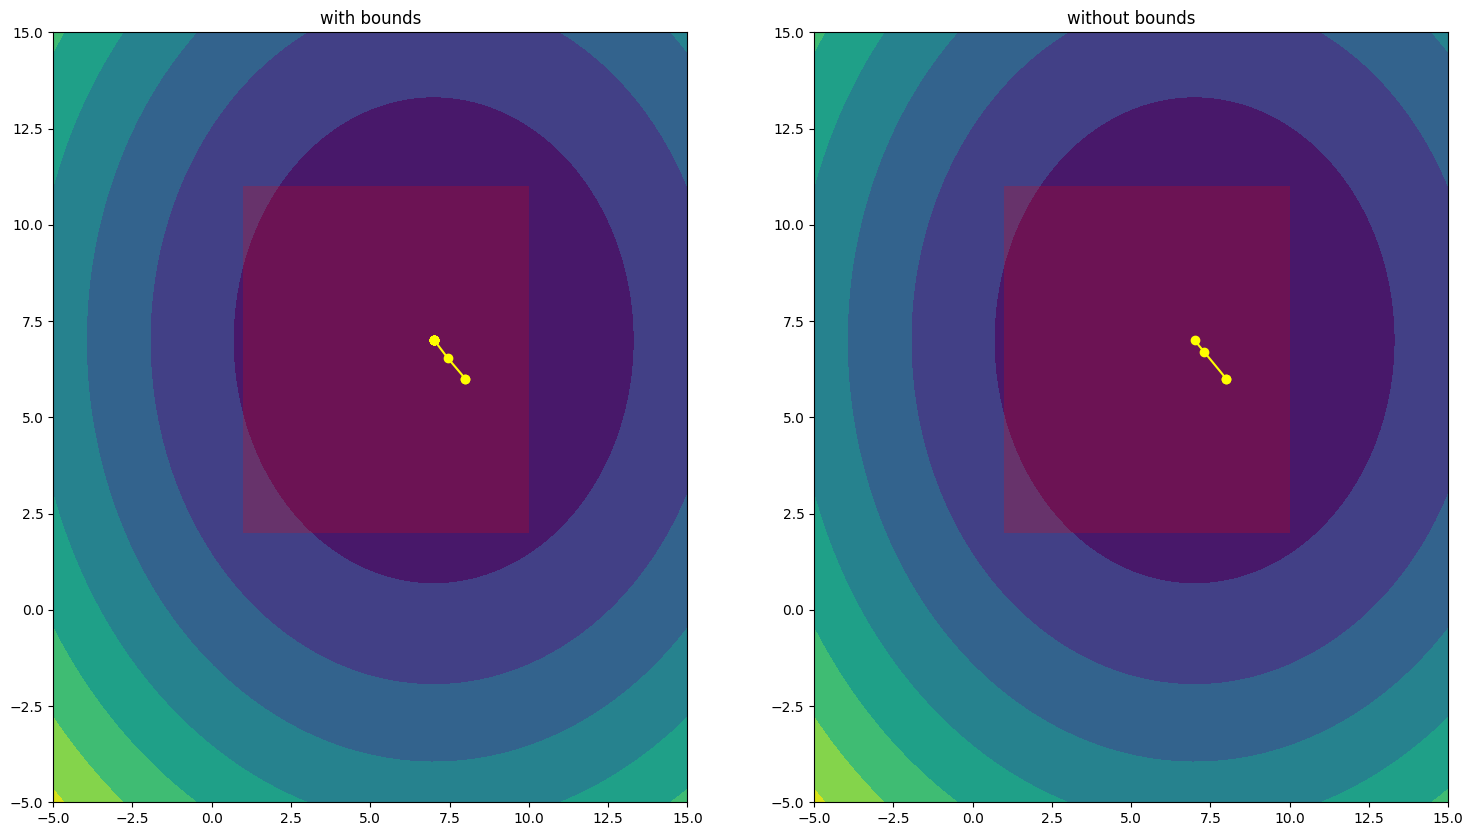

In [ ]:
test(function_minimum_inside, 'trust-constr', (1, 10), (2, 11))

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 1.8091944193036224e-09
       x: [ 7.000e+00  7.000e+00]
    nfev: 44
   maxcv: 0.0


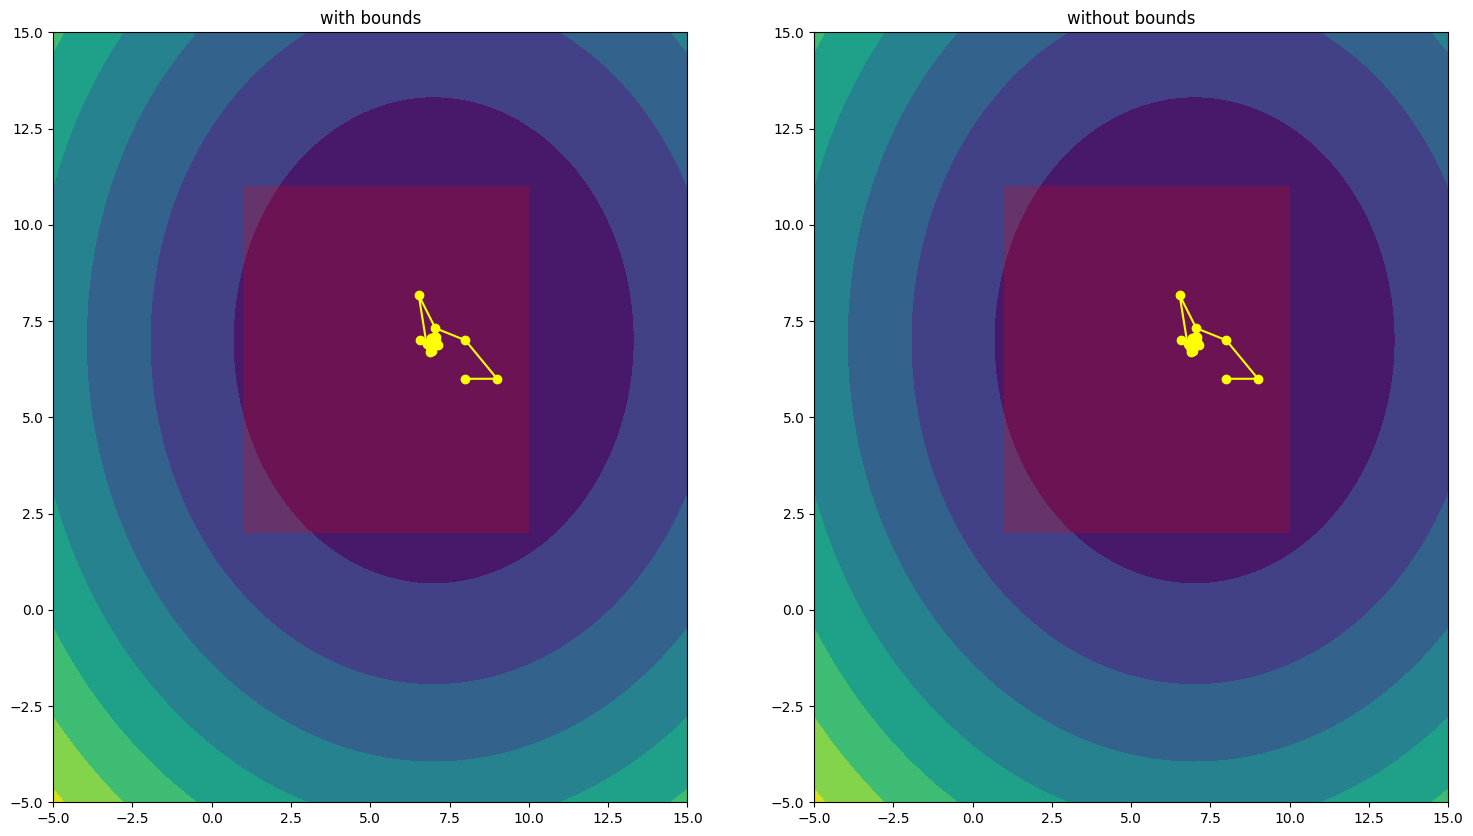

In [ ]:
test(function_minimum_inside, 'COBYLA', (1, 10), (2, 11))

# Минимум за границей

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: 2.6746486875866453e-18
                x: [ 3.884e-10 -1.589e-09]
              nit: 16
             nfev: 48
             njev: 16
             nhev: 0
         cg_niter: 19
     cg_stop_cond: 4
             grad: [ 1.568e-08 -1.808e-08]
  lagrangian_grad: [ 1.568e-08 -1.808e-08]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 1.807844576473458e-08
 constr_violation: 0
   execution_time: 0.27341222763061523
        tr_radius: 8.27680536135088e-09
   constr_penalty: 1.0
            niter: 16


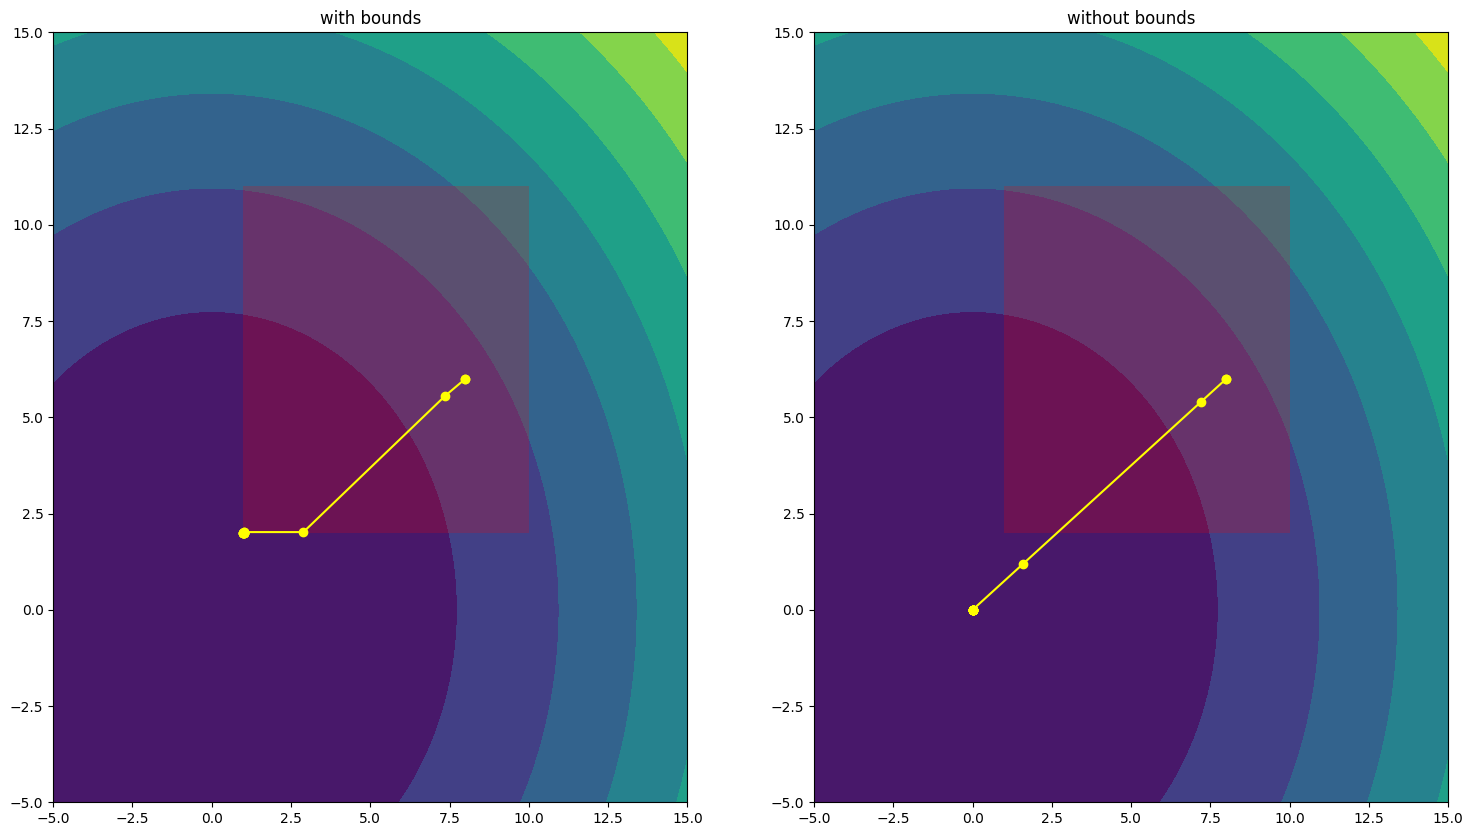

In [ ]:
test(cv_func, 'trust-constr', (1, 10), (2, 11))

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: -1.1102230246251565e-16
                x: [ 1.000e+00 -1.000e+00]
              nit: 22
             nfev: 60
             njev: 20
             nhev: 0
         cg_niter: 29
     cg_stop_cond: 2
             grad: [ 2.235e-08 -2.235e-08]
  lagrangian_grad: [ 2.235e-08 -2.235e-08]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 2.2351741790771484e-08
 constr_violation: 0
   execution_time: 0.15982580184936523
        tr_radius: 9.570312500000003e-09
   constr_penalty: 1.0
            niter: 22


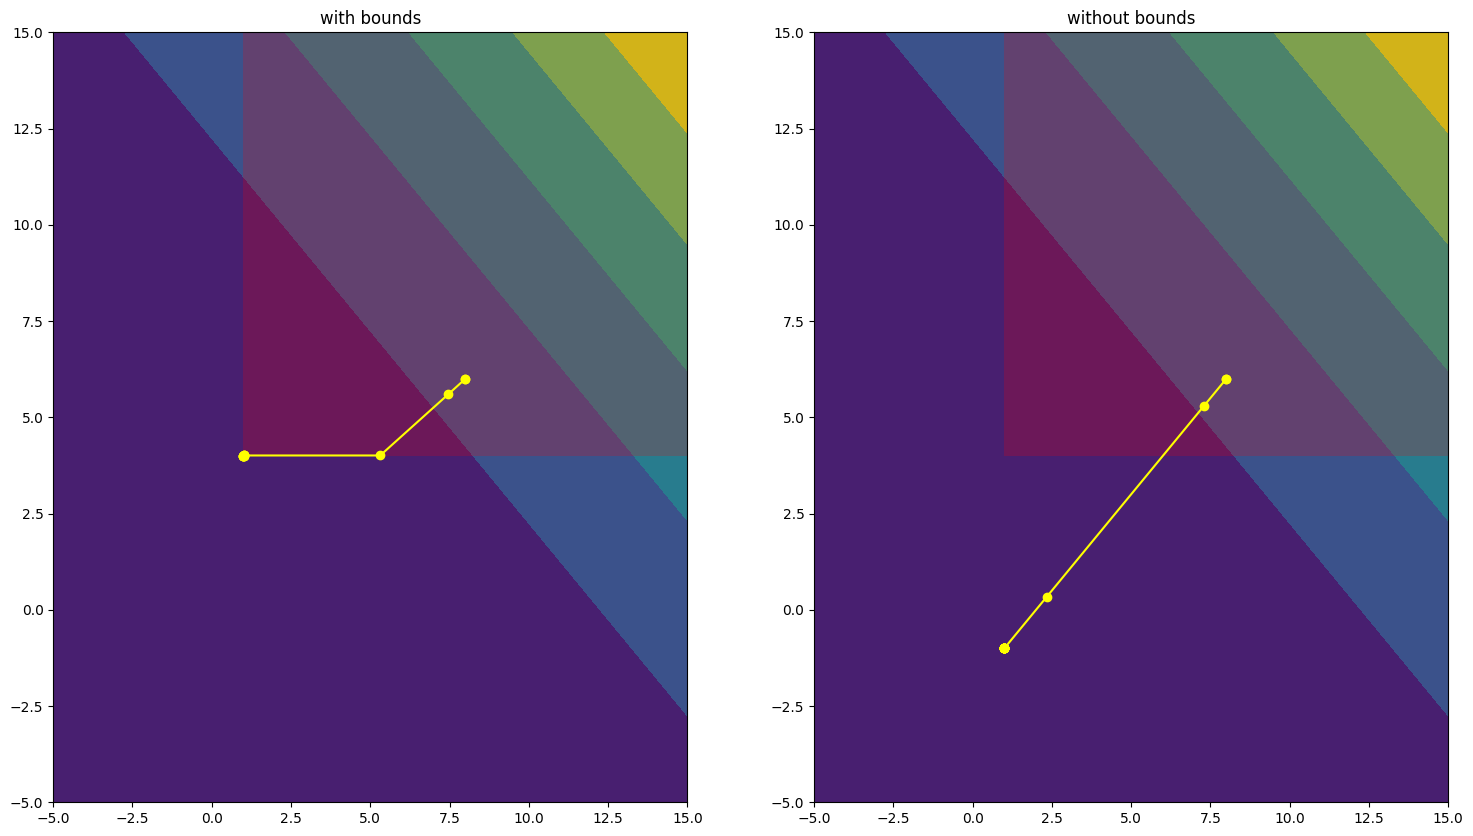

In [ ]:
test(f_1, 'trust-constr', (1, 15), (4, 15))

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 4.08232745385817e-08
       x: [ 2.306e+00 -2.306e+00]
    nfev: 46
   maxcv: 0.0


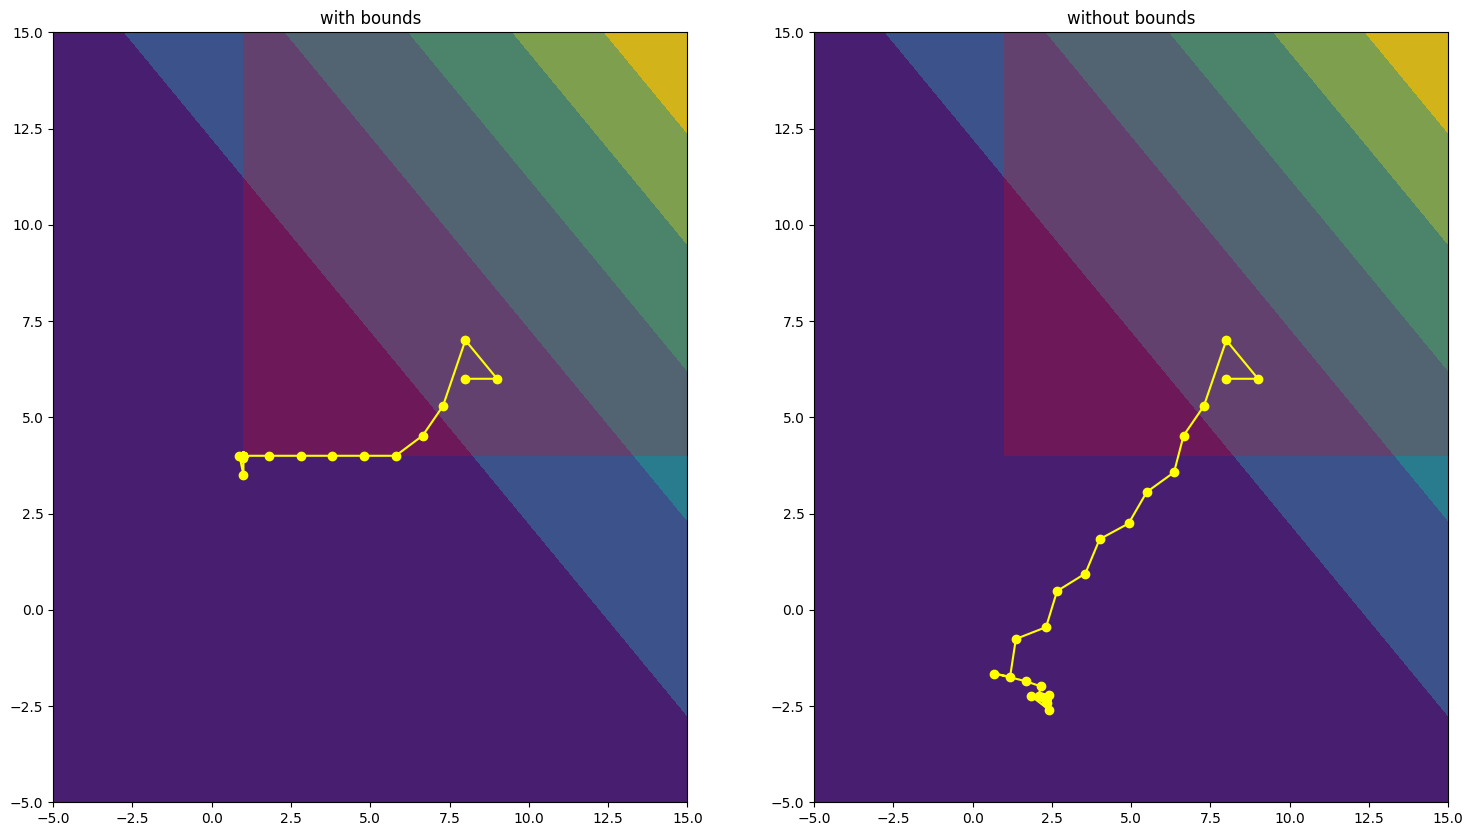

In [ ]:
test(f_1, 'COBYLA', (1, 15), (4, 15))

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: 5.025979955659424e-18
                x: [-2.527e-09 -8.756e-10]
              nit: 30
             nfev: 90
             njev: 30
             nhev: 0
         cg_niter: 46
     cg_stop_cond: 2
             grad: [-1.820e-08 -6.156e-08]
  lagrangian_grad: [-1.820e-08 -6.156e-08]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 6.155633152503282e-08
 constr_violation: 0
   execution_time: 0.23891258239746094
        tr_radius: 5.069857293899029e-09
   constr_penalty: 1.0
            niter: 30


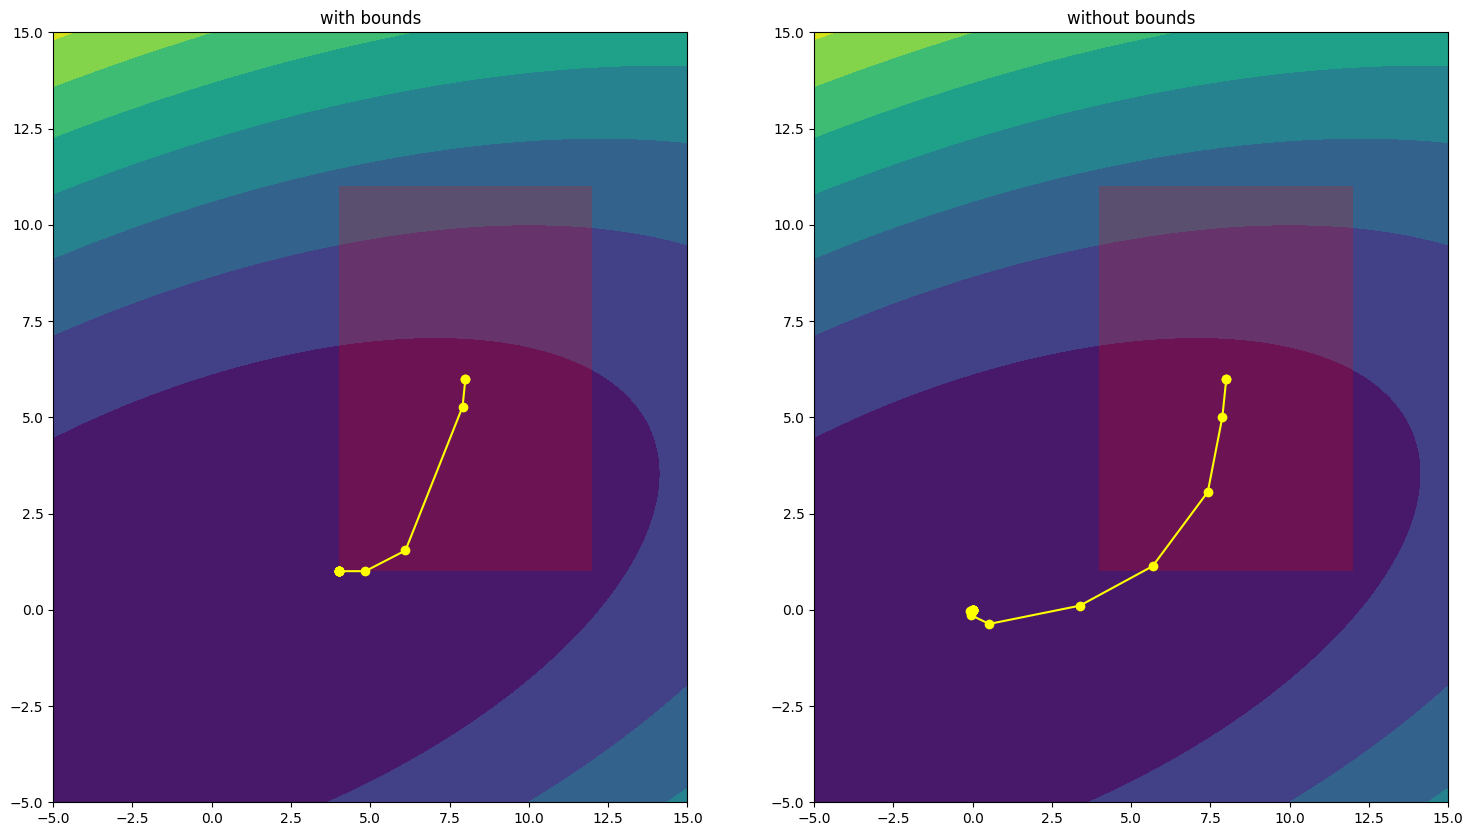

In [ ]:
test(f_3, 'trust-constr' , (4, 12), (1, 11))

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 1.317598880737595e-08
       x: [ 3.919e-06  5.835e-05]
    nfev: 62
   maxcv: 0.0


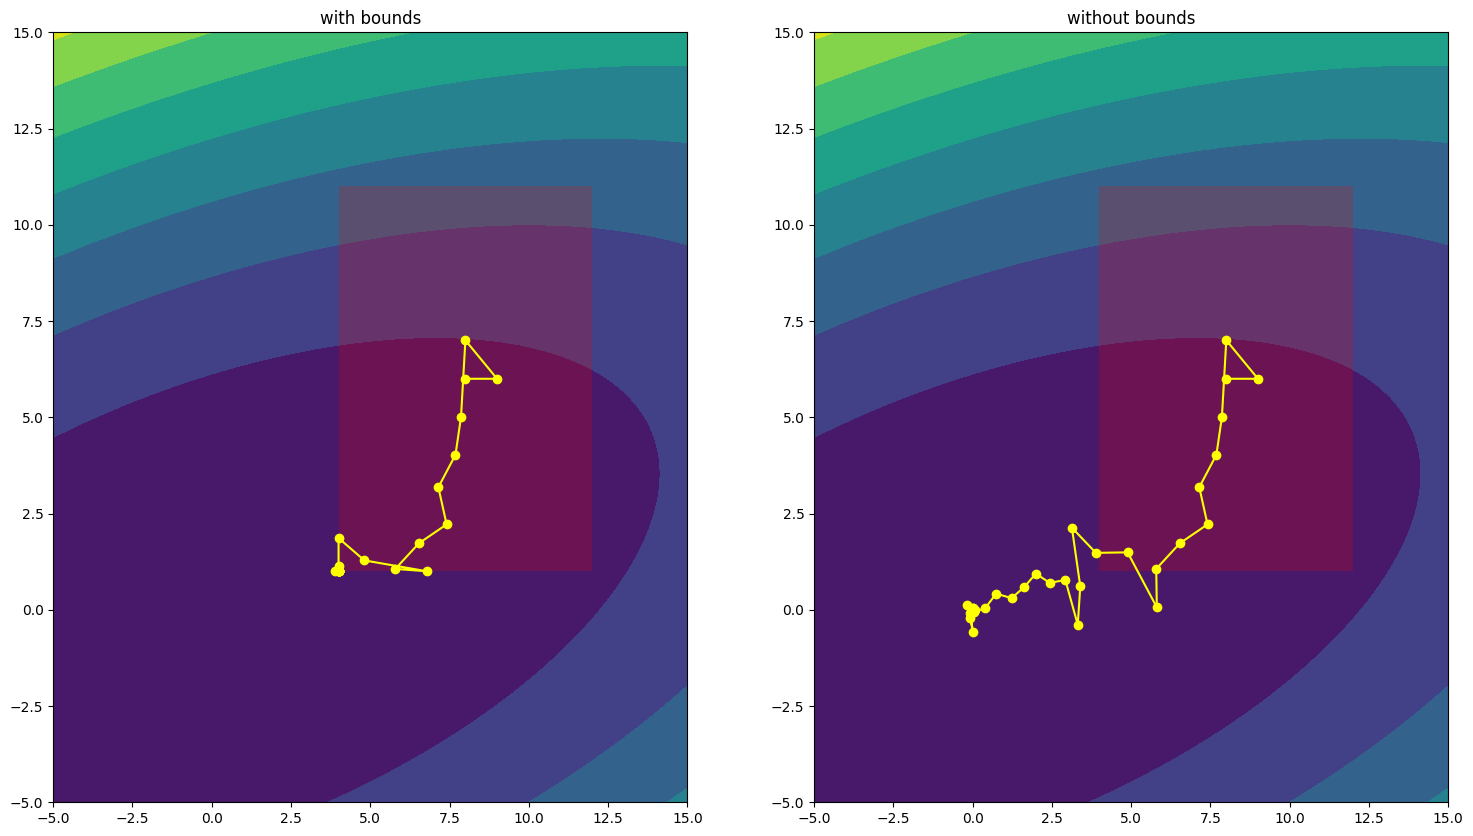

In [ ]:
test(f_3, 'COBYLA', (4, 12), (1, 11))

## Бонус
Исследовать использование линейных и нелинейных ограничений scipy.optimize.minimize из SciPy

In [ ]:
a = 3
b = 4
lower = 20
upper = 100

linear_constraint = LinearConstraint ([[3, 4], [4, -3]], [20, 20], [100, 100])

In [ ]:
def draw_constraint(axs, xs, ys):
  res = np.array([(x, y) for x, y in zip(xs, ys) if -5<=x<=15 and-5<=y<=15])
  if res.shape[0]!=0:
    axs.plot(res[:, 0], res[:, 1], color='red')


def plot_graphic_bonus(axs, func, points, title, constraints = None):
  xs = np.linspace(-5, 15, 100)
  ys = np.linspace(-5, 15, 100)
  X, Y = np.meshgrid(xs, ys)
  points = np.array(points)

  axs.contourf(X, Y, func([X, Y]))
  axs.plot(points[:, 0], points[:, 1], 'o-', color='yellow')

  axs.set_title(title)
  if constraints is None:
    # ax + by = lower <-> y = (lower - ax) / b
    # ax + by = upper <-> y = (upper - ax) / b
    draw_constraint(axs, xs, (lower - a * xs)/b)
    draw_constraint(axs, xs, (upper - a * xs)/b)

    # bx - ay = lower <-> y = (lower + bx) / a
    # bx - ay = upper <-> y = (upper + bx) / a

    draw_constraint(axs, xs, (lower + b * xs)/a)
    draw_constraint(axs, xs, (upper + b * xs)/a)
  else:
    axs.add_patch(Circle((8, 6), 5,
                            facecolor='red',
                            fill=True,
                            alpha=0.2,
                            lw=5))


def test_bonus(func, method, constraints, nonlinear_constraint = None, x0 = np.array([8, 6])):
    points = [x0]
    def callback(xk, state=None):
        points.append(xk)
        return False

    res_with_bound = minimize(func, x0, method=method, callback=callback, constraints=constraints)
    with_bound_points = points.copy()

    points = [x0]
    res = minimize(func, x0, method=method, callback=callback)

    fig, axs = plt.subplots(1, 2, figsize=(30, 14))
    plot_graphic_bonus(axs[0], func, with_bound_points, 'with constraints', nonlinear_constraint)
    plot_graphic_bonus(axs[1], func, points, 'without constraints', nonlinear_constraint)
    print(res)


# Минимум внутри linear constraint

          message: `gtol` termination condition is satisfied.
          success: True
           status: 1
              fun: 5.441459082312369e-15
                x: [ 7.000e+00  7.000e+00]
              nit: 3
             nfev: 9
             njev: 3
             nhev: 0
         cg_niter: 2
     cg_stop_cond: 4
             grad: [-5.920e-11  3.303e-11]
  lagrangian_grad: [-5.920e-11  3.303e-11]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 5.920330892195125e-11
 constr_violation: 0
   execution_time: 0.03670477867126465
        tr_radius: 2.899494936839935
   constr_penalty: 1.0
            niter: 3


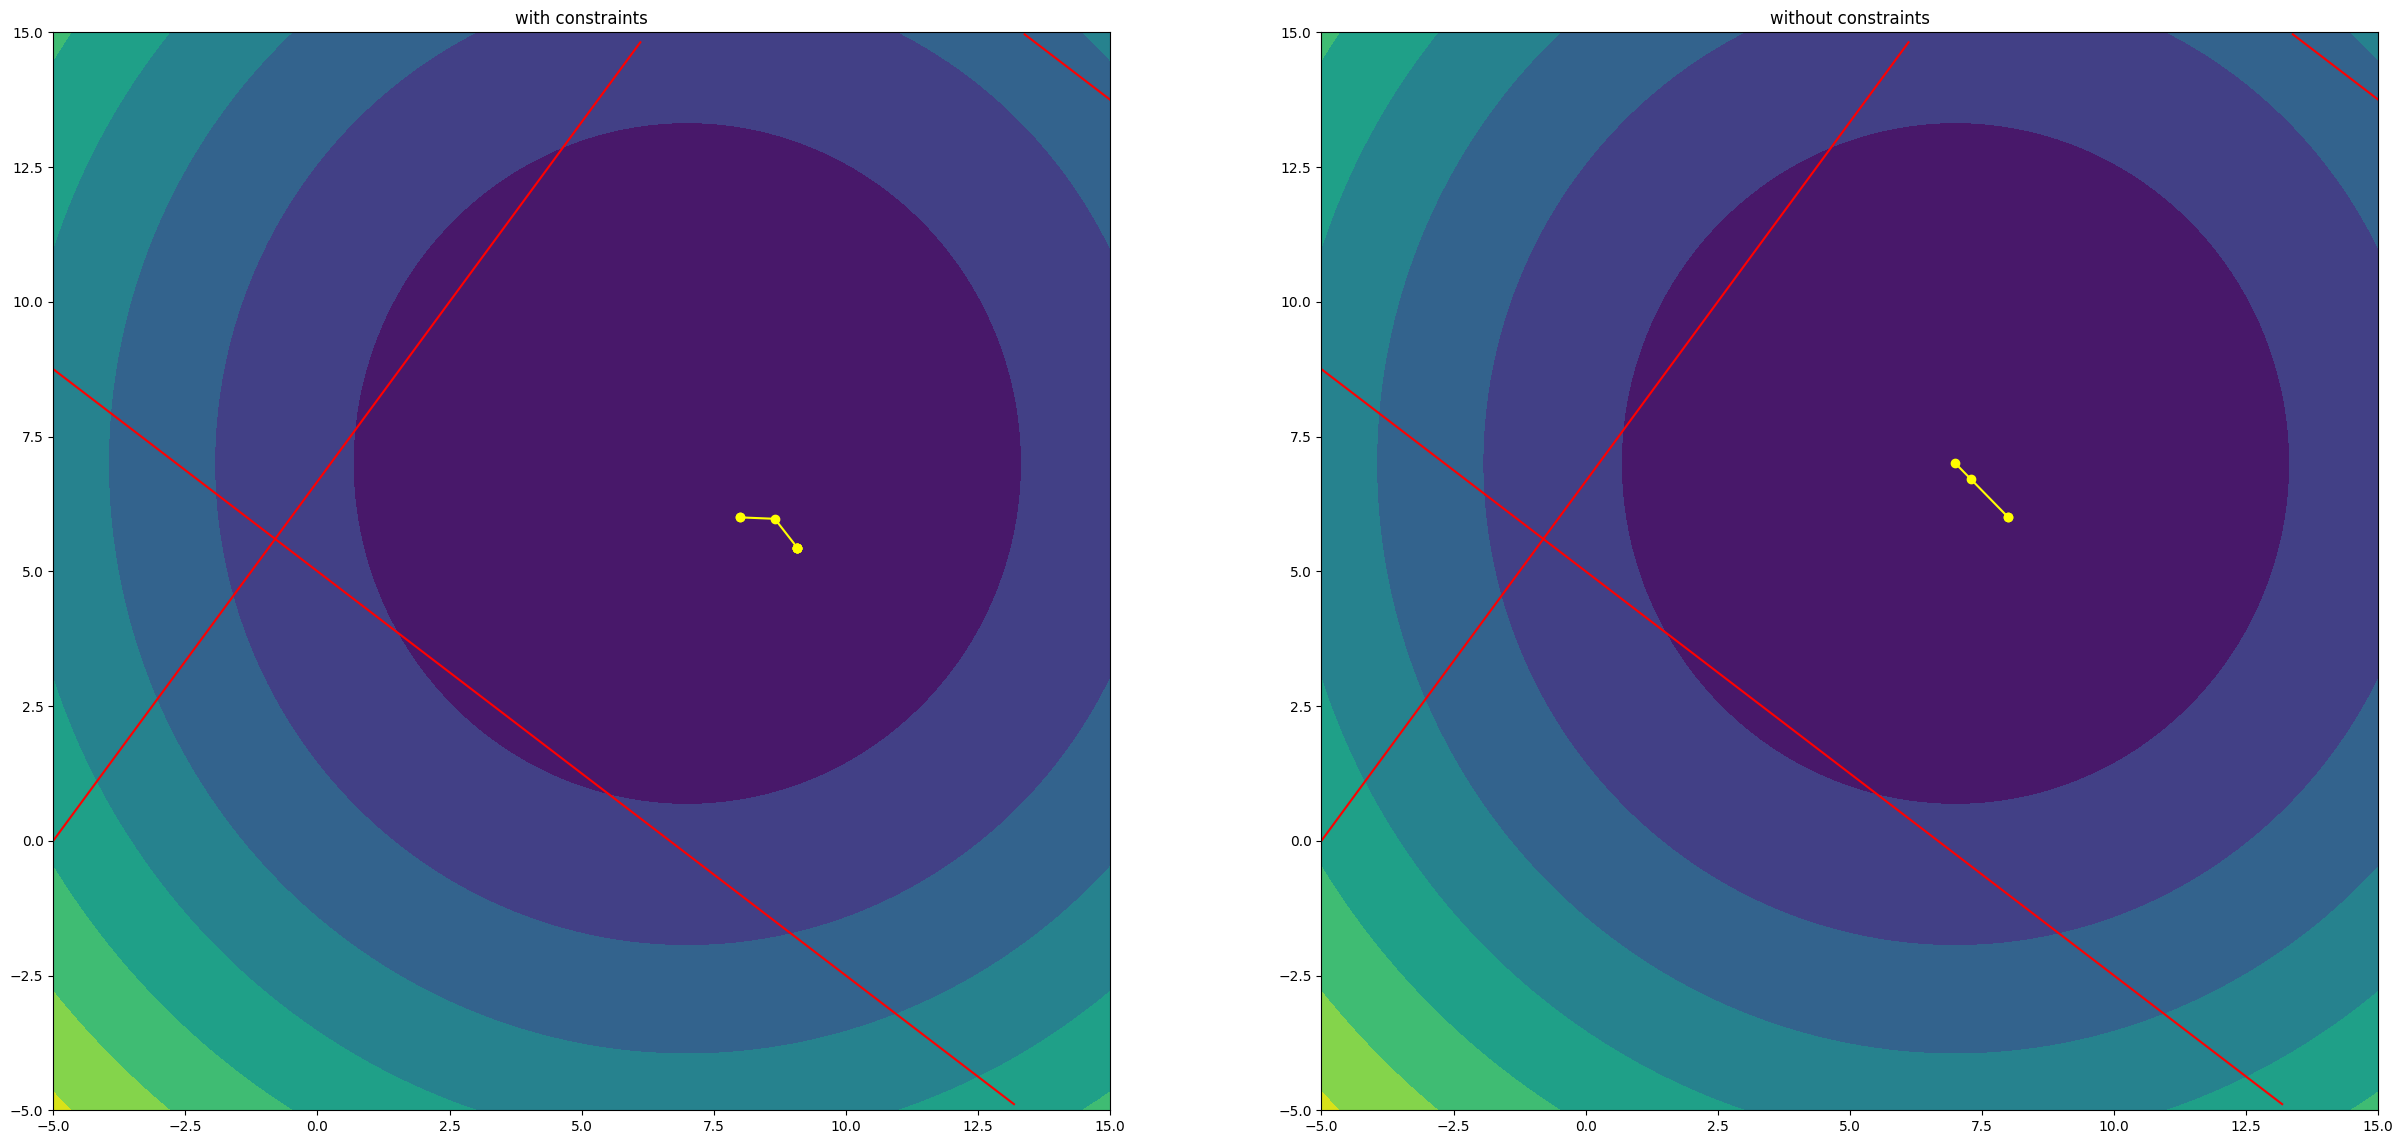

In [ ]:
test_bonus(function_minimum_inside, 'trust-constr', linear_constraint)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 1.8091944193036224e-09
       x: [ 7.000e+00  7.000e+00]
    nfev: 44
   maxcv: 0.0


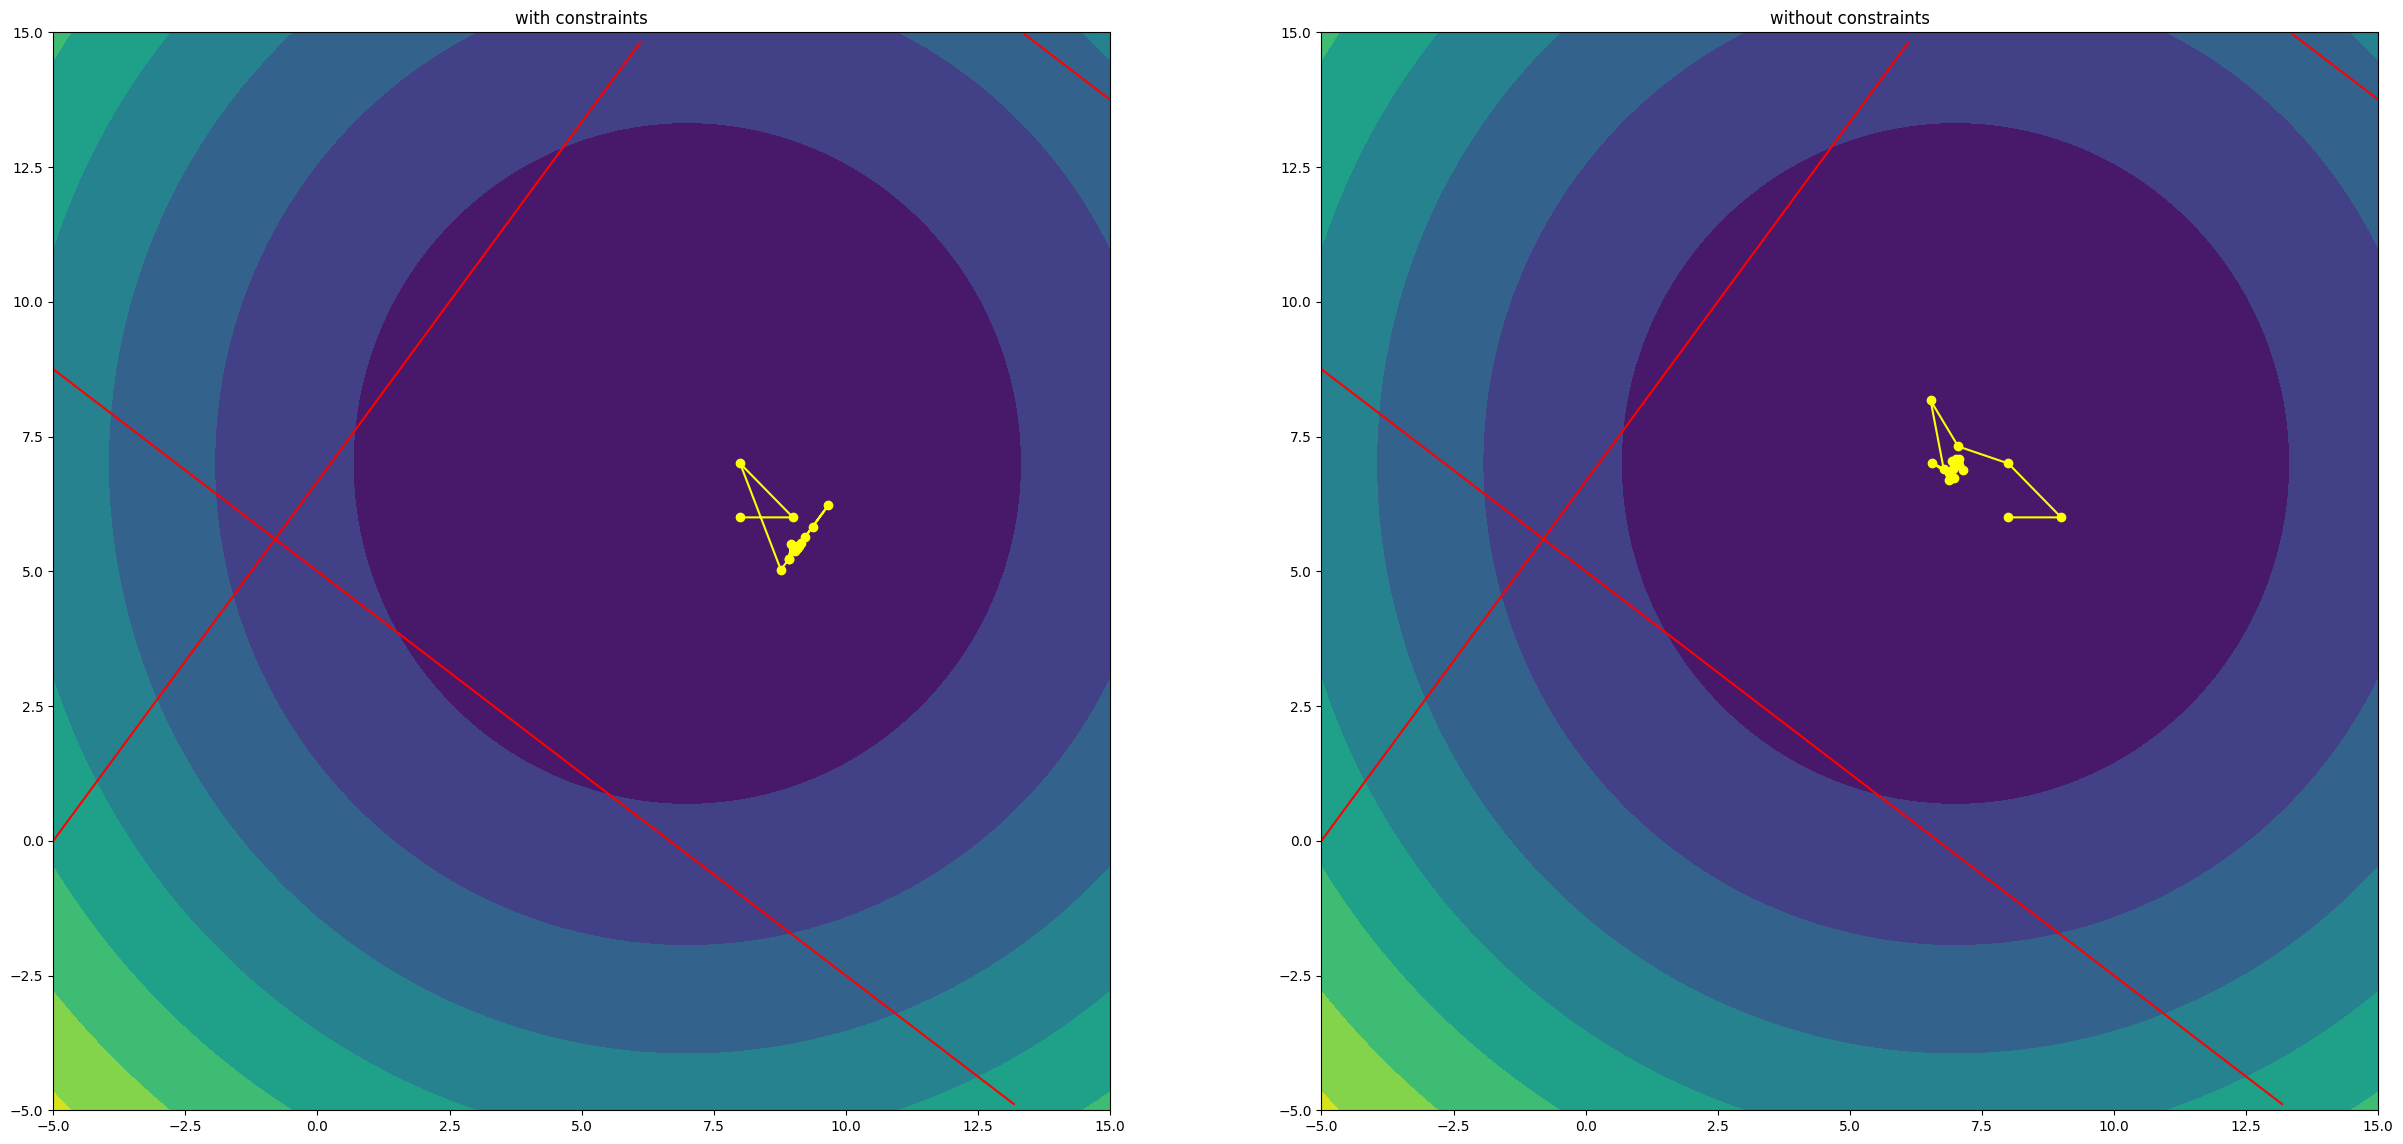

In [ ]:
test_bonus(function_minimum_inside, 'COBYLA', linear_constraint)

# Минимум снаружи linear constraint

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: -1.1102230246251565e-16
                x: [ 1.000e+00 -1.000e+00]
              nit: 22
             nfev: 60
             njev: 20
             nhev: 0
         cg_niter: 29
     cg_stop_cond: 2
             grad: [ 2.235e-08 -2.235e-08]
  lagrangian_grad: [ 2.235e-08 -2.235e-08]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 2.2351741790771484e-08
 constr_violation: 0
   execution_time: 0.28665637969970703
        tr_radius: 9.570312500000003e-09
   constr_penalty: 1.0
            niter: 22


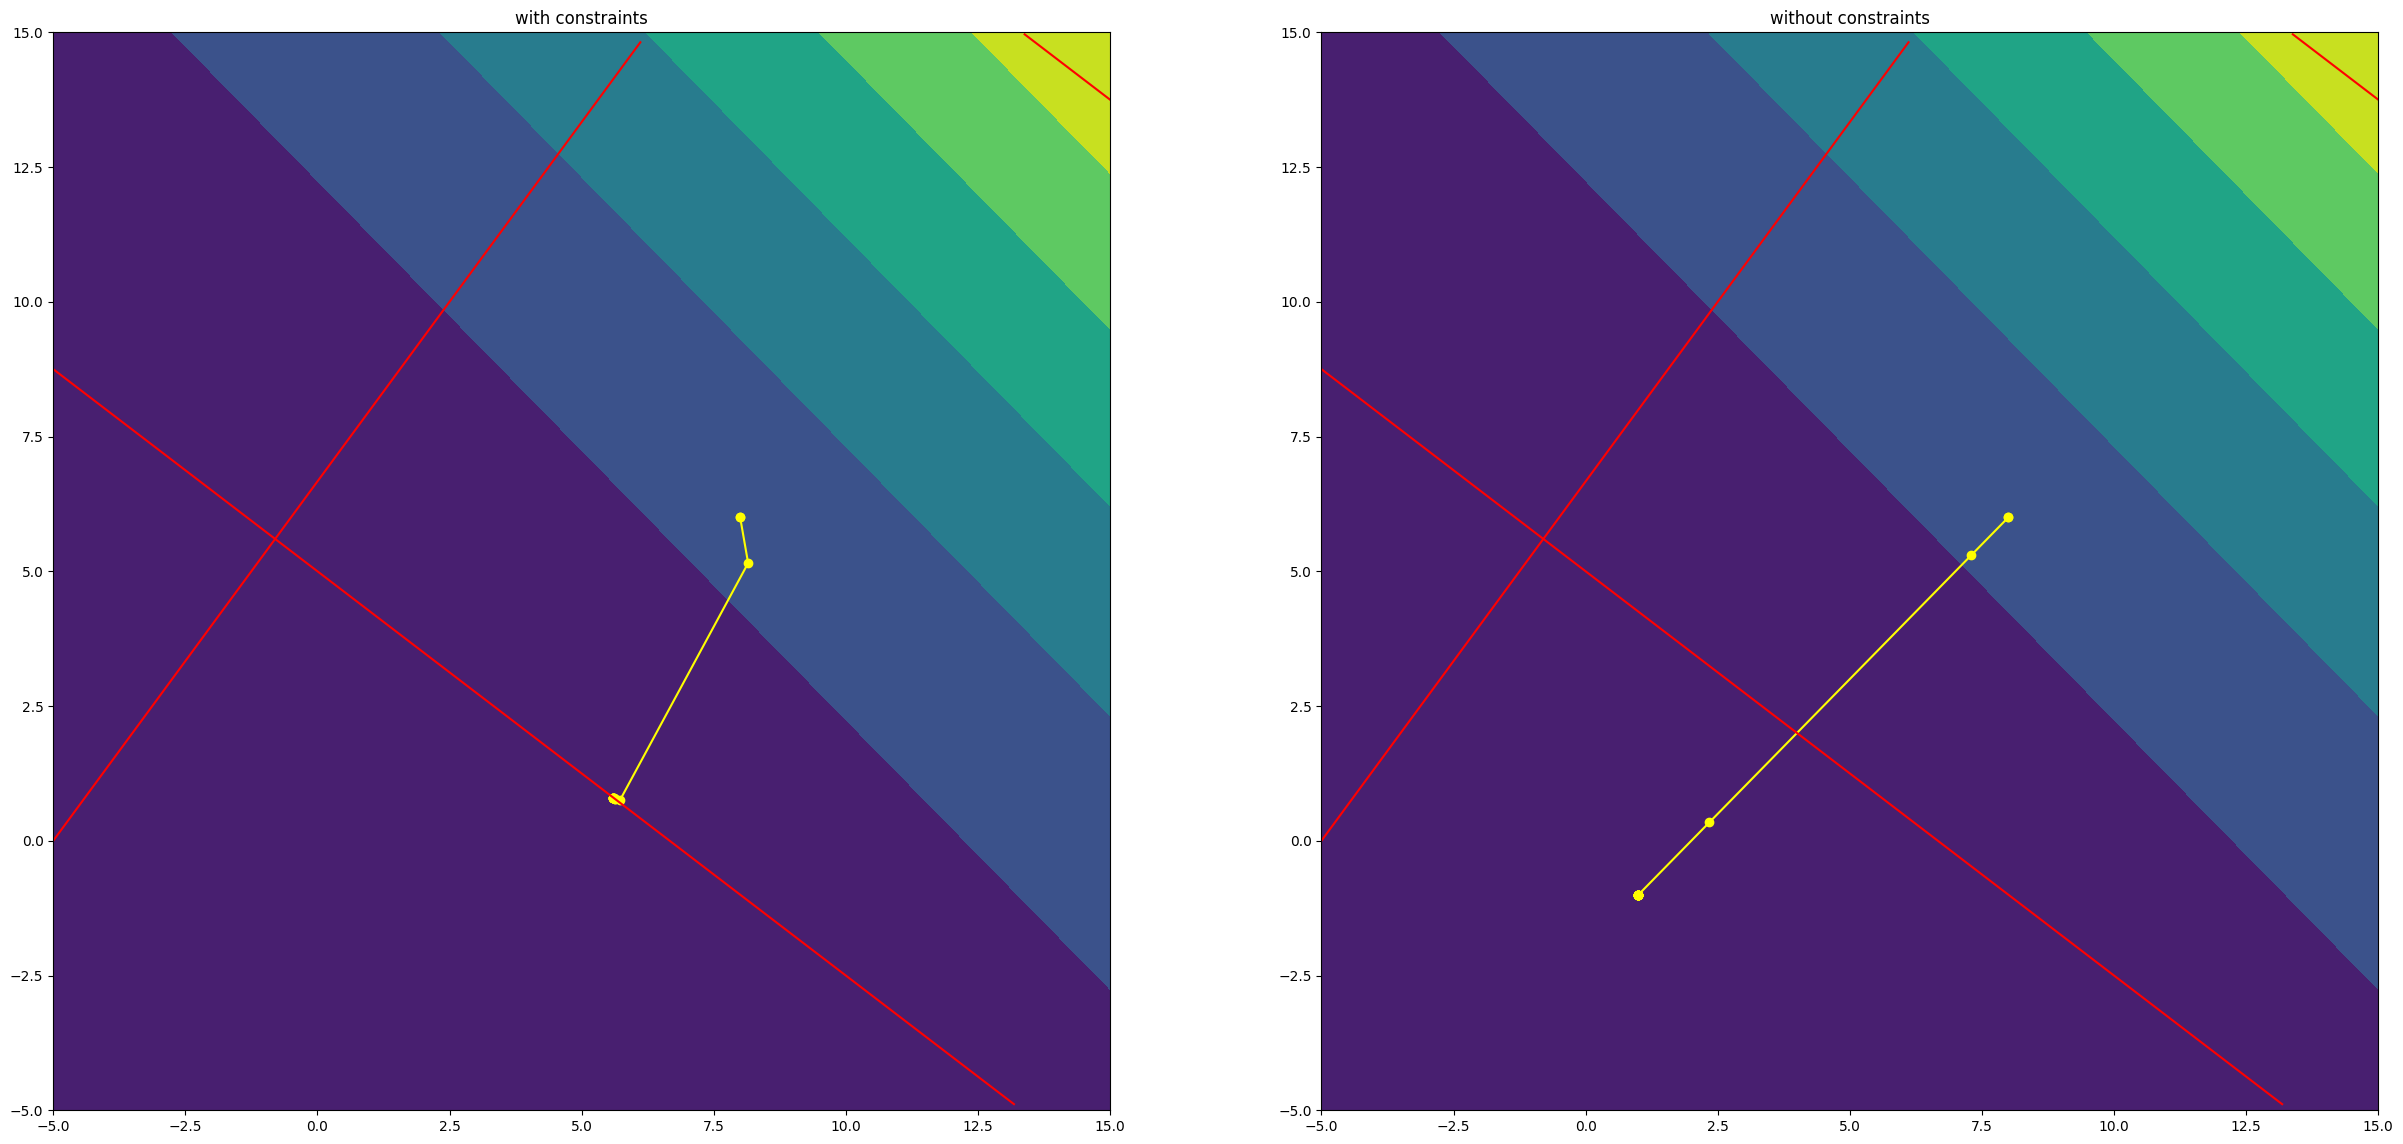

In [ ]:
test_bonus(f_1, 'trust-constr', linear_constraint)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 4.08232745385817e-08
       x: [ 2.306e+00 -2.306e+00]
    nfev: 46
   maxcv: 0.0


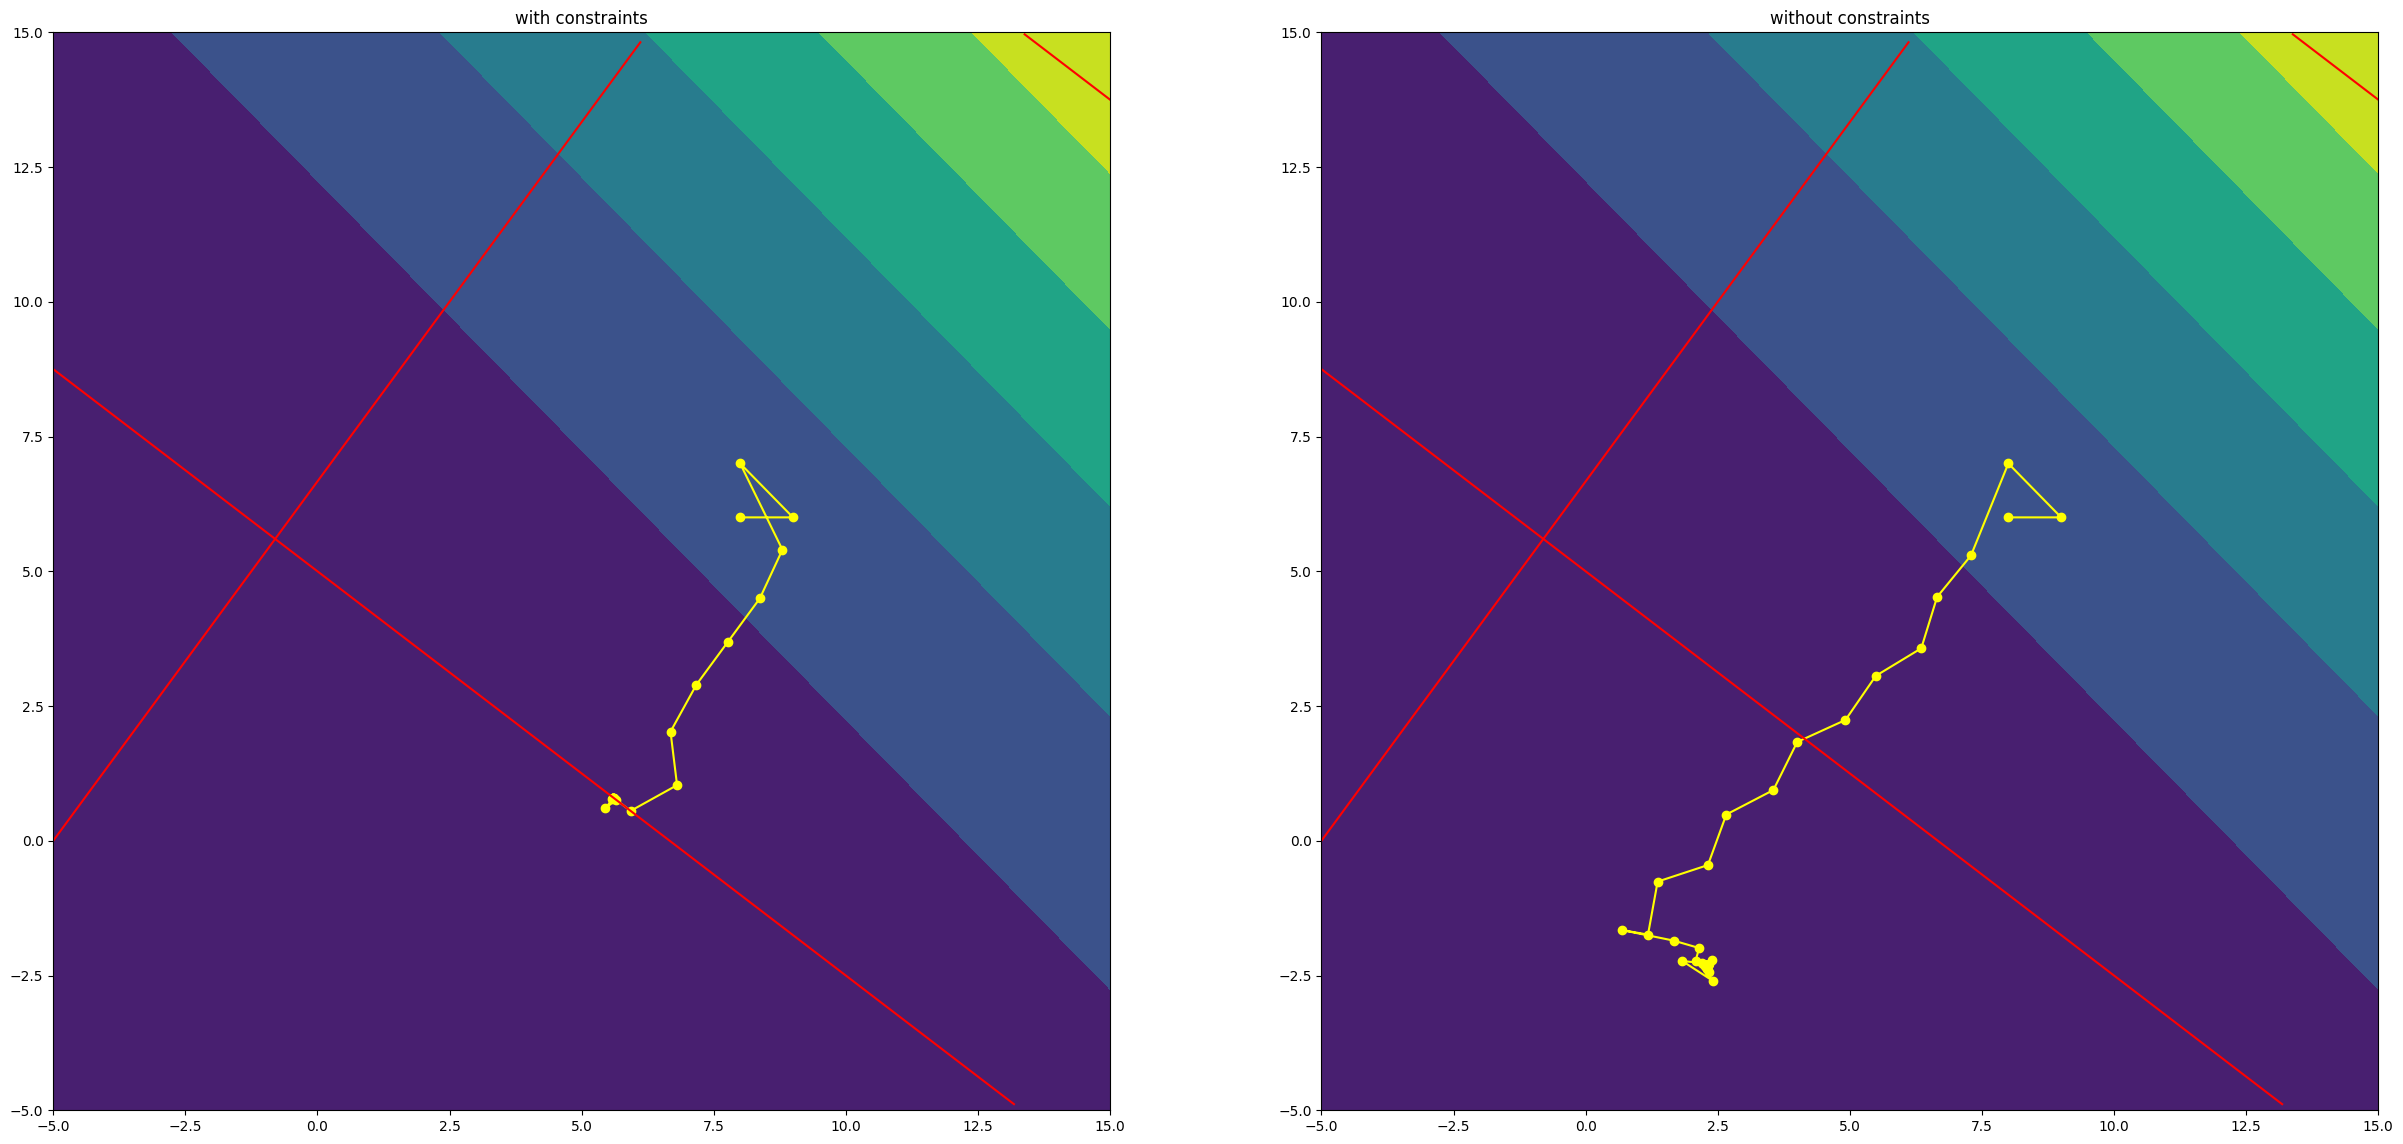

In [ ]:
test_bonus(f_1, 'COBYLA', linear_constraint)

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: 5.025979955659424e-18
                x: [-2.527e-09 -8.756e-10]
              nit: 30
             nfev: 90
             njev: 30
             nhev: 0
         cg_niter: 46
     cg_stop_cond: 2
             grad: [-1.820e-08 -6.156e-08]
  lagrangian_grad: [-1.820e-08 -6.156e-08]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 6.155633152503282e-08
 constr_violation: 0
   execution_time: 0.2787911891937256
        tr_radius: 5.069857293899029e-09
   constr_penalty: 1.0
            niter: 30


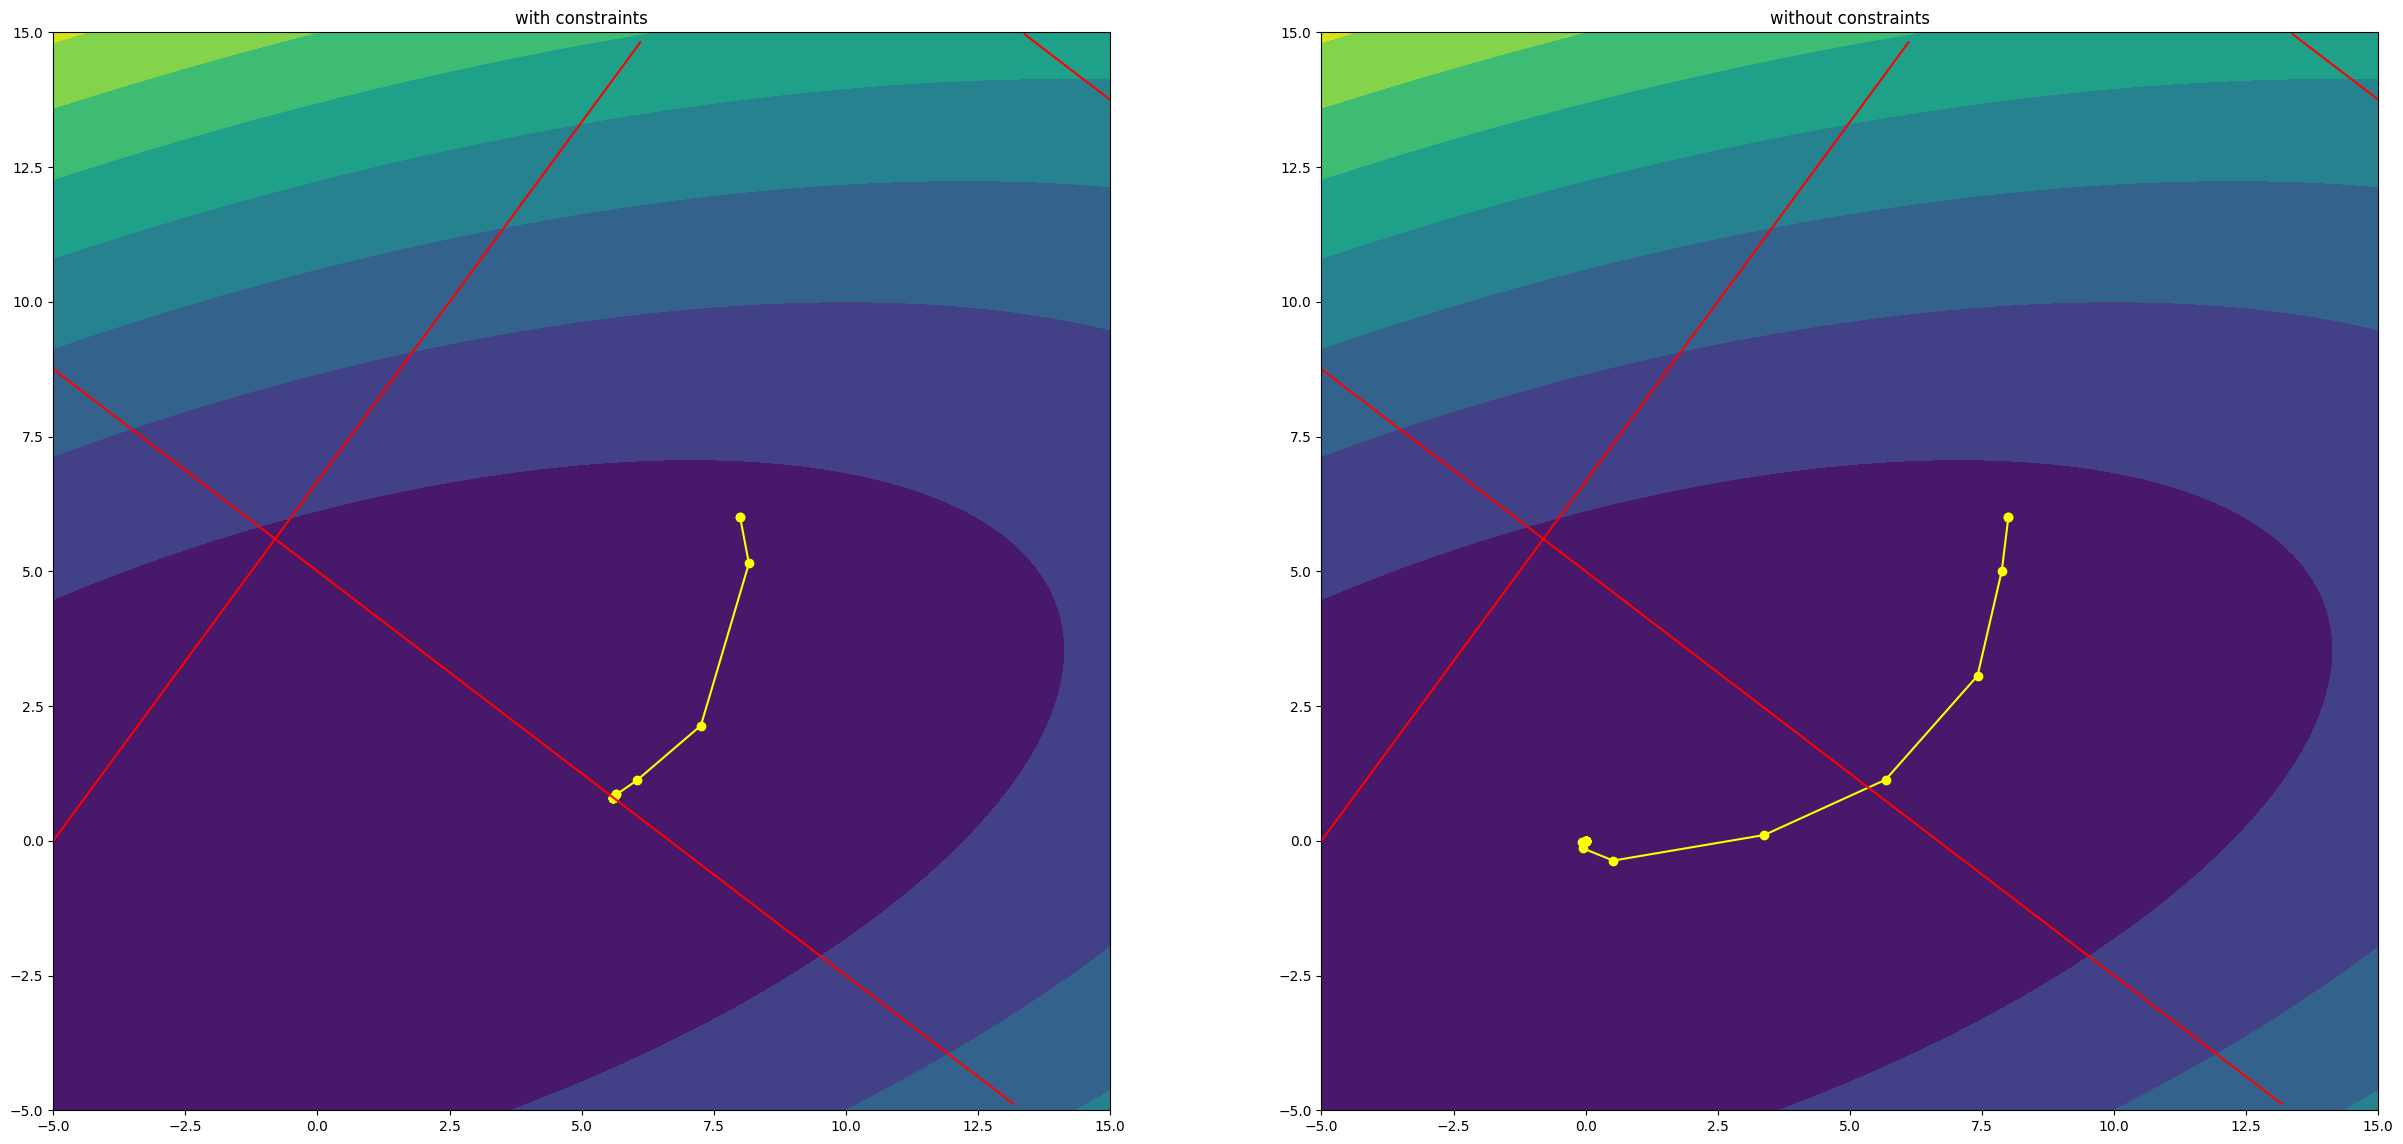

In [ ]:
test_bonus(f_3, 'trust-constr', linear_constraint)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 1.317598880737595e-08
       x: [ 3.919e-06  5.835e-05]
    nfev: 62
   maxcv: 0.0


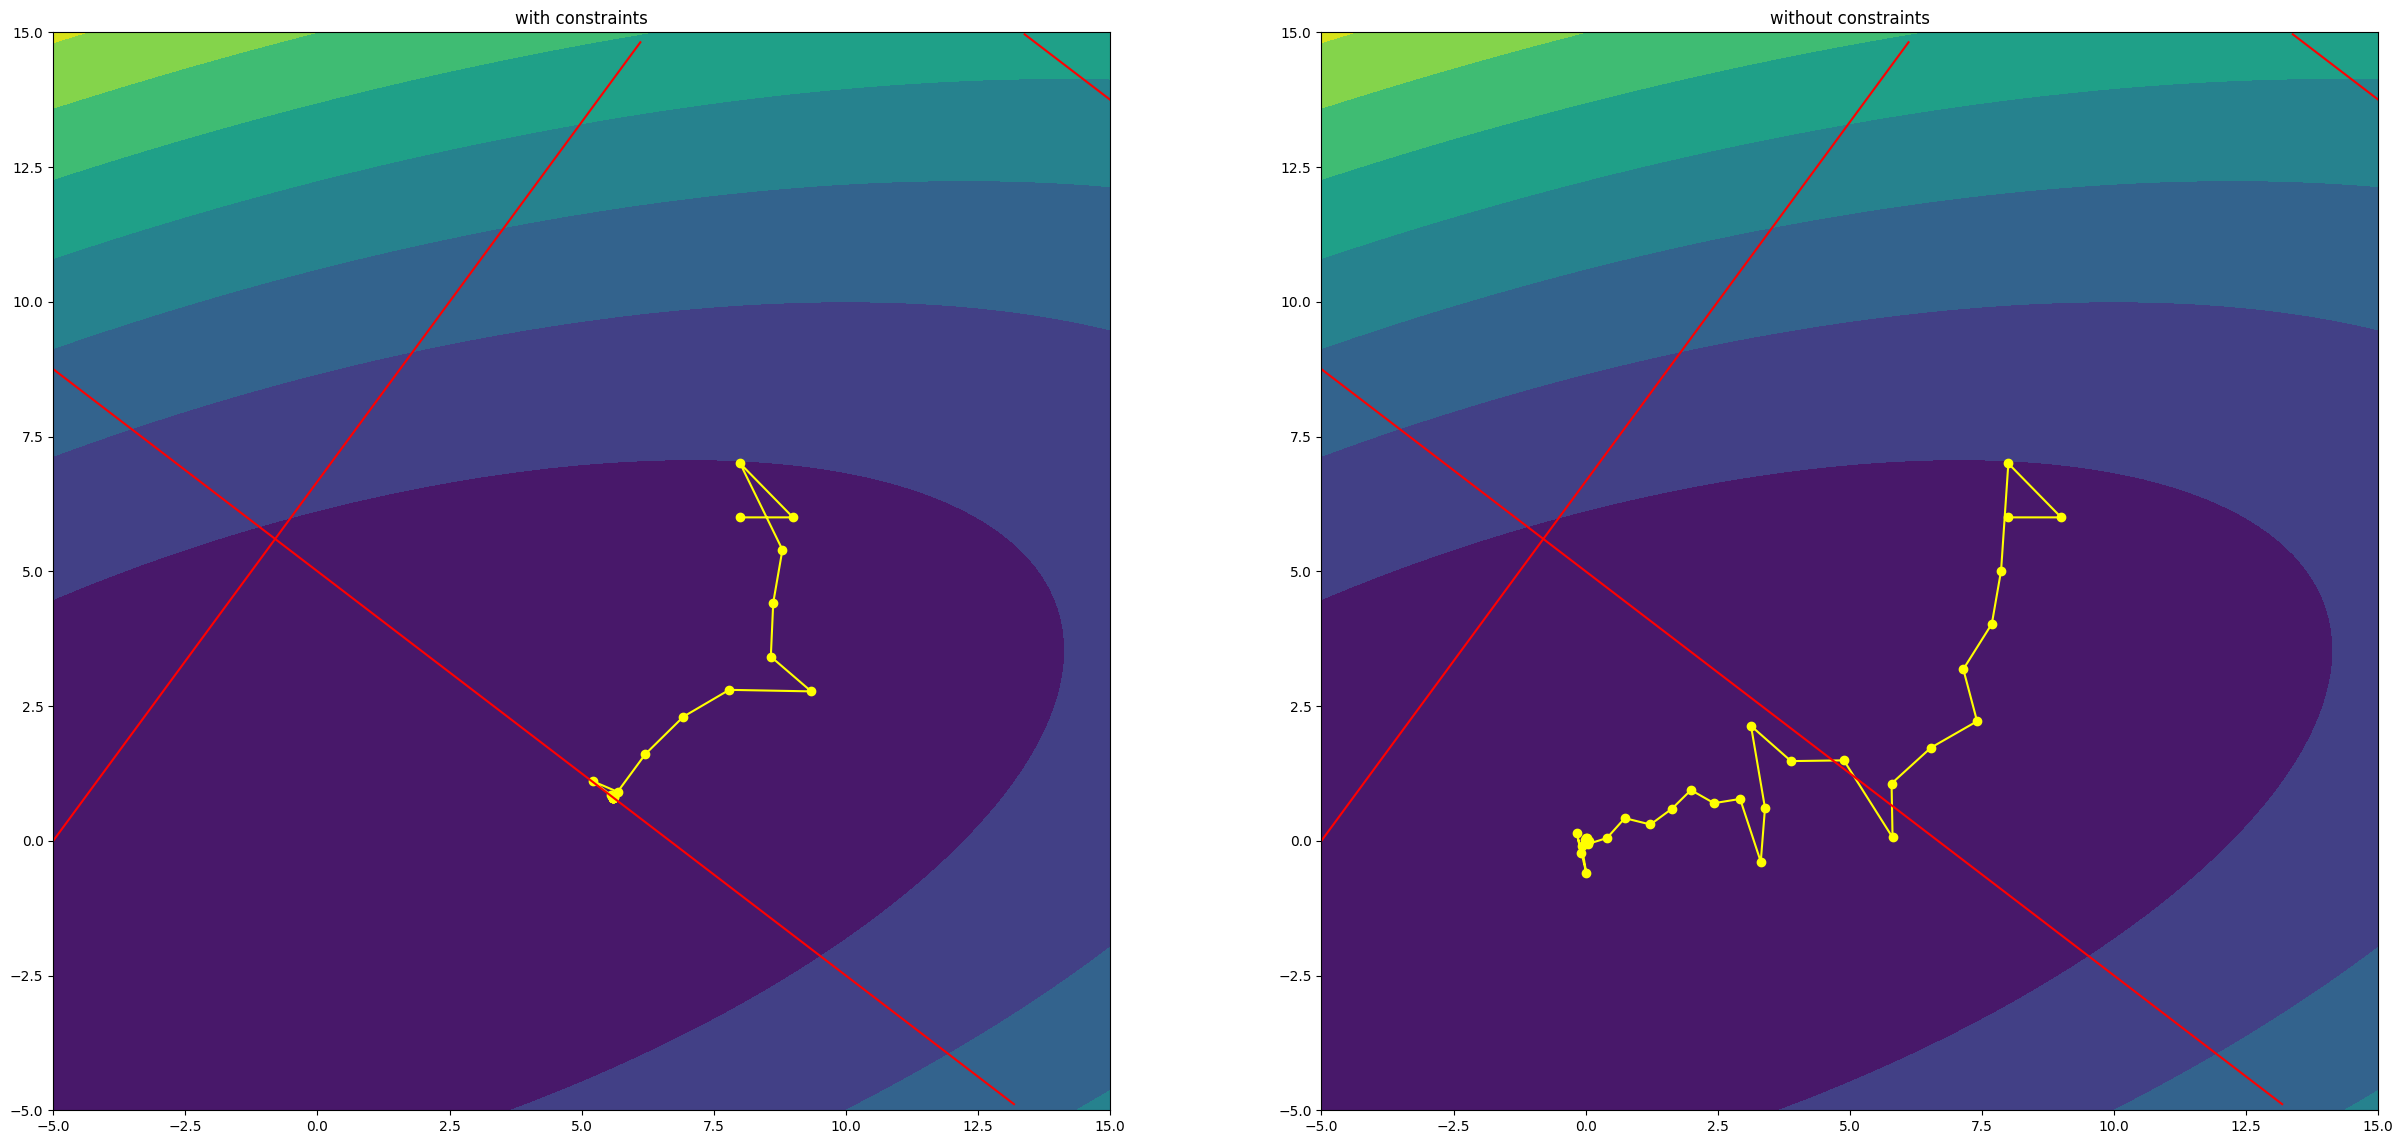

In [ ]:
test_bonus(f_3, 'COBYLA', linear_constraint)

# Нелинейные ограничения



In [ ]:
rad = 5

def f_cons(x):
     return [(x[0]-8)**2 + (x[1]-6)**2, (x[0]-8)**2 + (x[1]-6)**2]

nonlinear_constraint = NonlinearConstraint(f_cons, 0, rad*rad)

# Минимум внутри non_linear_constraint

          message: `gtol` termination condition is satisfied.
          success: True
           status: 1
              fun: 5.441459082312369e-15
                x: [ 7.000e+00  7.000e+00]
              nit: 3
             nfev: 9
             njev: 3
             nhev: 0
         cg_niter: 2
     cg_stop_cond: 4
             grad: [-5.920e-11  3.303e-11]
  lagrangian_grad: [-5.920e-11  3.303e-11]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 5.920330892195125e-11
 constr_violation: 0
   execution_time: 0.019124507904052734
        tr_radius: 2.899494936839935
   constr_penalty: 1.0
            niter: 3


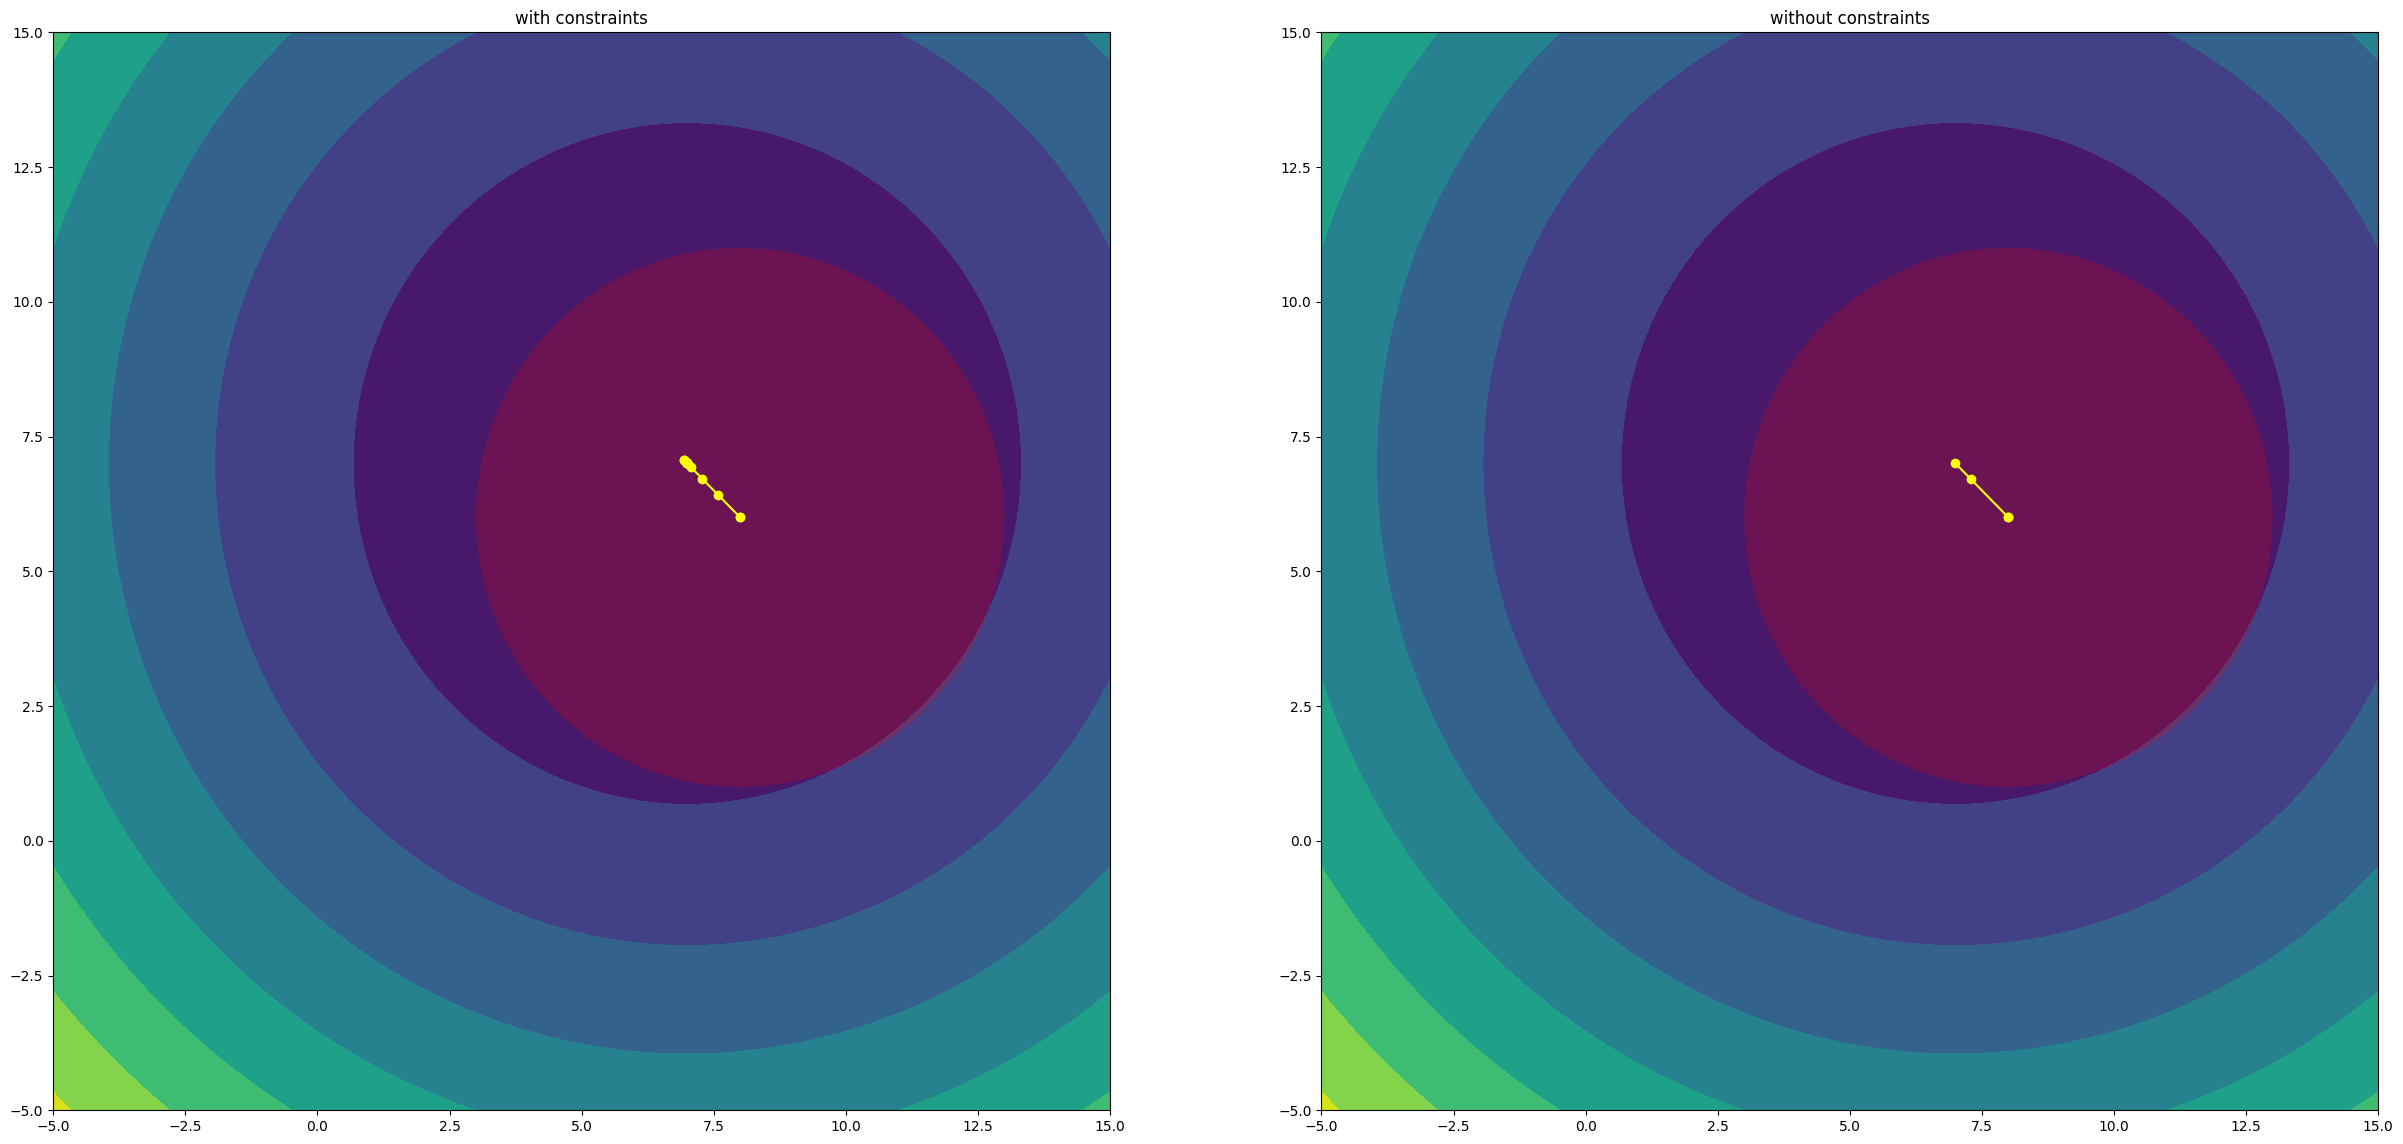

In [ ]:
test_bonus(function_minimum_inside, 'trust-constr', nonlinear_constraint, f_cons)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 1.8091944193036224e-09
       x: [ 7.000e+00  7.000e+00]
    nfev: 44
   maxcv: 0.0


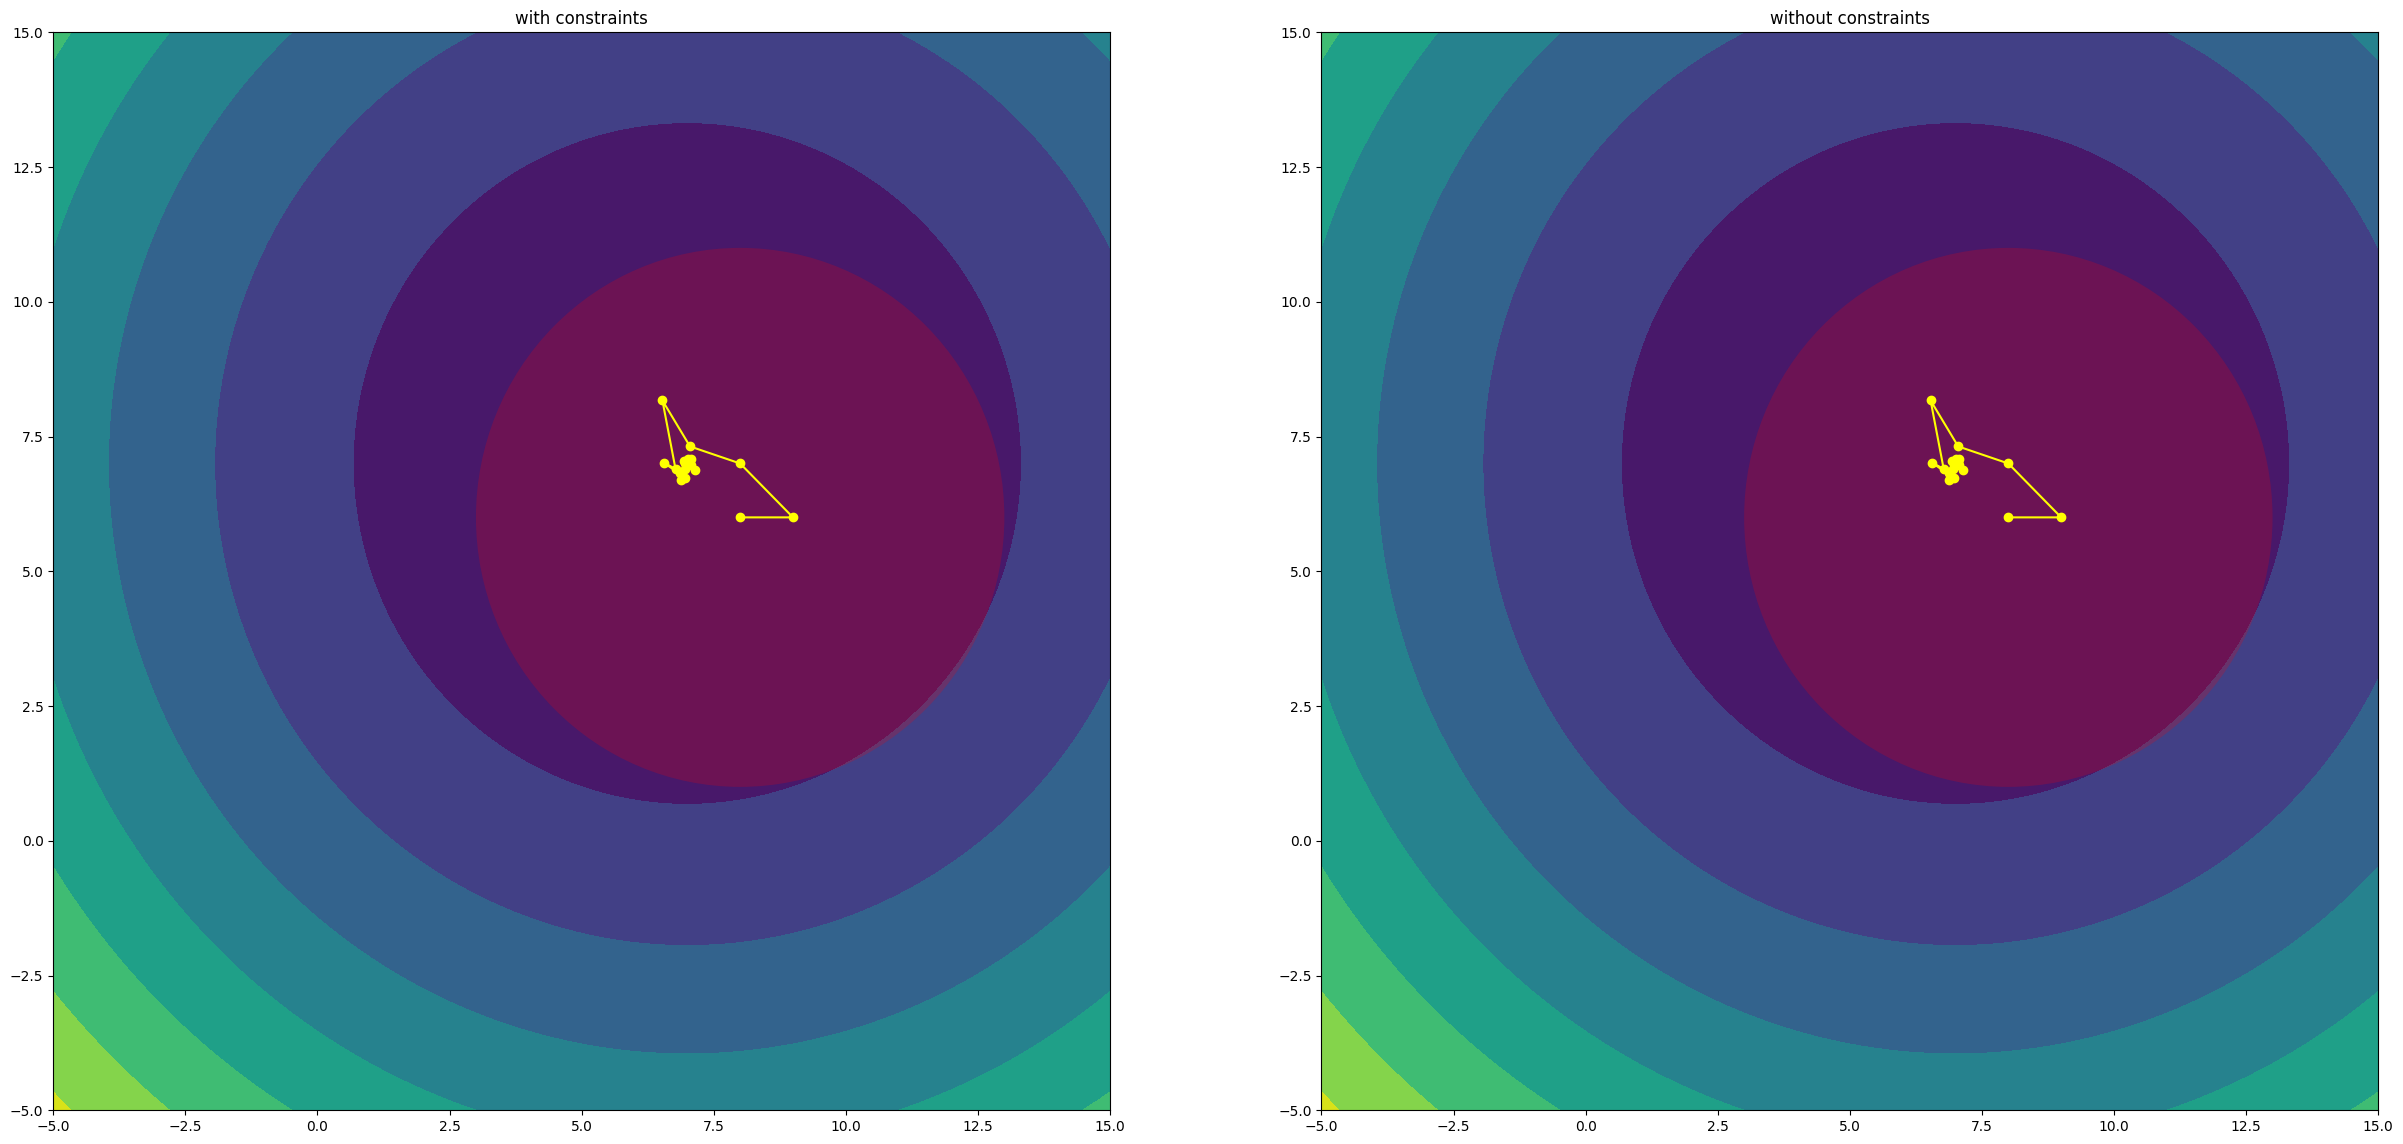

In [ ]:
test_bonus(function_minimum_inside, 'COBYLA', nonlinear_constraint, f_cons)

# Минимум снаружи non_linear_constraint

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: -1.1102230246251565e-16
                x: [ 1.000e+00 -1.000e+00]
              nit: 22
             nfev: 60
             njev: 20
             nhev: 0
         cg_niter: 29
     cg_stop_cond: 2
             grad: [ 2.235e-08 -2.235e-08]
  lagrangian_grad: [ 2.235e-08 -2.235e-08]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 2.2351741790771484e-08
 constr_violation: 0
   execution_time: 0.0962071418762207
        tr_radius: 9.570312500000003e-09
   constr_penalty: 1.0
            niter: 22


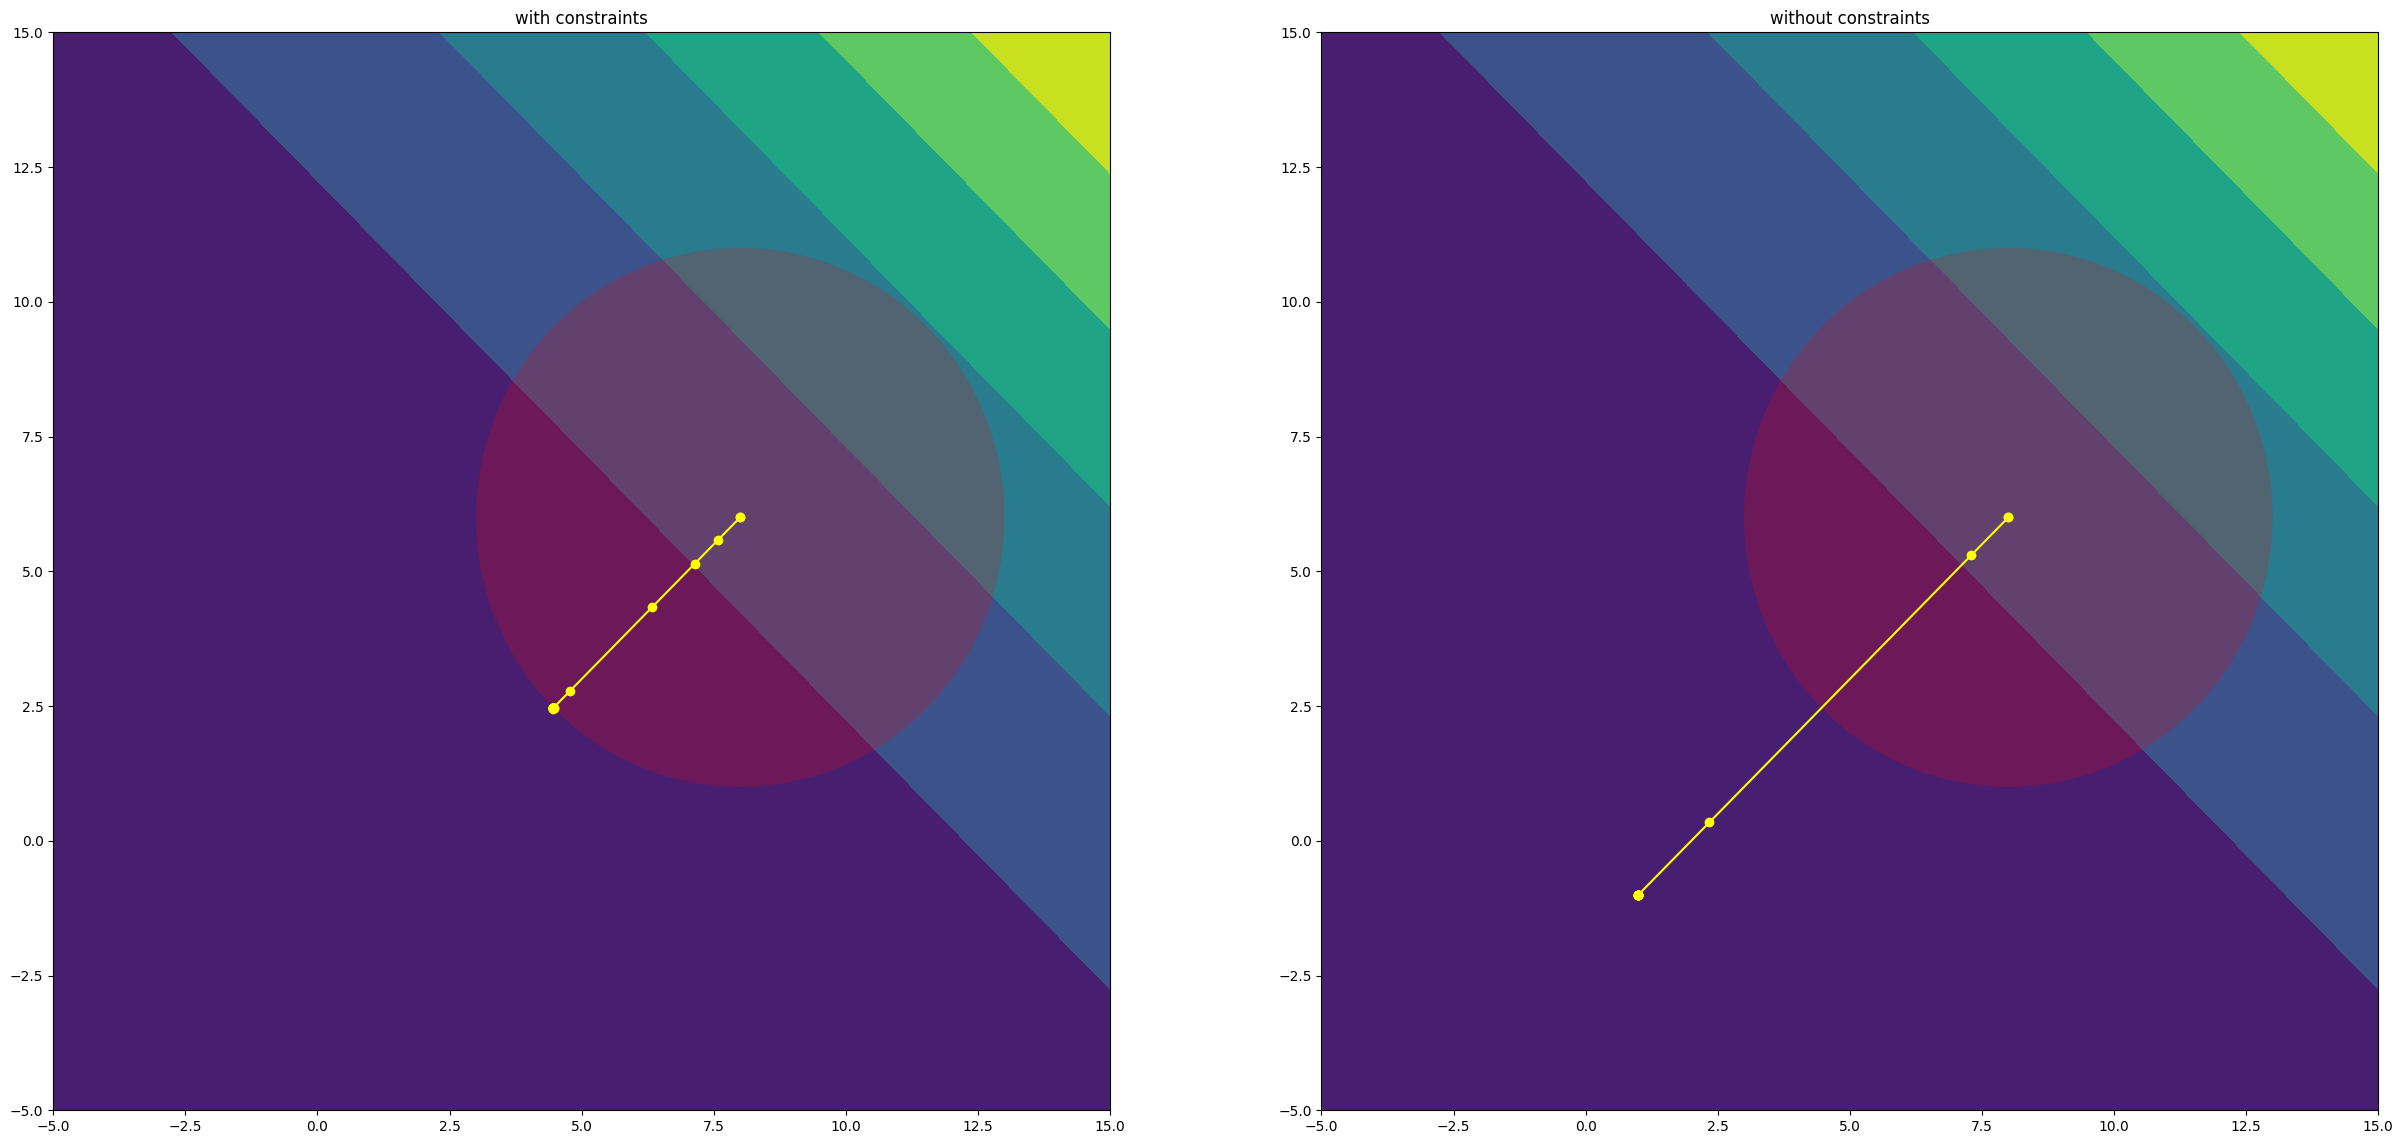

In [ ]:
test_bonus(f_1, 'trust-constr', nonlinear_constraint, f_cons)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 4.08232745385817e-08
       x: [ 2.306e+00 -2.306e+00]
    nfev: 46
   maxcv: 0.0


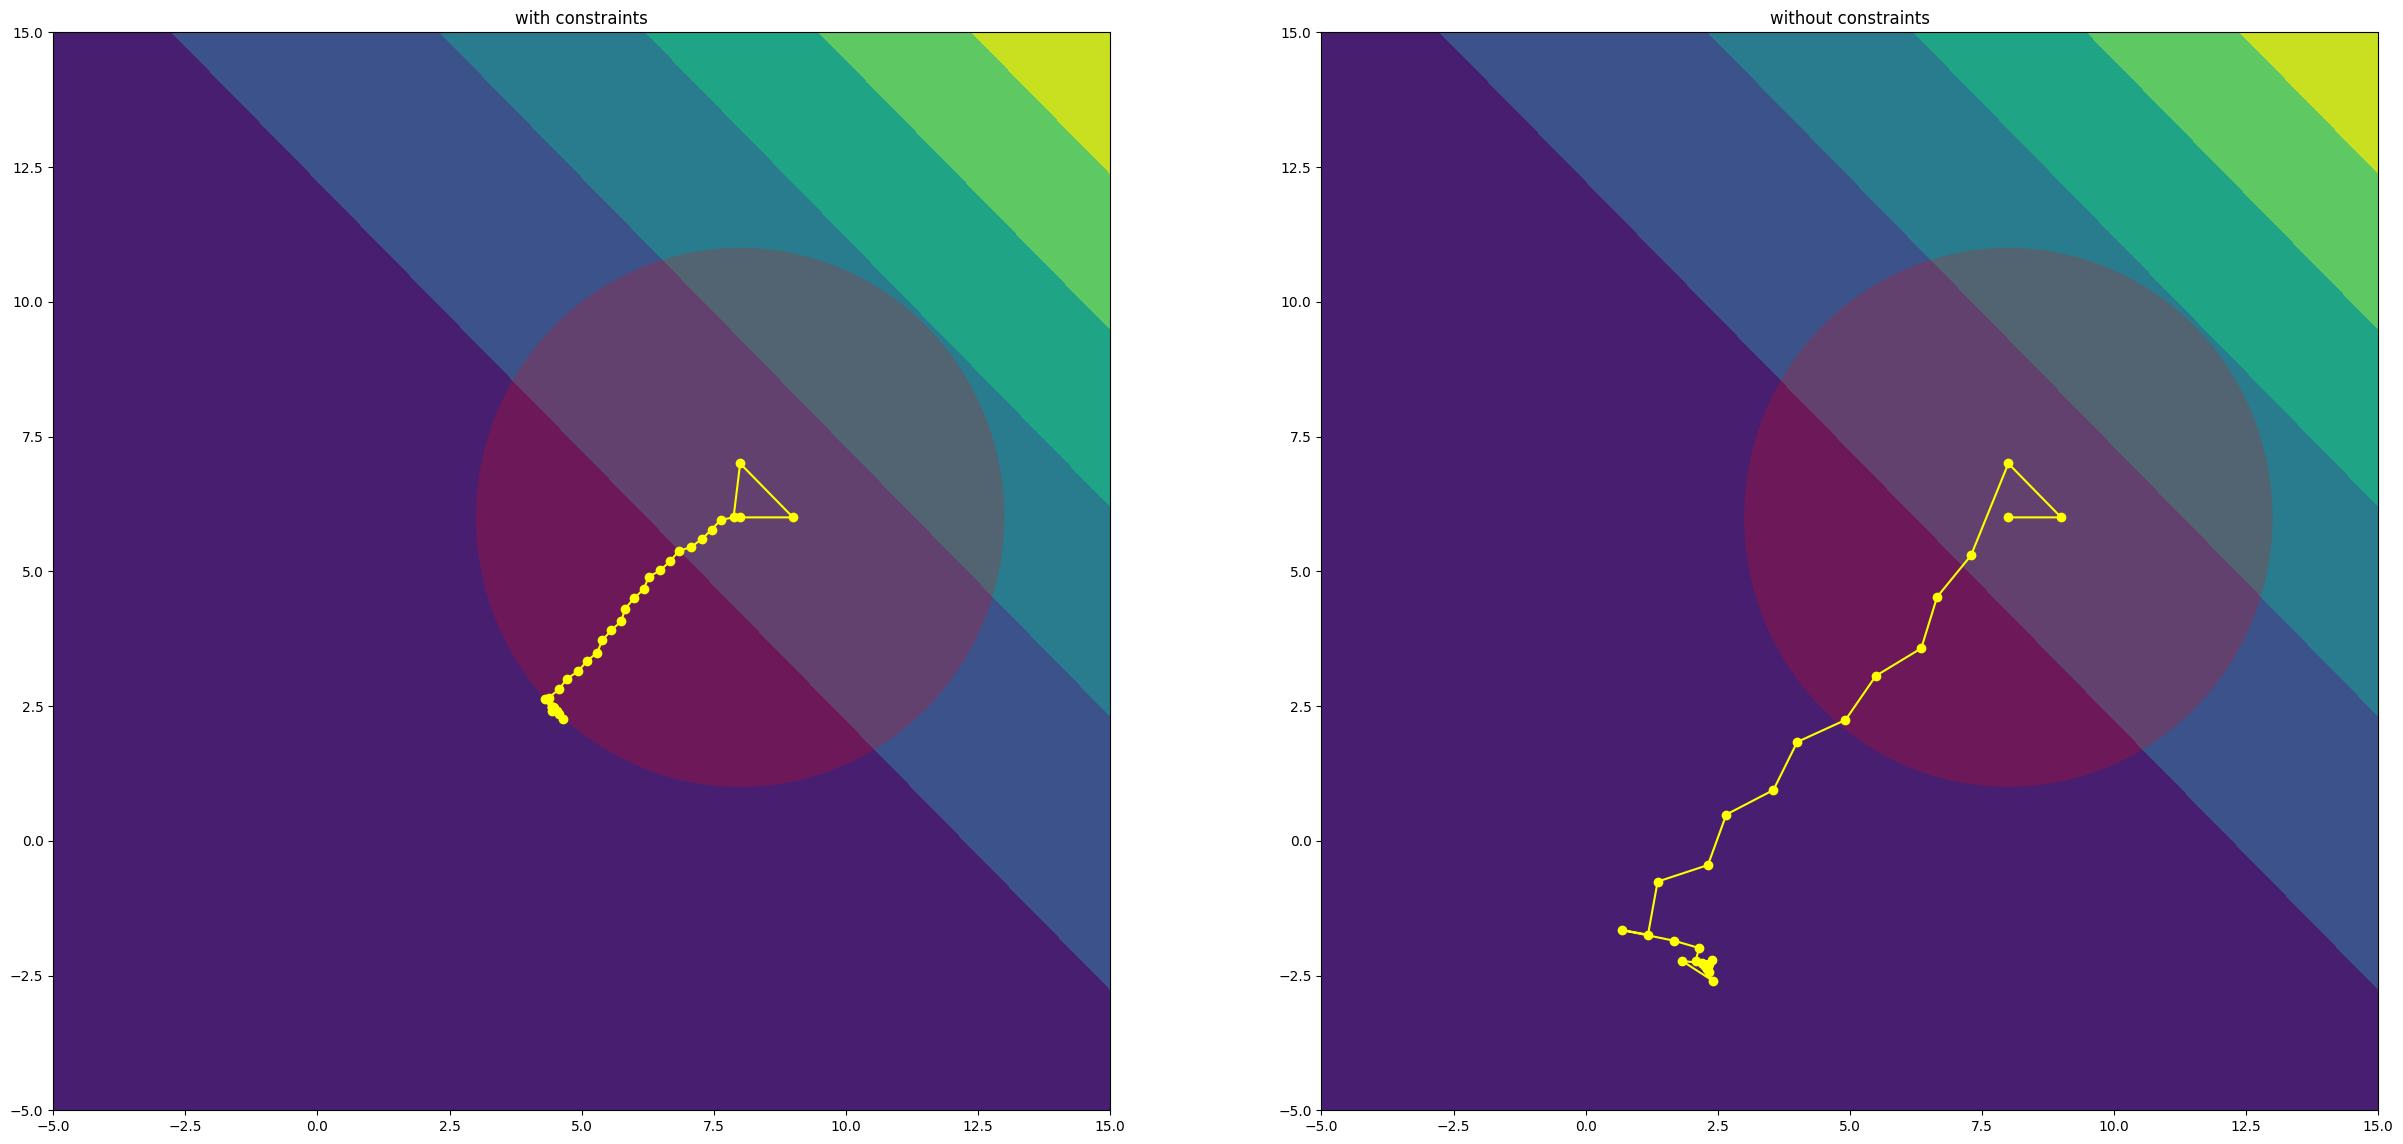

In [ ]:
test_bonus(f_1, 'COBYLA', nonlinear_constraint, f_cons)

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: 5.025979955659424e-18
                x: [-2.527e-09 -8.756e-10]
              nit: 30
             nfev: 90
             njev: 30
             nhev: 0
         cg_niter: 46
     cg_stop_cond: 2
             grad: [-1.820e-08 -6.156e-08]
  lagrangian_grad: [-1.820e-08 -6.156e-08]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 6.155633152503282e-08
 constr_violation: 0
   execution_time: 0.2638967037200928
        tr_radius: 5.069857293899029e-09
   constr_penalty: 1.0
            niter: 30


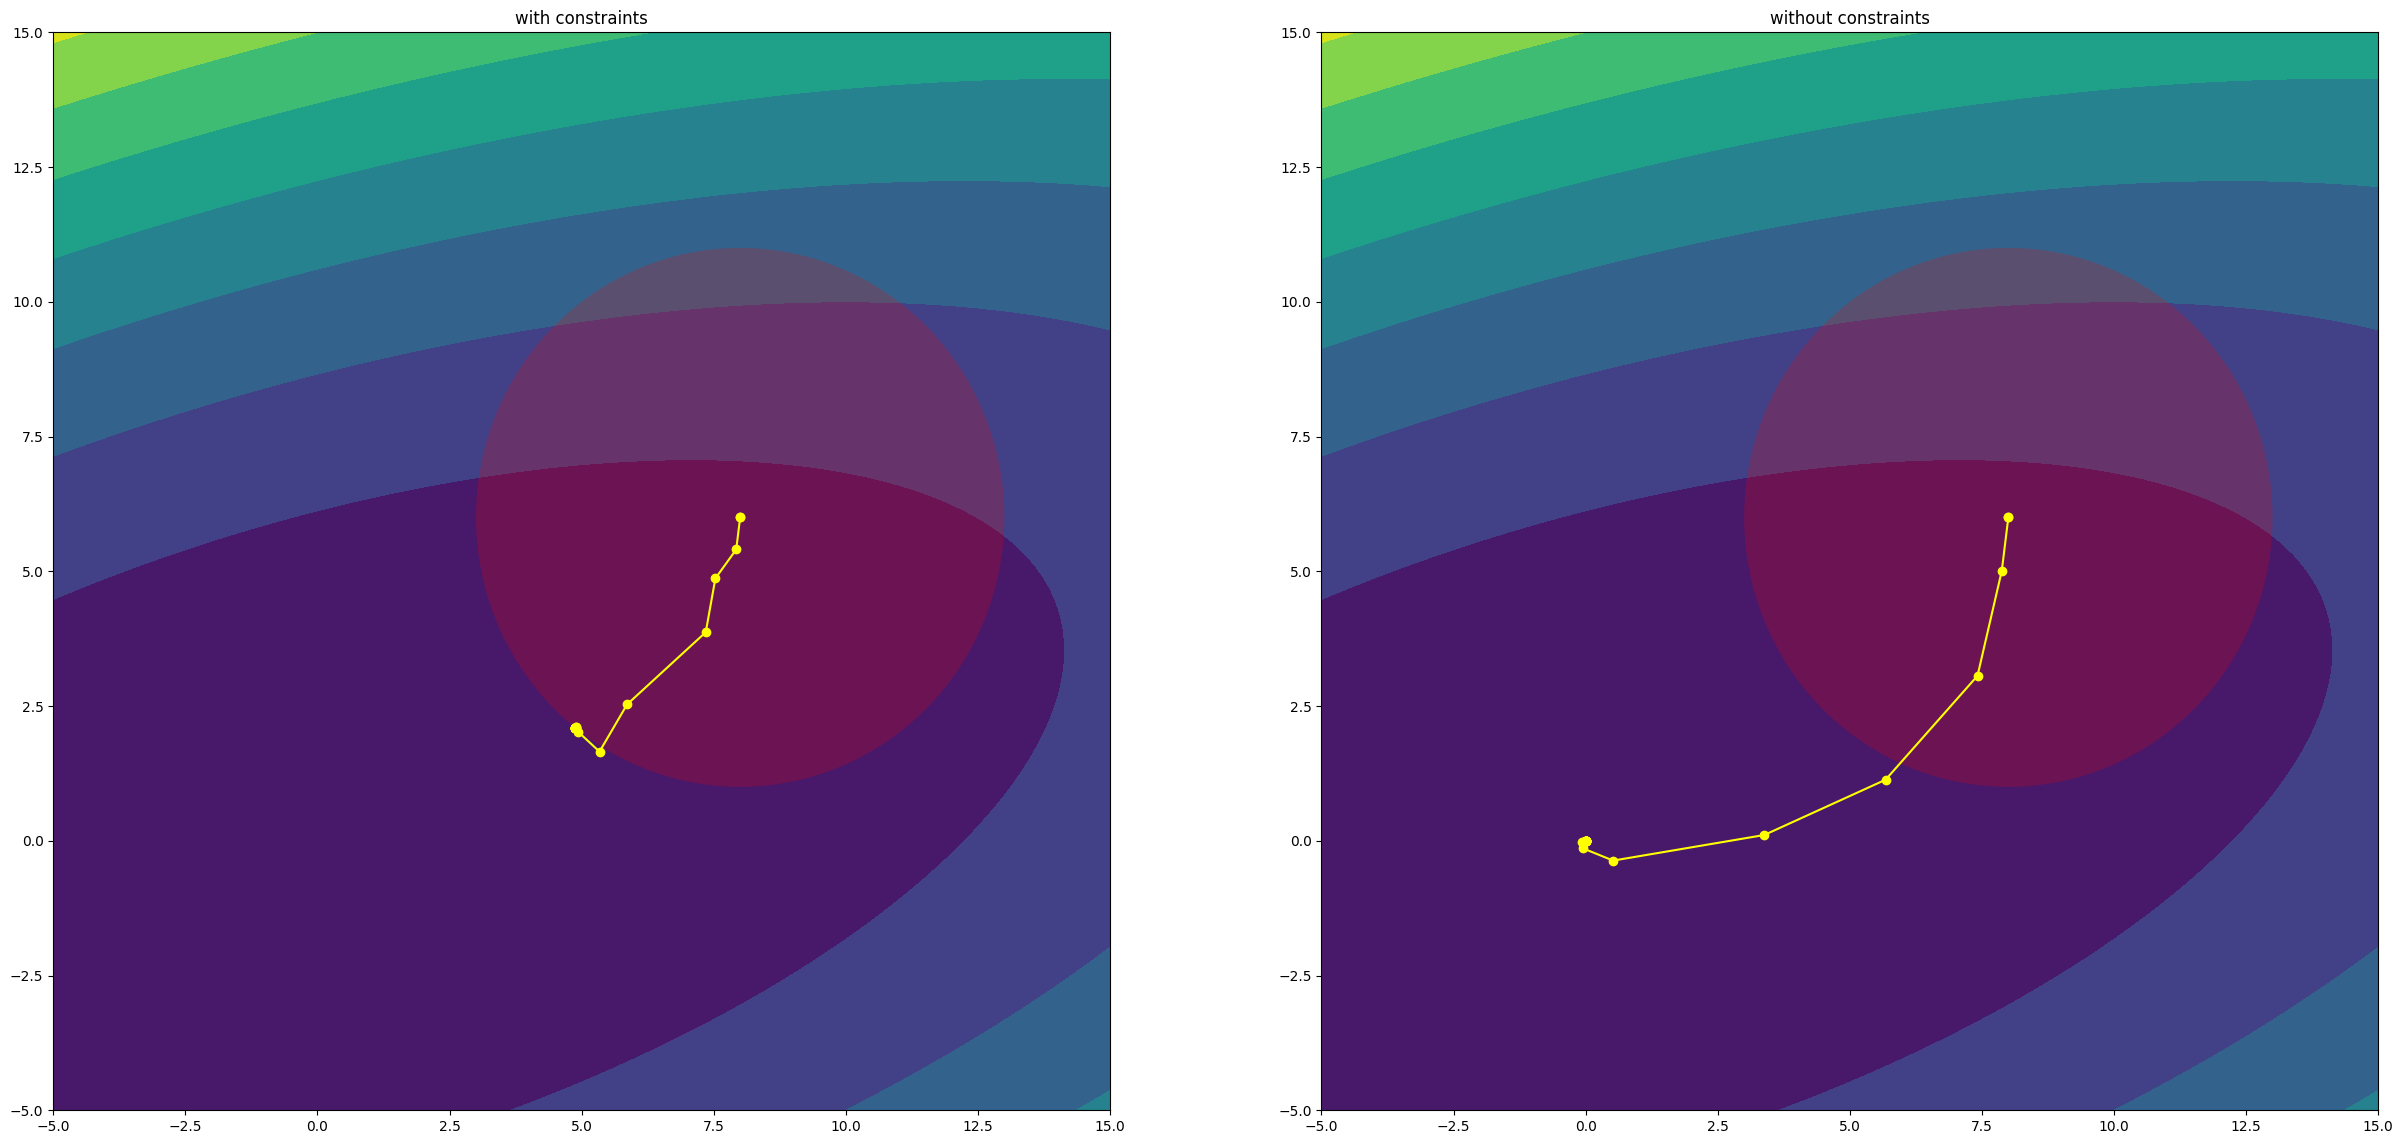

In [ ]:
test_bonus(f_3, 'trust-constr', nonlinear_constraint, f_cons)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 1.317598880737595e-08
       x: [ 3.919e-06  5.835e-05]
    nfev: 62
   maxcv: 0.0


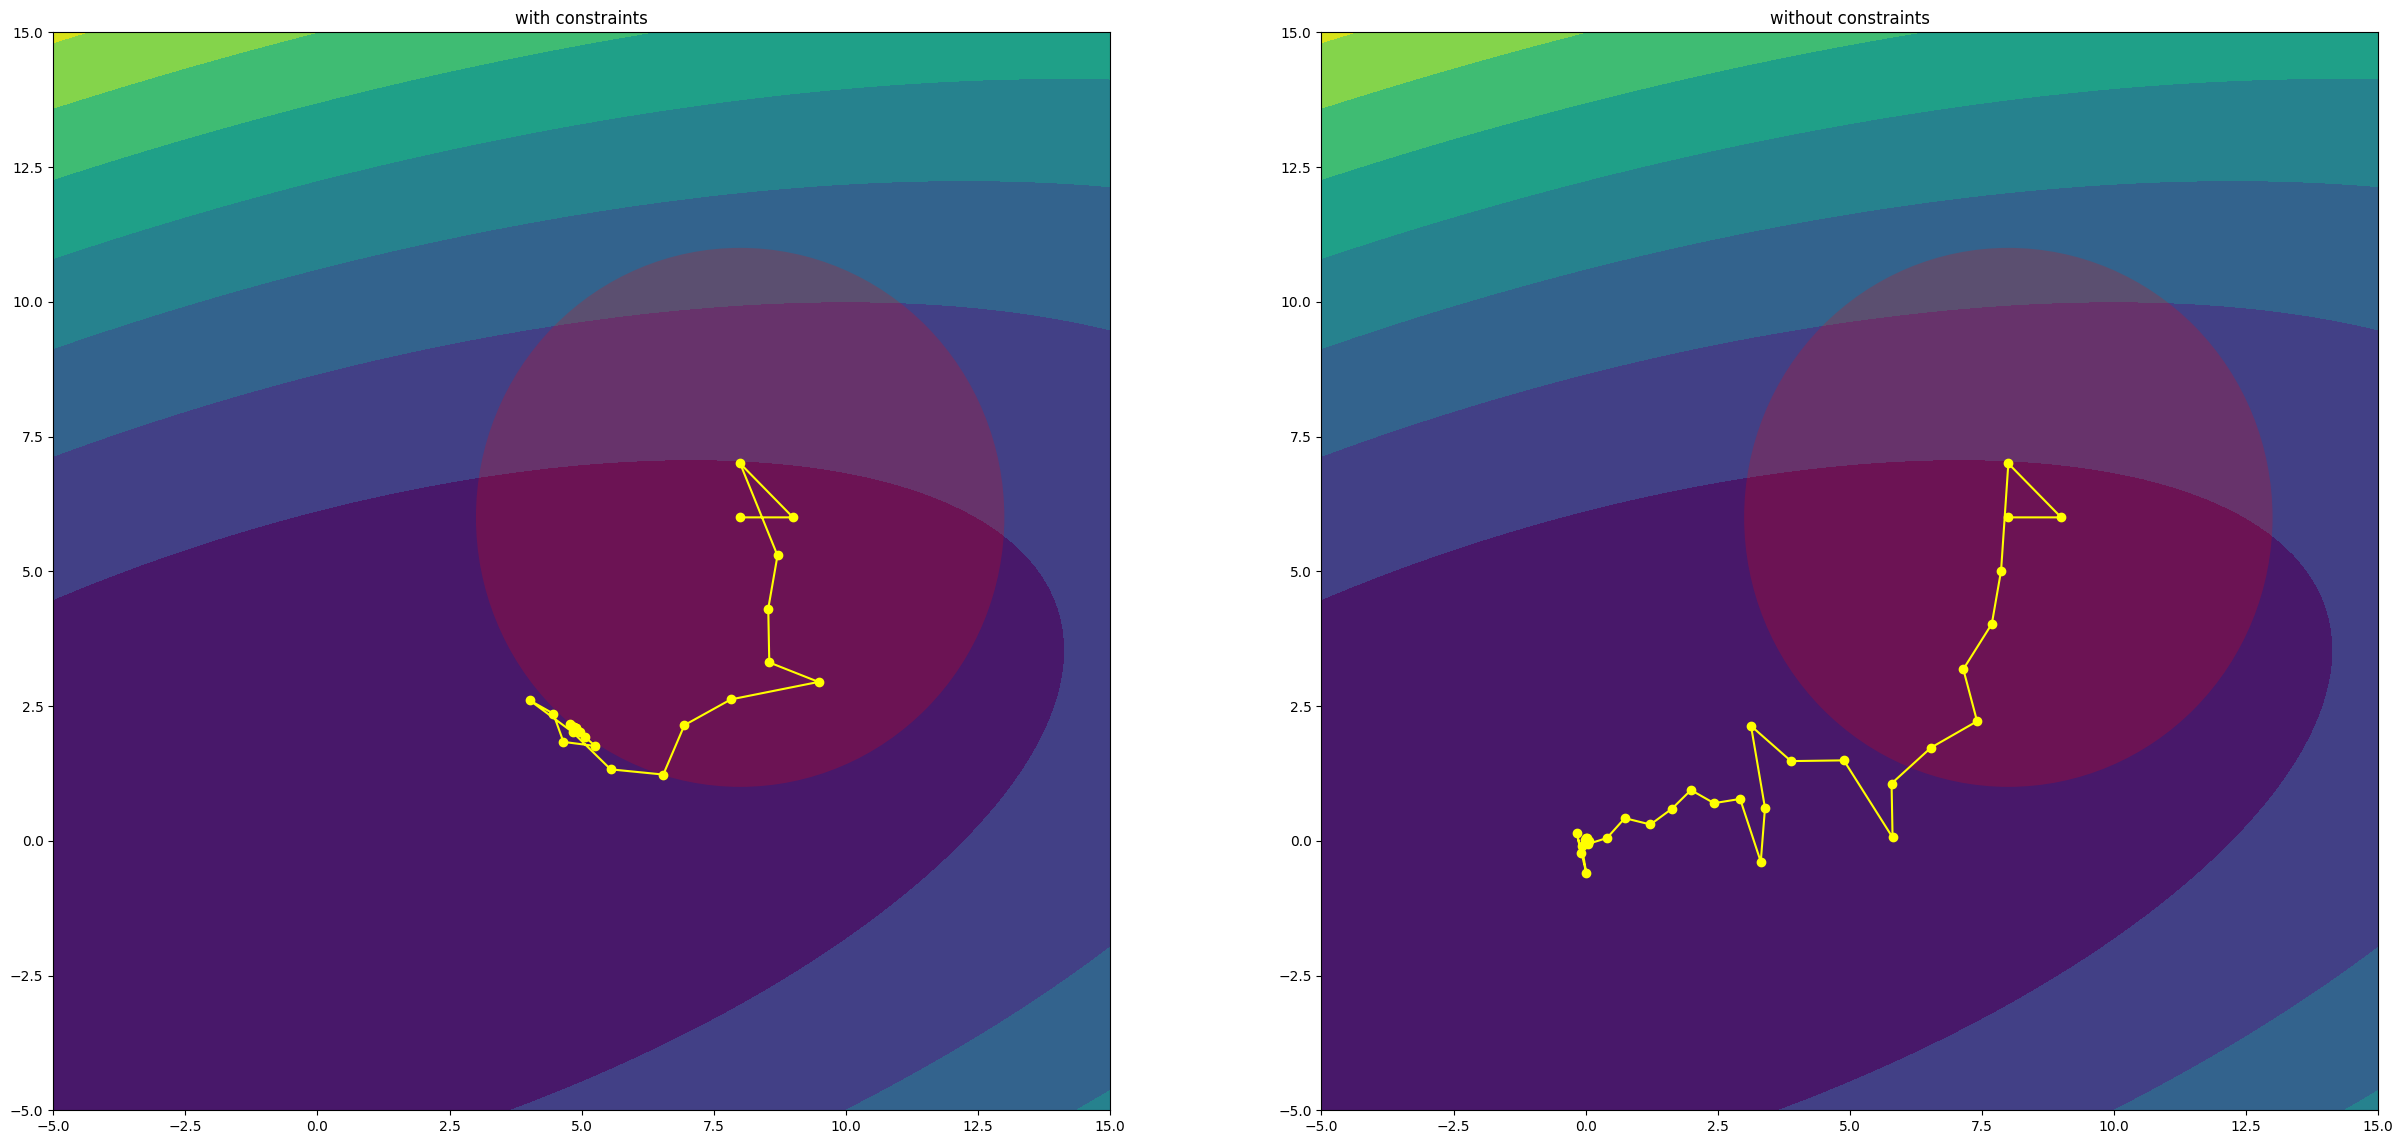

In [ ]:
test_bonus(f_3, 'COBYLA', nonlinear_constraint, f_cons)

# Вывод по границам

В ходе выполнения лабораторной работы, мы исследовали методы оптимизации и их поведение при использовании ограничений (constraints). На графиках траекторий оптимизации, мы можем наблюдать следующее:

1. Без ограничений (Unconstrained Optimization): В случае, когда нет ограничений, оптимизация стремится к нахождению минимума, и траектория сходится к точке минимума. Это ожидаемое поведение для стандартных методов оптимизации.

2. Ограничения внутри допустимой области (Interior Constraints): Если минимум находится внутри допустимой области, то траектория оптимизации остается внутри этой области и сходится к минимуму, не пересекая ограничения. В этом случае ограничения не влияют на результат оптимизации (не считая случаев, когда в процессе оптимизации выбирается точка за границей ограничений).

3. Ограничения, приводящие к пересечению (Boundary Constraints): Если минимум находится на границе допустимой области или за её пределами, траектория оптимизации достигает границы и следует по ней в направлении минимума. Это связано с тем, что ограничения оказывают влияние на оптимизацию, приводя к тому, что оптимальное решение находится на границе. В этом случае, оптимизация фактически происходит на границе, и траектория следует за ней.

Эти наблюдения подчеркивают важность правильного управления ограничениями при решении задач оптимизации. Если минимум находится на границе допустимой области, необходимо учесть это при выборе метода оптимизации и правильно определить ограничения, чтобы добиться успешной сходимости к оптимальному решению.

Также можно заметить, что алгоритм 'COBYLA' выбирает менее прямые траектории поиска минимума.